<a href="https://colab.research.google.com/github/JEMundelius/ZLP-Data-Fit-using-GPR/blob/main/Fitting_ZLP_Data_using_GPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code-Struktur als Experimente



### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

# which kernel? yes.
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel

# CO2-Experiment
from sklearn.datasets import fetch_openml
import pandas as pd
import datetime

# Voigt-Experiment
from scipy.special import wofz

# ZLP-Experiment
import json
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Elternklasse `DataAnalyzer`



In [ ]:
class DataAnalyzer:
  '''
  These parent-methods assume that a function_name and title are given by the instance of the childclass.
  '''
  def draw(self, plot_extra=False):
    #print("plot_extra ist: " + str(plot_extra))          #debug verbose
    label = self.label
    if self.X is not None and self.y is not None:
      plt.plot(self.X, self.y, label=label, linestyle="dotted")
    if self.X_train is not None and not plot_extra:
      plt.scatter(self.X_train, self.y_train, s=20, marker='x', alpha=0.8, label="Training Points", color='black')
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    #plt.title(self.title)
    self.plot_extra() if plot_extra else None # possibly Artifact?
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/ZLP Output Graphics/" + self.title + ".png", dpi=300, bbox_inches='tight')
    plt.show()

  def plot_extra(self): # possibly Artifact?
    pass

  def gpr_fit(self, kernel = 1 * RBF(length_scale=1.0), alpha=1e-10):
    if self.X_train is None or self.y_train is None:
      print("Trainingsdaten liegen nicht vor.")
      return
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,alpha = alpha)
    gaussian_process.fit(self.X_train, self.y_train)
    self.mean_prediction, self.std_prediction = gaussian_process.predict(self.X, return_std=True)
    self.gpr_kernel = gaussian_process.kernel_
    self.gpr_lml = gaussian_process.log_marginal_likelihood(eval_gradient=False)

  def drawfit(self, optout=False, log=False, xlim=None,ylim=None, noise=None):
    if self.X is not None and self.y is not None:
      plt.plot(self.X, self.y, label = self.label, linestyle="dotted") if not optout else None                                                      # function
    if noise is None:                                                                                                           # Training Points
      plt.scatter(self.X_train, self.y_train, s=20, marker='x', alpha=0.8, label="Observations", color='black')
    else:
      plt.errorbar(self.X_train, self.y_train, noise, linestyle="None", color="black", marker="x", markersize=5, capsize=3, label="Observations")
    plt.plot(self.X, self.mean_prediction, label="Mean prediction", color='darkorange')                                         # GPR mean
    plt.fill_between(                                                                                                           # GPR std
        self.X.ravel(),
        self.mean_prediction - 1 * self.std_prediction,
        self.mean_prediction + 1 * self.std_prediction,
        alpha=0.5,
        label=r"1-sigma interval",
        color='darkorange',
        edgecolor='darkorange'
    )
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    #plt.title(self.title)
    plt.yscale('log') if log else None
    plt.xlim(xlim) if xlim is not None else None
    plt.ylim(ylim) if ylim is not None else None
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/ZLP Output Graphics/" + self.title + ".png", dpi=300, bbox_inches='tight')
    plt.show()

# Experiment 1: Analytical Fit



In [ ]:
class AnalyticalExperiment(DataAnalyzer):
  '''
  Every Childclass of DataAnalyzer needs a function name and a title for correct plots.
  '''
  def __init__(self, seed=1, label=None):
    self.X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
    self.y = self.function_name = self.title = self.X_train = None
    self.rng = np.random.RandomState(seed)
    self.label = label

  def generate(self,function,title):
    self.testfunction = function(self.X)
    self.title = title
    self.y = np.squeeze(self.testfunction)

  def trainingdata(self, size=6):
    '''
    While the rng-seed is initiated when creating the instance, the sample size must be given as an optional input when generating y_train.
    '''
    training_indices = self.rng.choice(np.arange(self.y.size), size, replace=False)
    self.X_train, self.y_train = self.X[training_indices], self.y[training_indices]

  def noisify(self, noise_std = 0.75):
    self.y_train = self.y_train + self.rng.normal(loc=0.0, scale=noise_std, size=self.y_train.shape)

## `Alaric`-Experiment

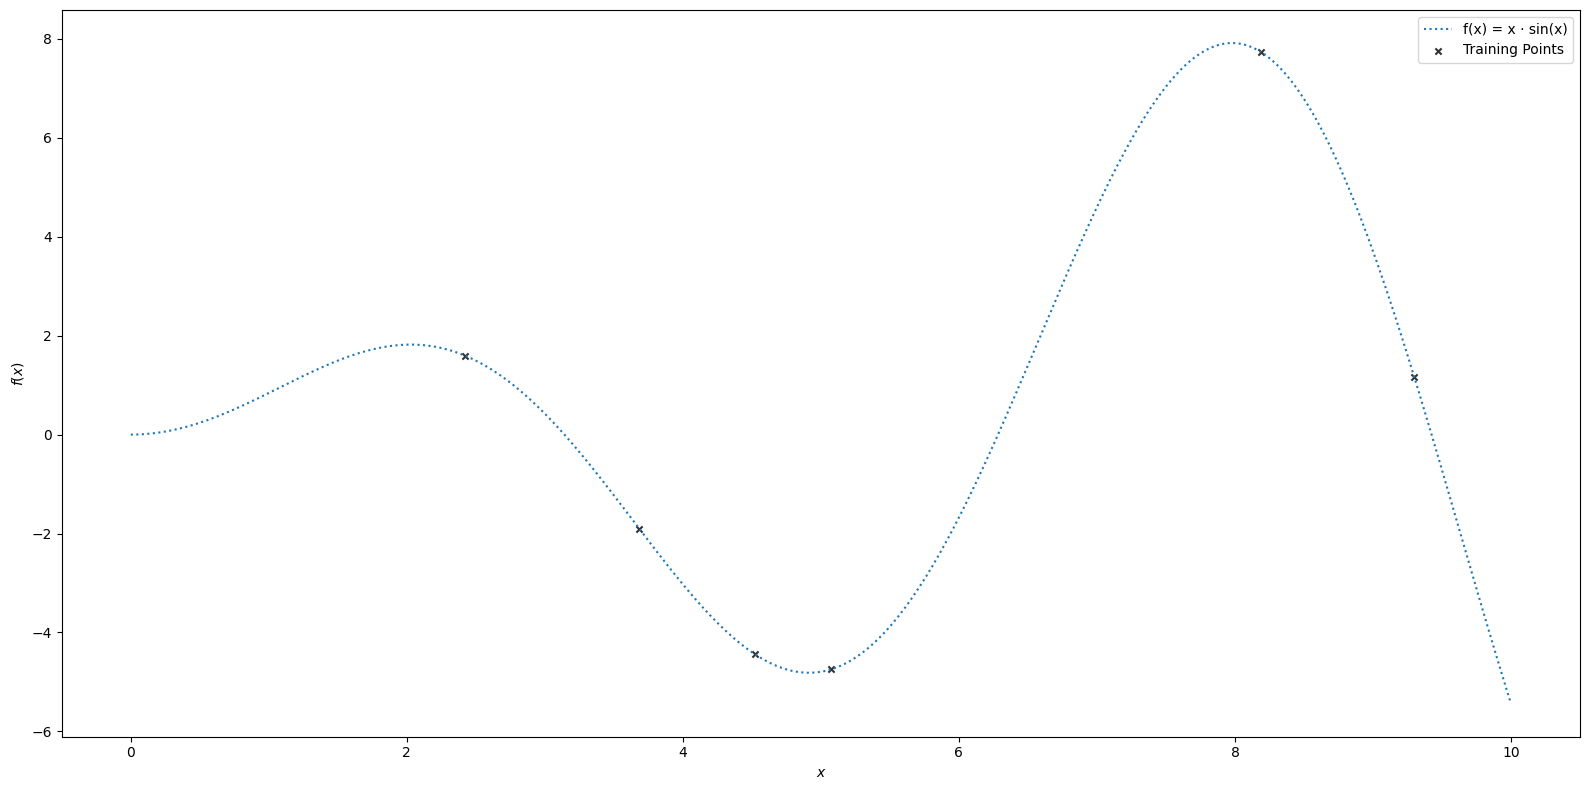

In [ ]:
def schwingung(x):
    return x * np.sin(x)

Alaric = AnalyticalExperiment()
Alaric.label = r"f(x) = x ⋅ sin(x)"
Alaric.generate(schwingung, "Alaric: Schwingungsprozess mit ausgewählten Trainingspunkten")
Alaric.trainingdata()
Alaric.draw()

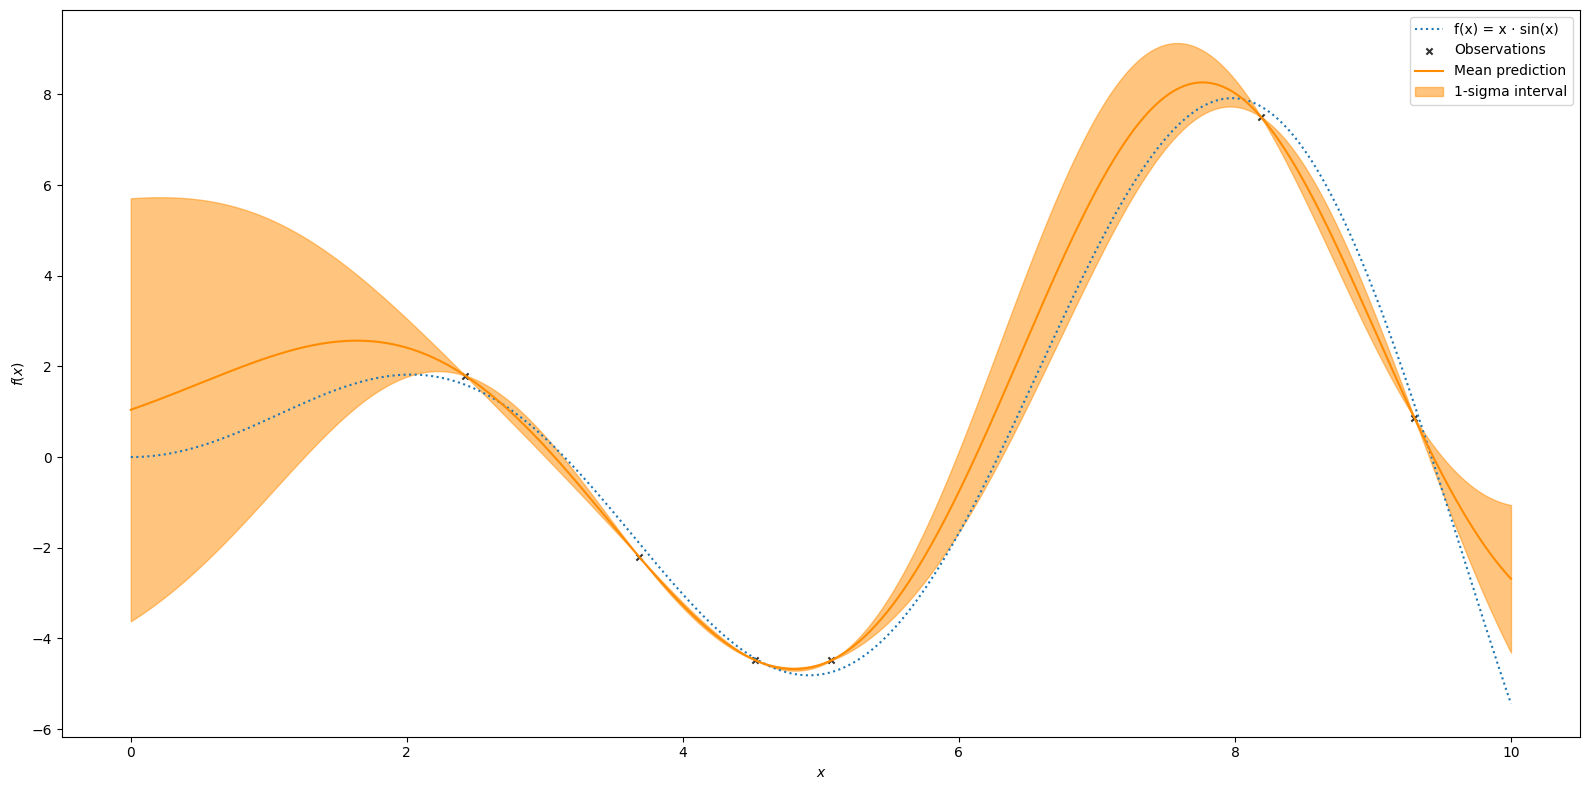


Der resultierende Kernel nach dem GP: 5.1**2 * RBF(length_scale=1.47)


In [ ]:
Alaric.gpr_fit()
Alaric.title = "Alaric: GPR auf Schwingungsprozess basierend auf ausgewählten Trainingspunkten"
Alaric.drawfit()
print("\n" + "Der resultierende Kernel nach dem GP: " + str(Alaric.gpr_kernel))

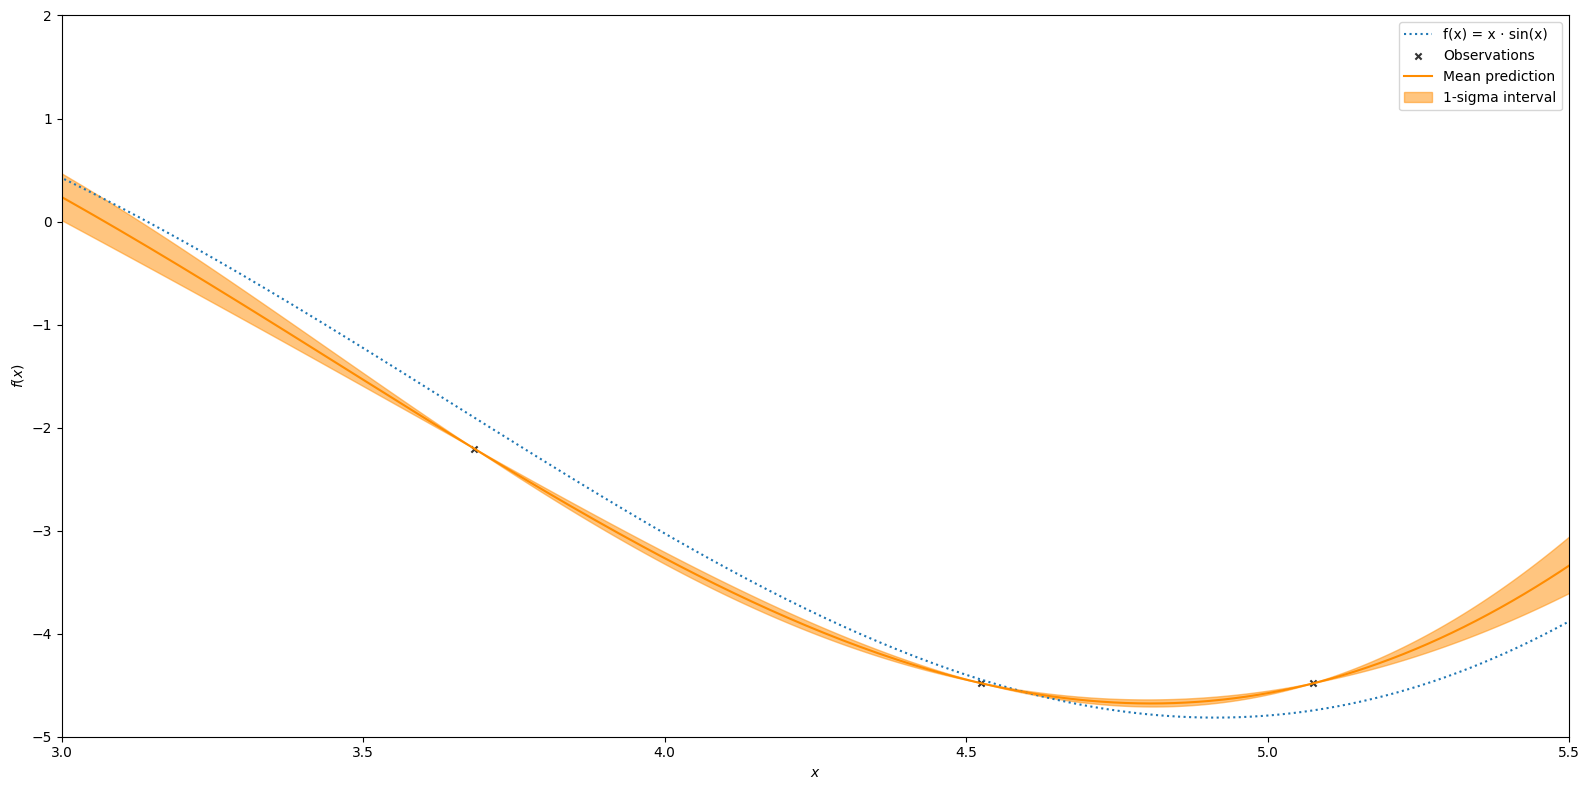

In [ ]:
Alaric.title = "Alaric: GPR auf Schwingungsprozess basierend auf ausgewählten Trainingspunkten - Ausschnitt x=3.0 bis x=5.5"
Alaric.drawfit(xlim=(3,5.5), ylim=(-5,2))

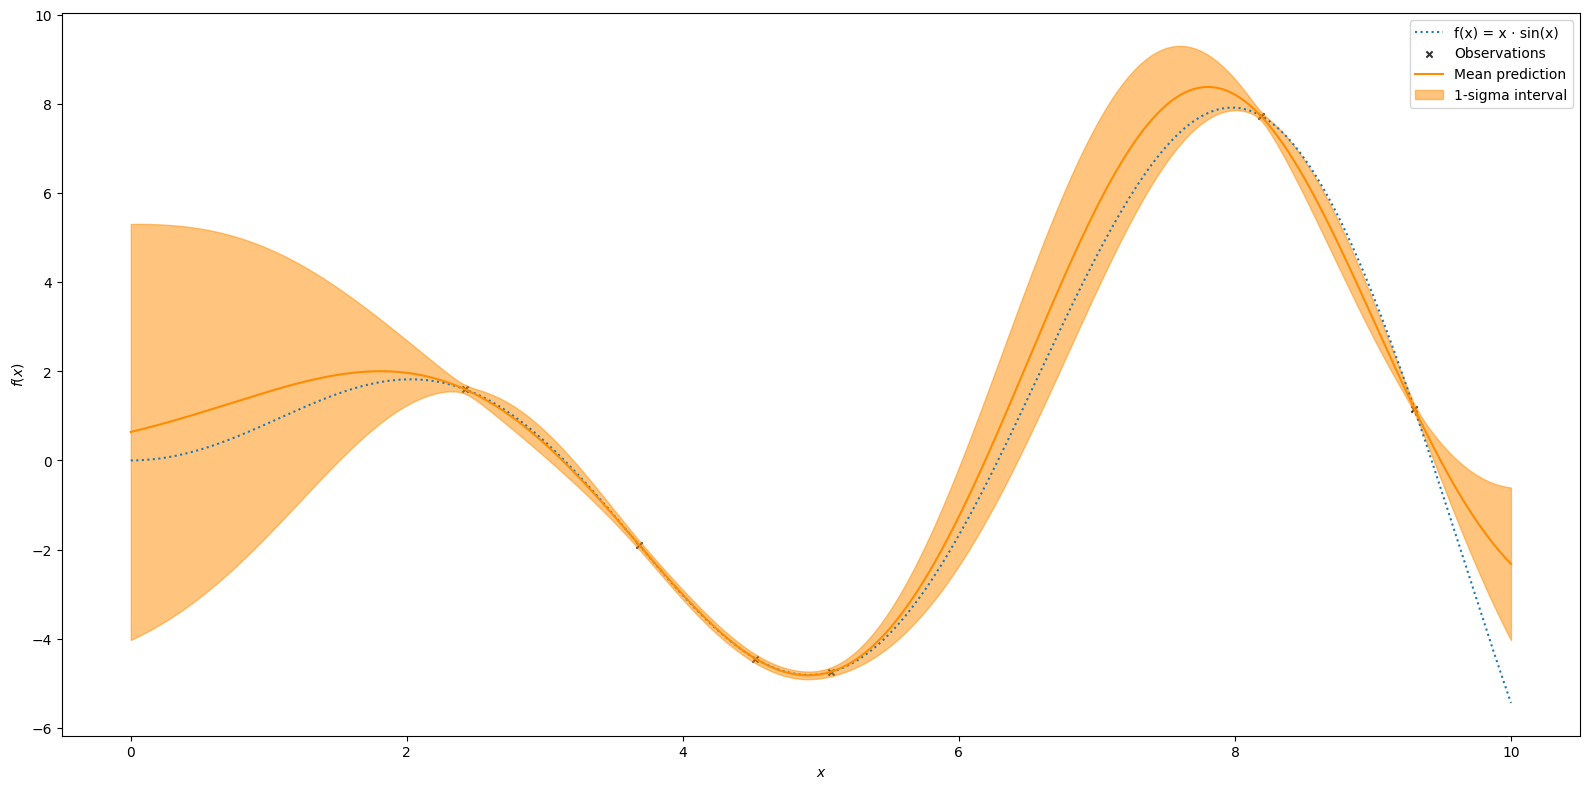

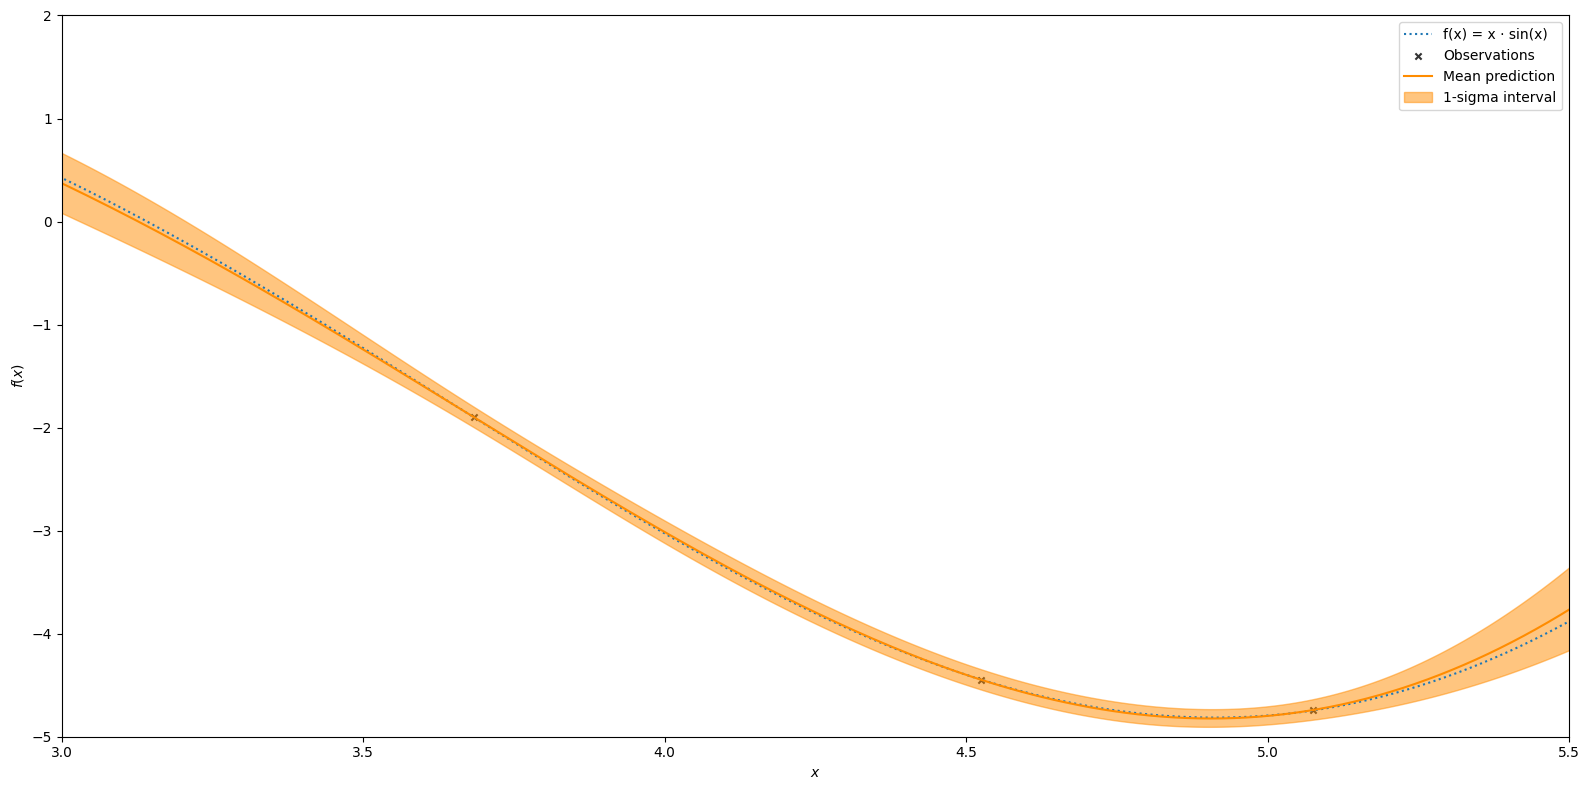


Der resultierende Kernel nach dem GP: 4.99**2 * RBF(length_scale=1.42)


In [ ]:
Alaric.gpr_fit(alpha=1e-2)
Alaric.title = "Alaric: GPR auf Schwingungsprozess basierend auf ausgewählten Trainingspunkten mit erhöhtem alpha"
Alaric.drawfit()
Alaric.title = "Alaric: GPR auf Schwingungsprozess basierend auf ausgewählten Trainingspunkten mit erhöhtem alpha - Ausschnitt x=3.0 bis x=5.5"
Alaric.drawfit(xlim=(3,5.5), ylim=(-5,2))
print("\n" + "Der resultierende Kernel nach dem GP: " + str(Alaric.gpr_kernel))

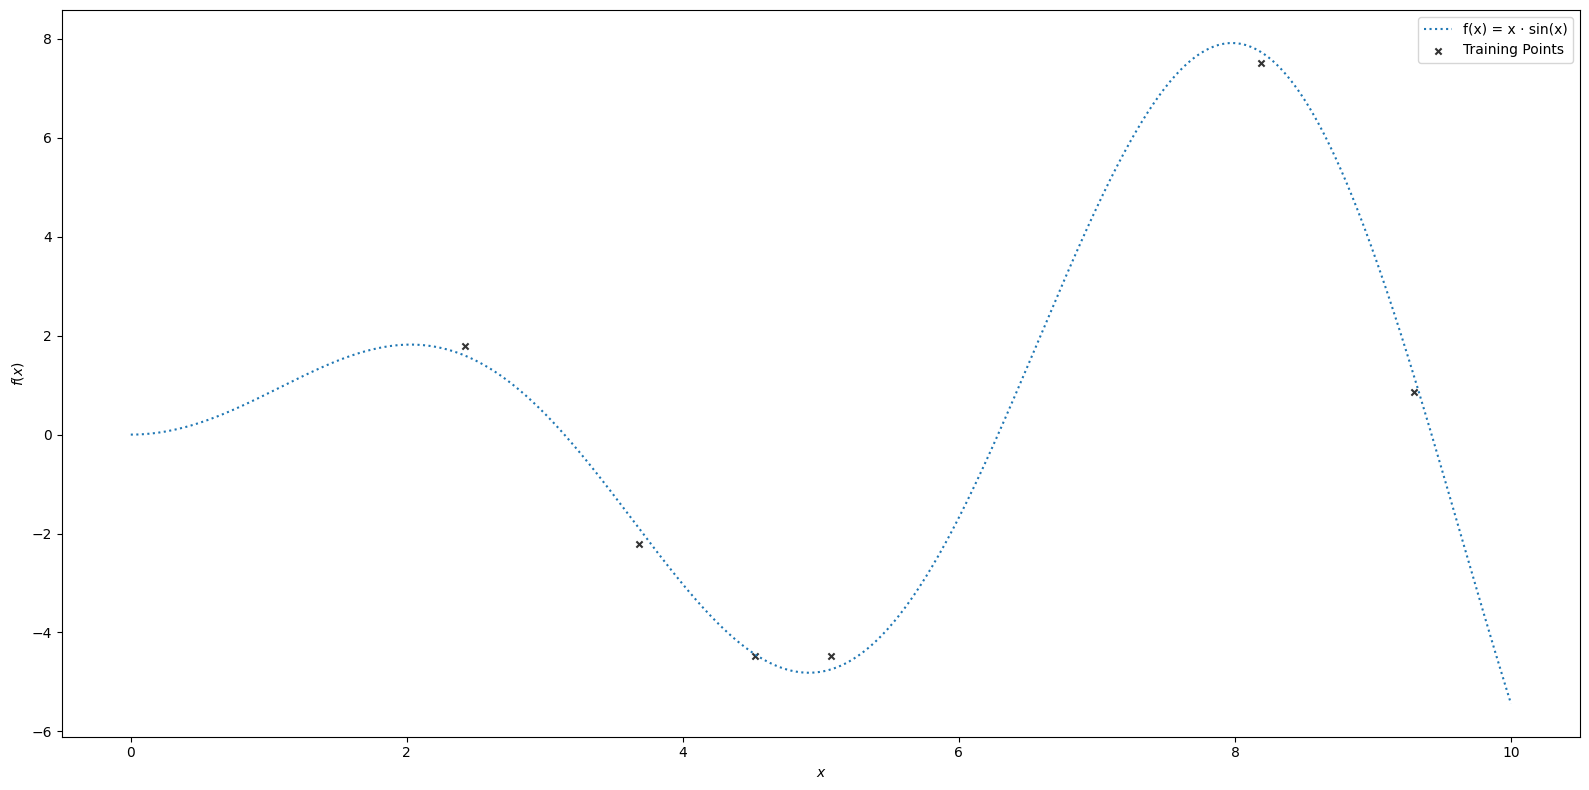

In [ ]:
Alaric.noisify(0.2)
Alaric.title = "noisy Alaric: Schwingungsprozess mit verrauschten Trainingspunkten betragsmäßig nicht mehr als 0.2 abweichend"
Alaric.draw()

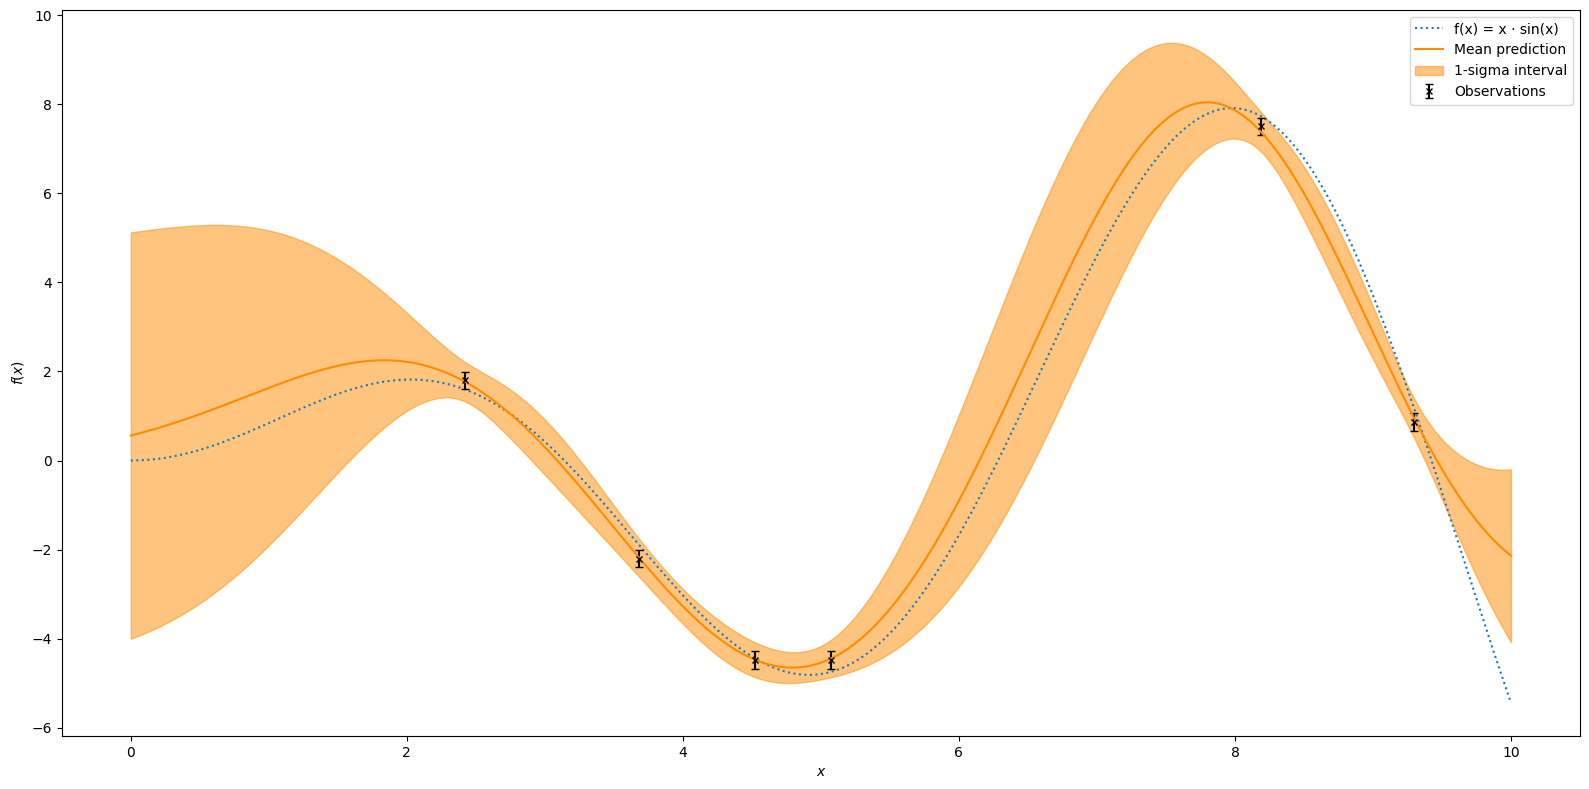

In [ ]:
Alaric.gpr_fit(alpha=0.2)
Alaric.title = "noisy Alaric: GPR auf Schwingungsprozess basierend auf verrauschten Trainingspunkten"
Alaric.drawfit(noise=0.2)

## `Bryson` & `Corin`-Experiment

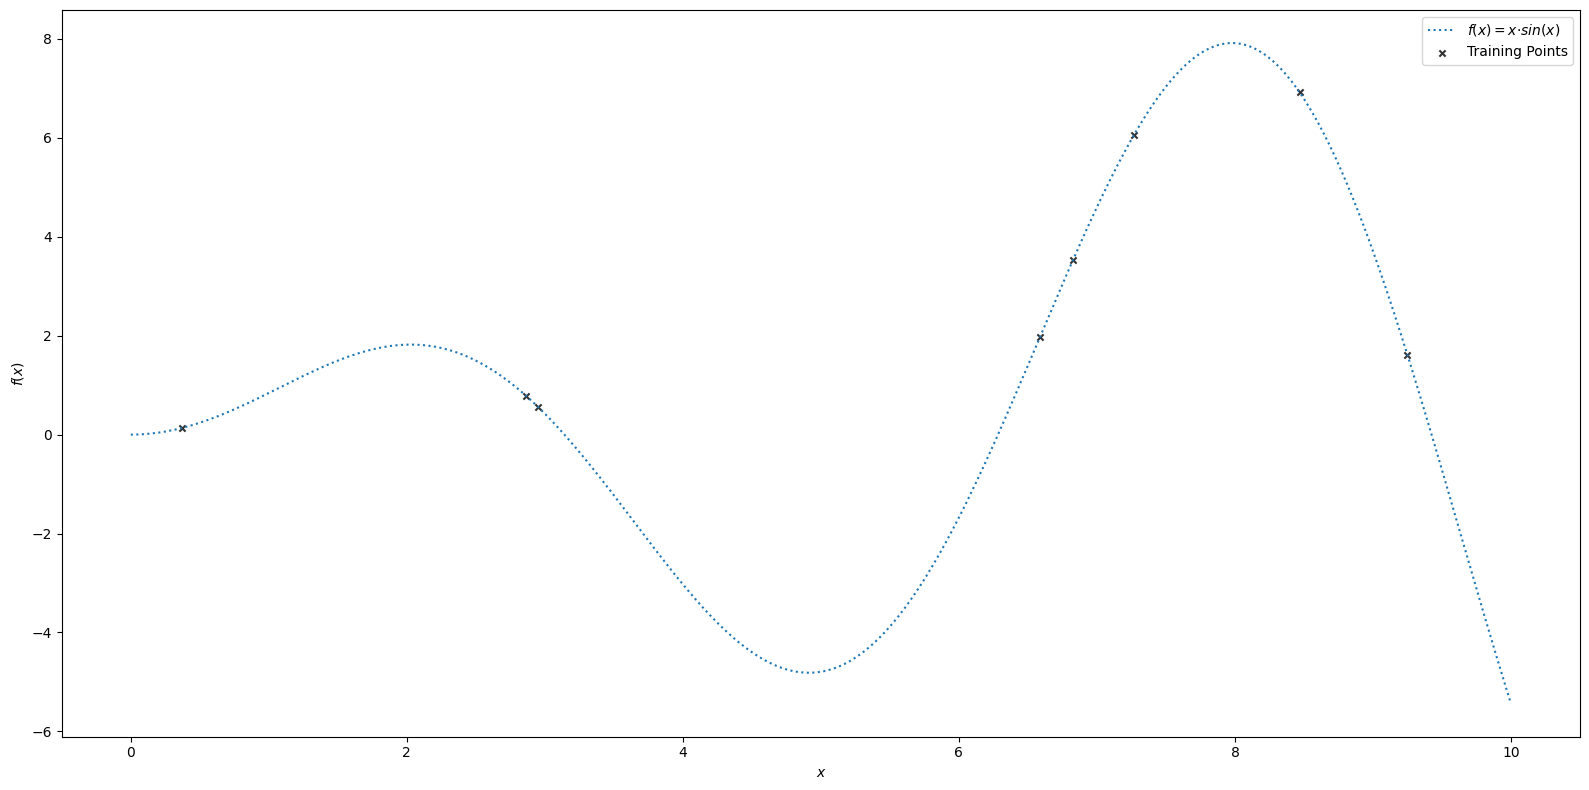

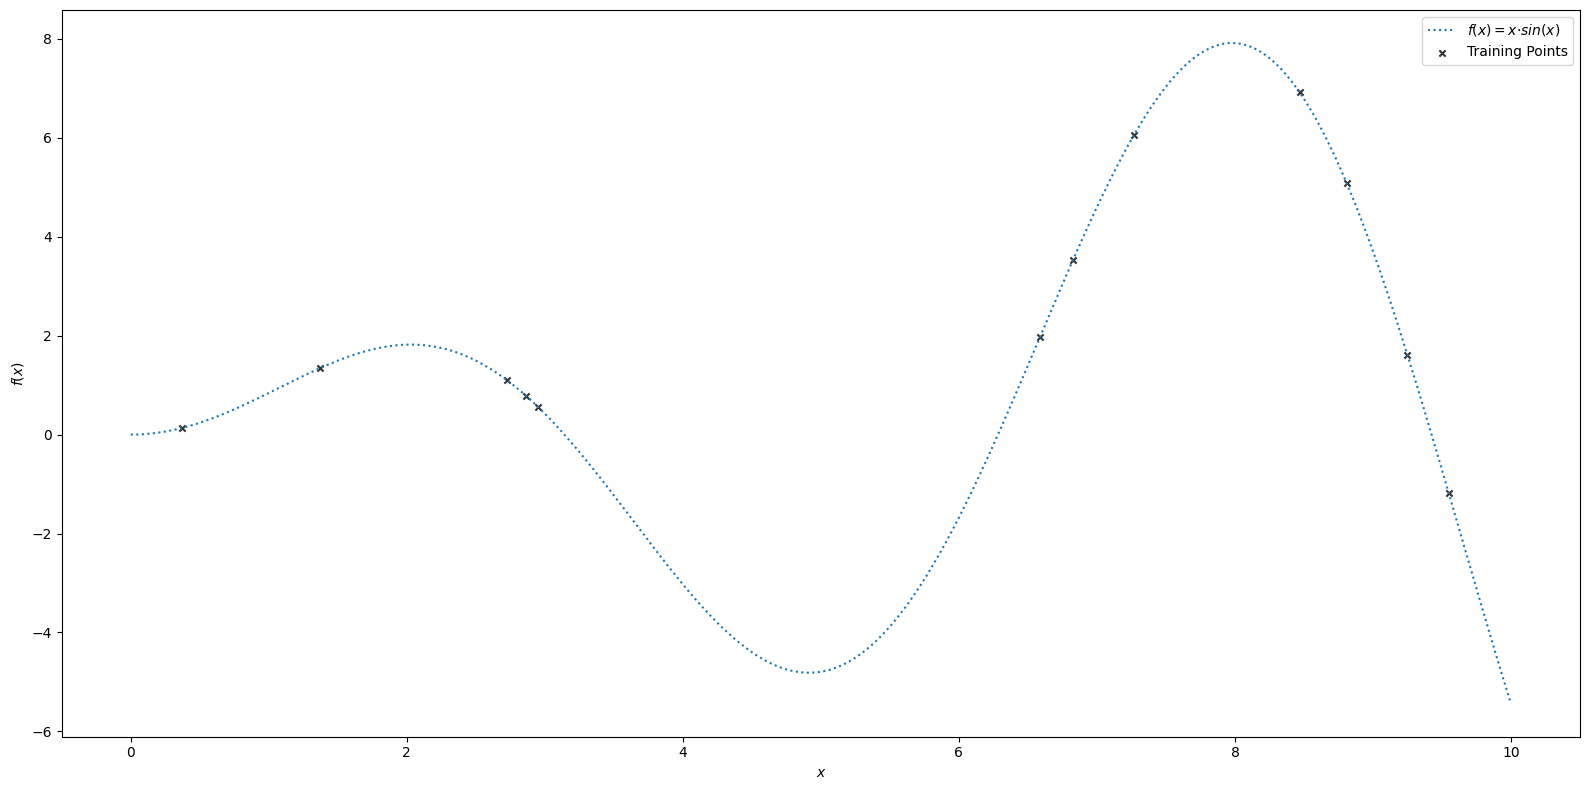

In [ ]:
Bryson = AnalyticalExperiment(seed=2)
Bryson.generate(schwingung, "Bryson: Schwingungsprozess mit 8 Trainingspunkten basierend auf seed=2")
Bryson.trainingdata(size=8)
Bryson.label=r'$f(x)=x ⋅ sin(x)$'
Bryson.draw()

Corin = AnalyticalExperiment(seed=2)
Corin.generate(schwingung, "Corin: Schwingungsprozess mit 12 Trainingspunkten basierend auf seed=2")
Corin.trainingdata(size=12)
Corin.label=r'$f(x)=x ⋅ sin(x)$'
Corin.draw()

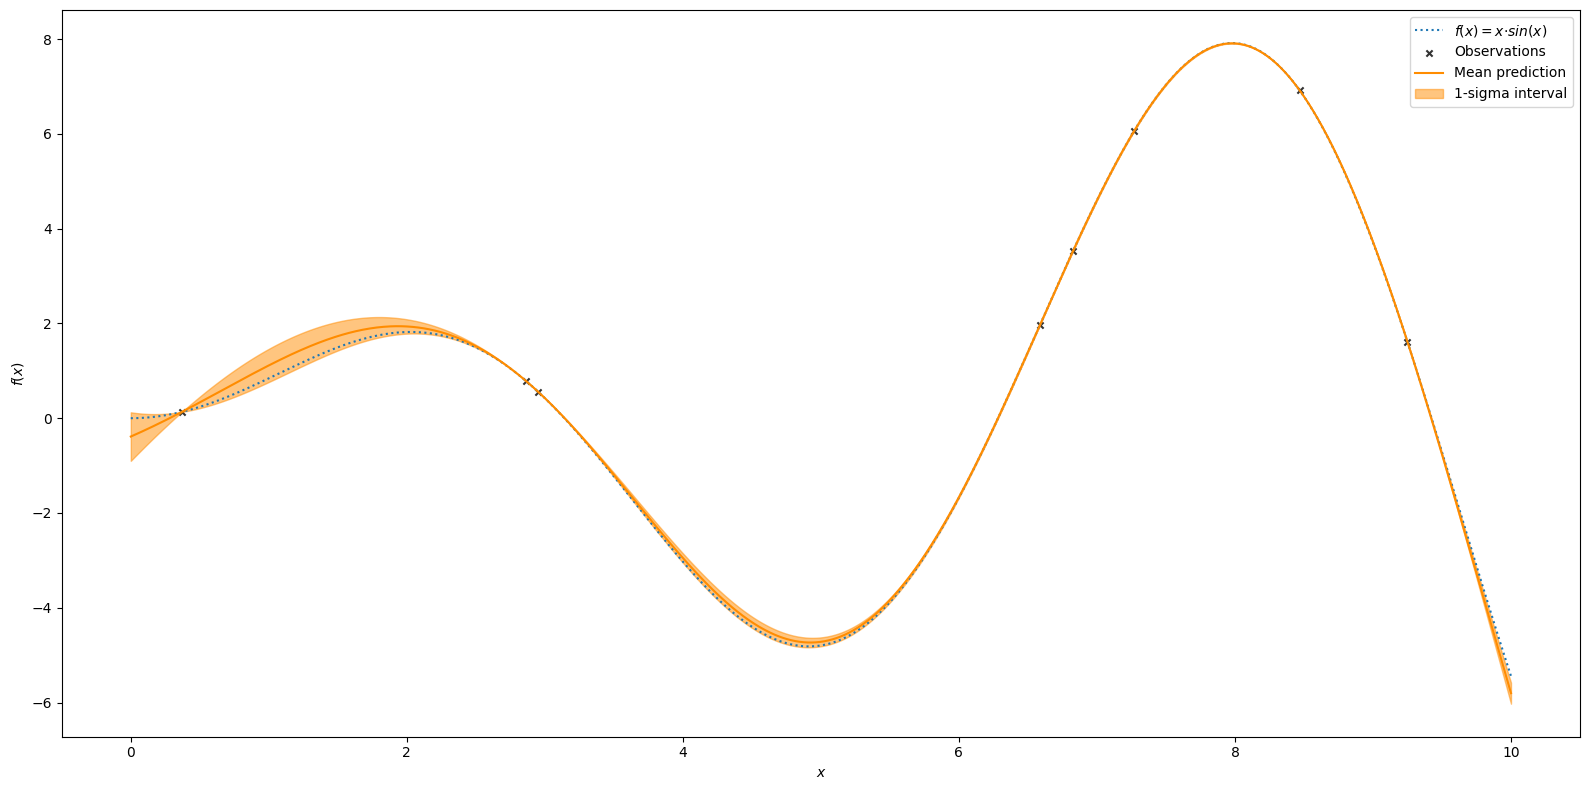


Der resultierende Kernel nach dem GP: 10.7**2 * RBF(length_scale=2.36)



/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


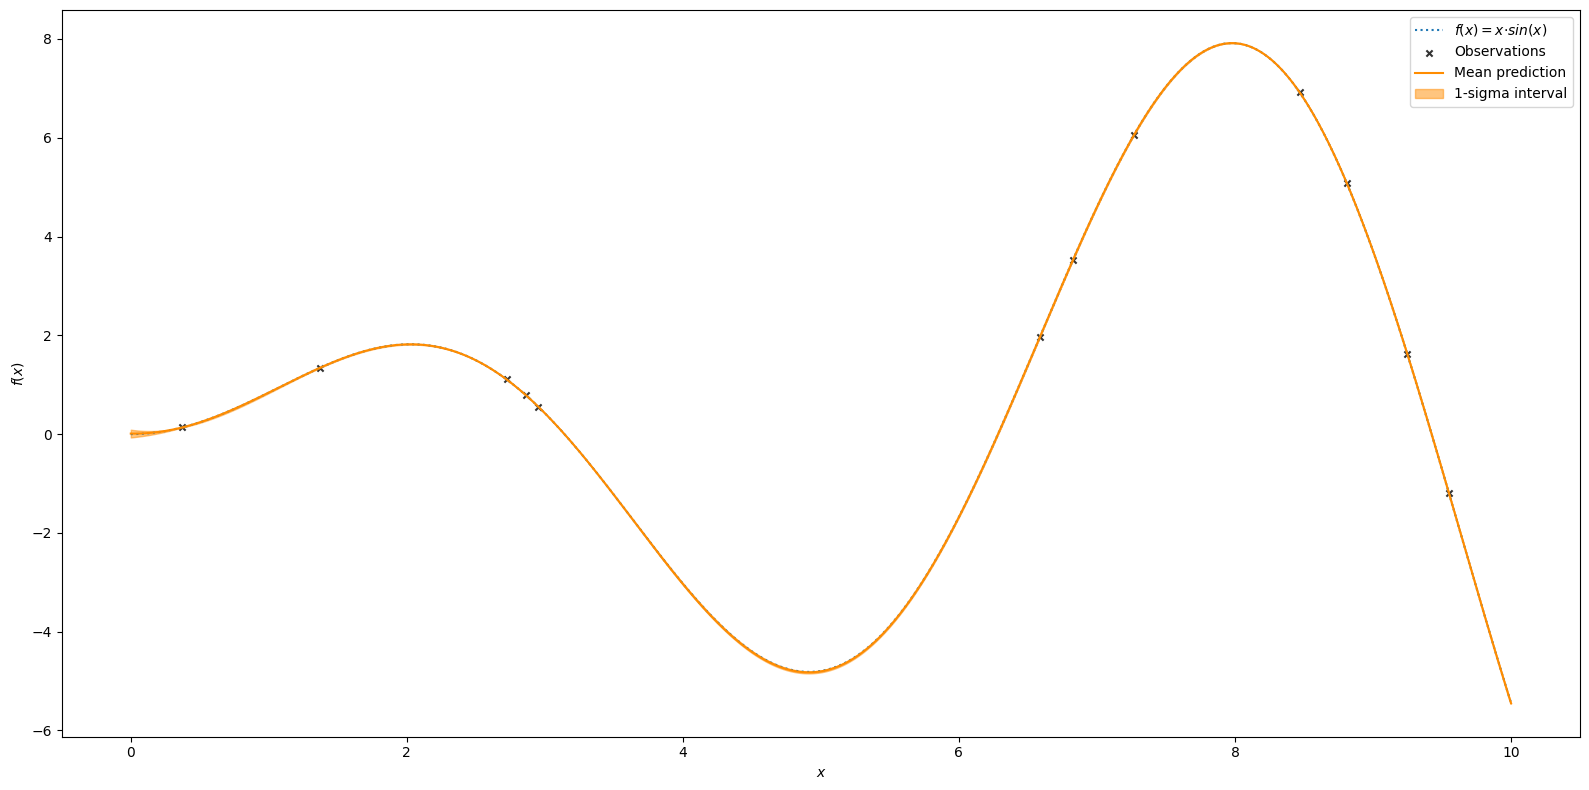


Der resultierende Kernel nach dem GP: 10.7**2 * RBF(length_scale=2.36)



In [ ]:
Bryson.gpr_fit()
Bryson.title = "Bryson: GPR auf Schwingungsprozess basierend auf 8 Trainingspunkten nach seed=2"
Bryson.drawfit()
print("\n" + "Der resultierende Kernel nach dem GP: " + str(Bryson.gpr_kernel) + "\n")

Corin.gpr_fit(alpha=1e-7)
Corin.title = "Corin: GPR auf Schwingungsprozess basierend auf 12 Trainingspunkten nach seed=2"
Corin.drawfit()
print("\n" + "Der resultierende Kernel nach dem GP: " + str(Bryson.gpr_kernel) + "\n")

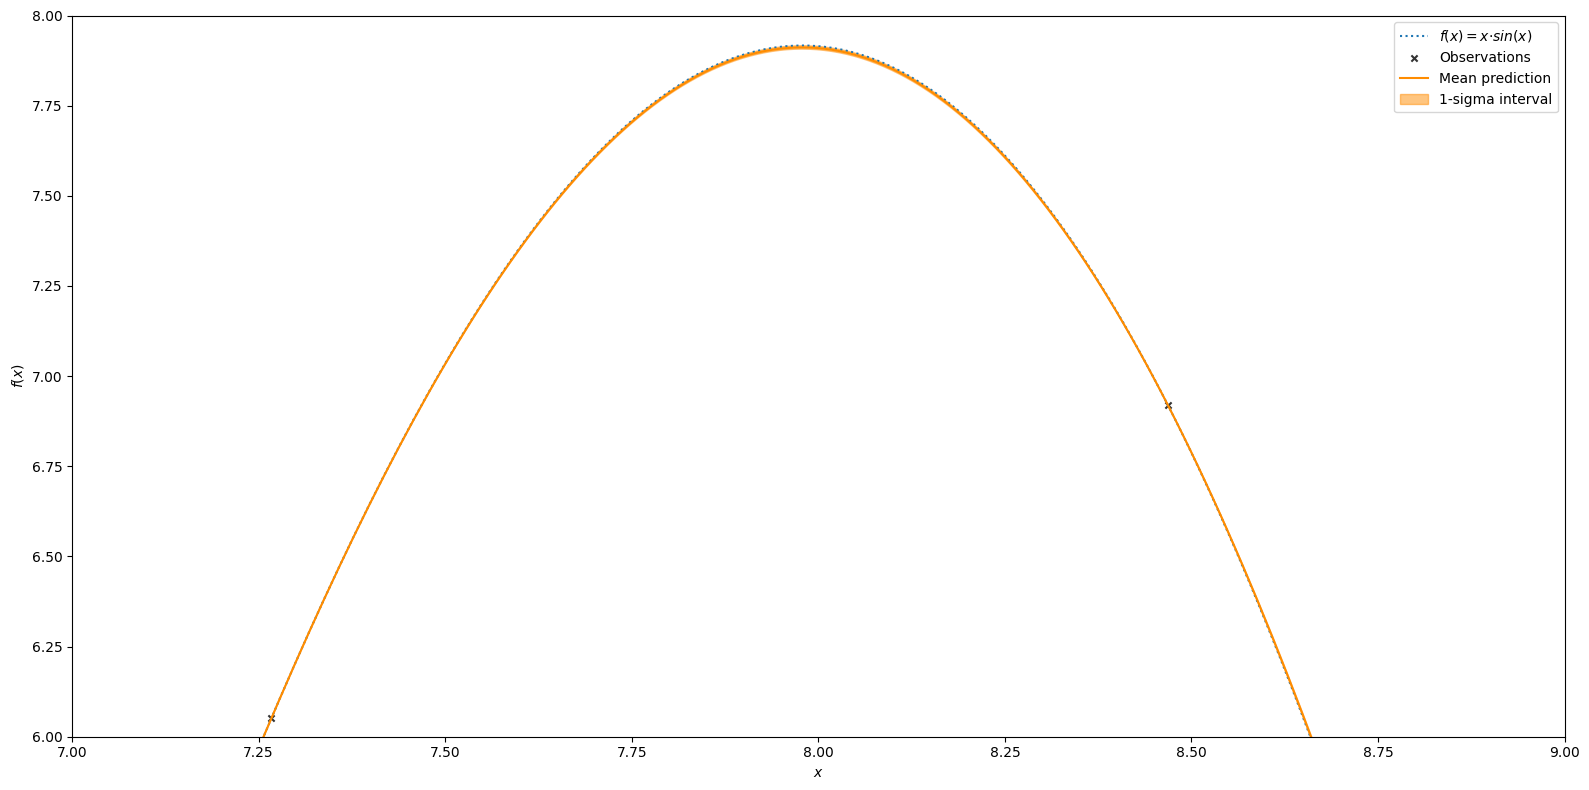

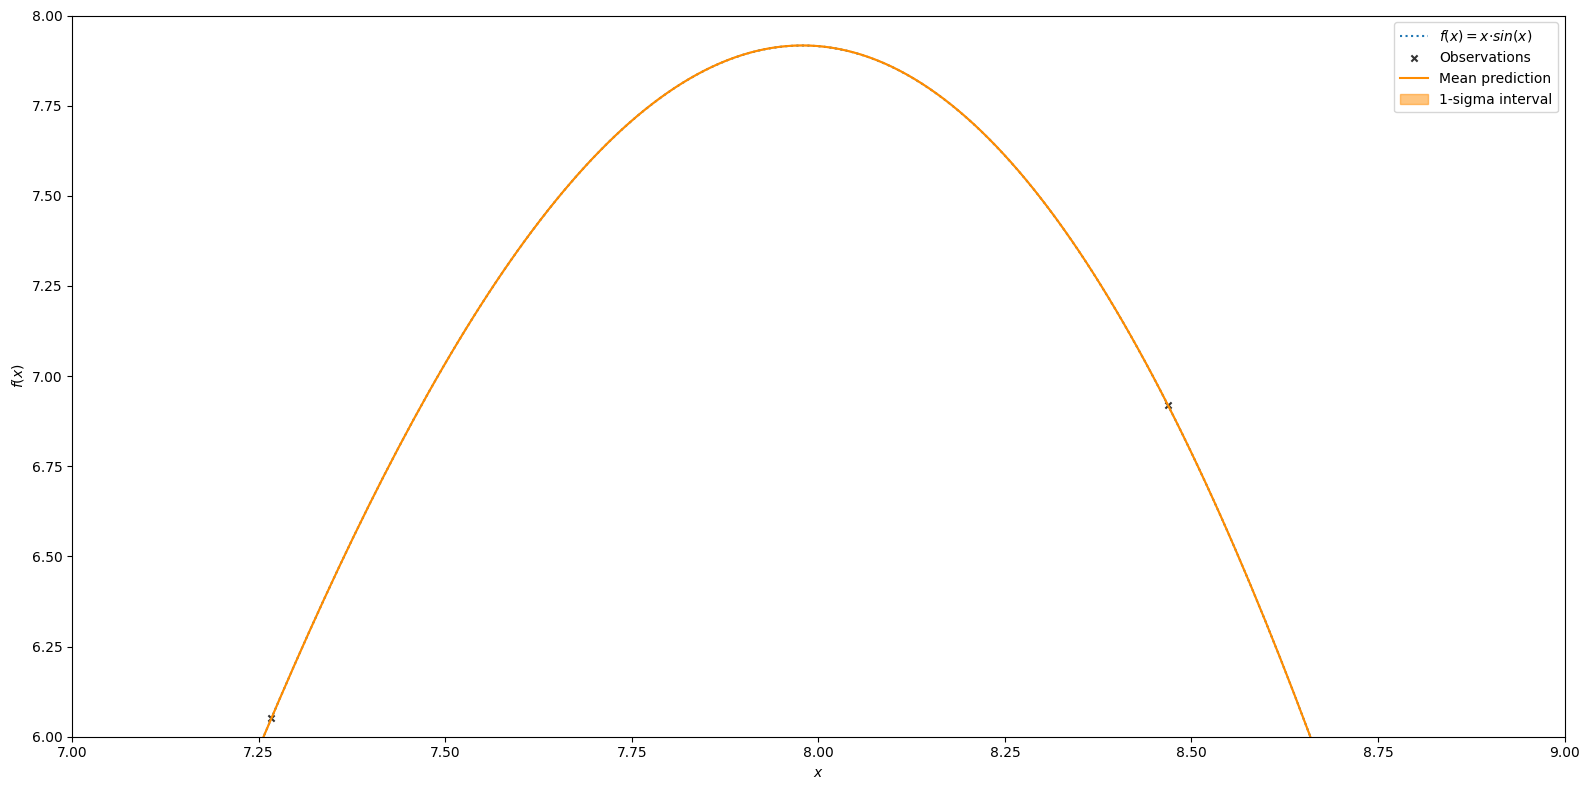

In [ ]:
Bryson.title = "Bryson: GPR auf Schwingungsprozess - Berg-Ausschnitt"
Bryson.drawfit(xlim=(7,9), ylim=(6,8))

Corin.title = "Corin: GPR auf Schwingungsprozess - Berg-Ausschnitt"
Corin.drawfit(xlim=(7,9), ylim=(6,8))

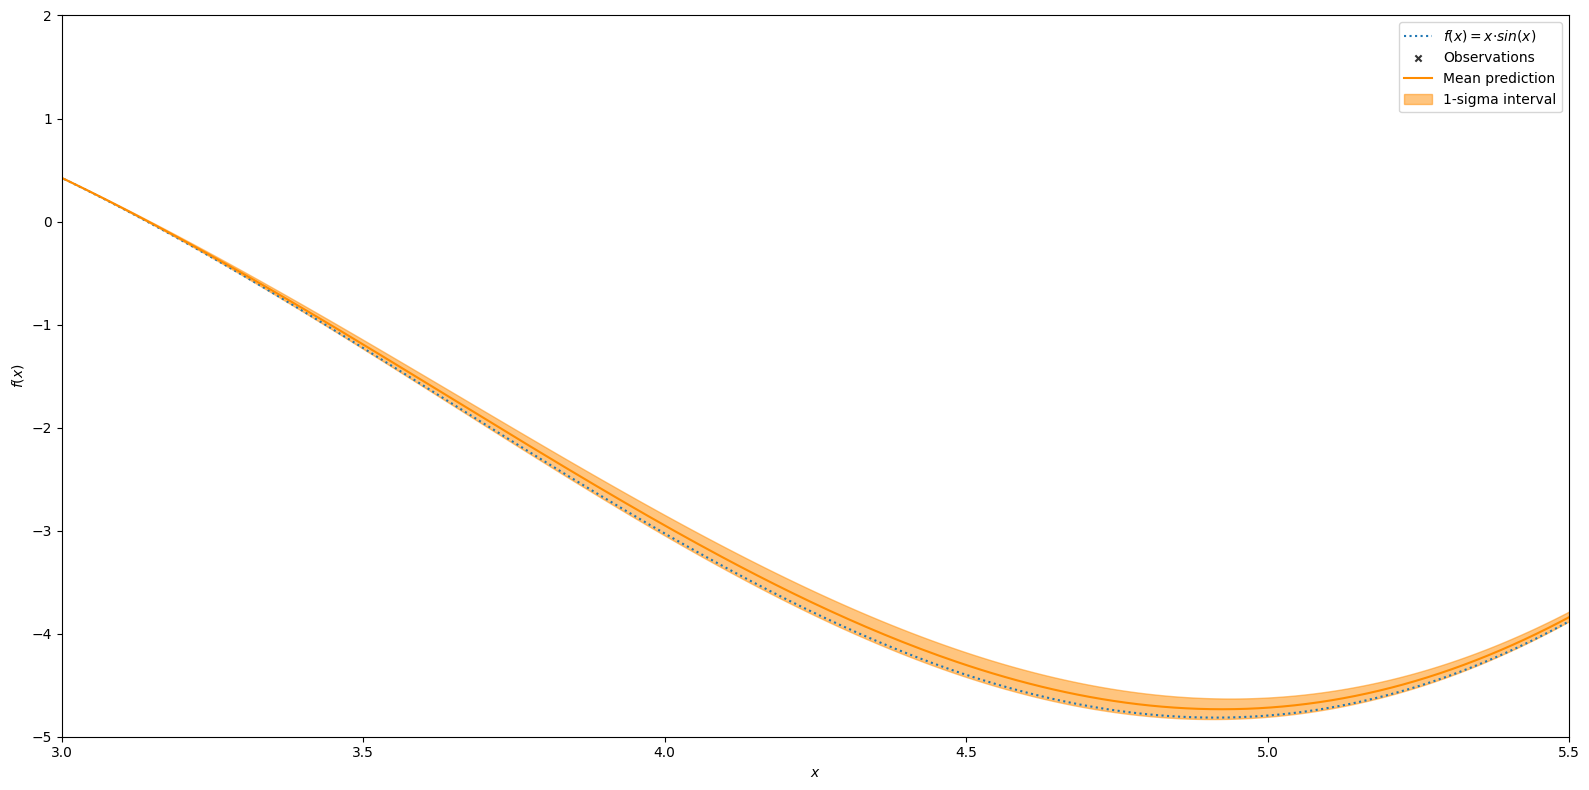

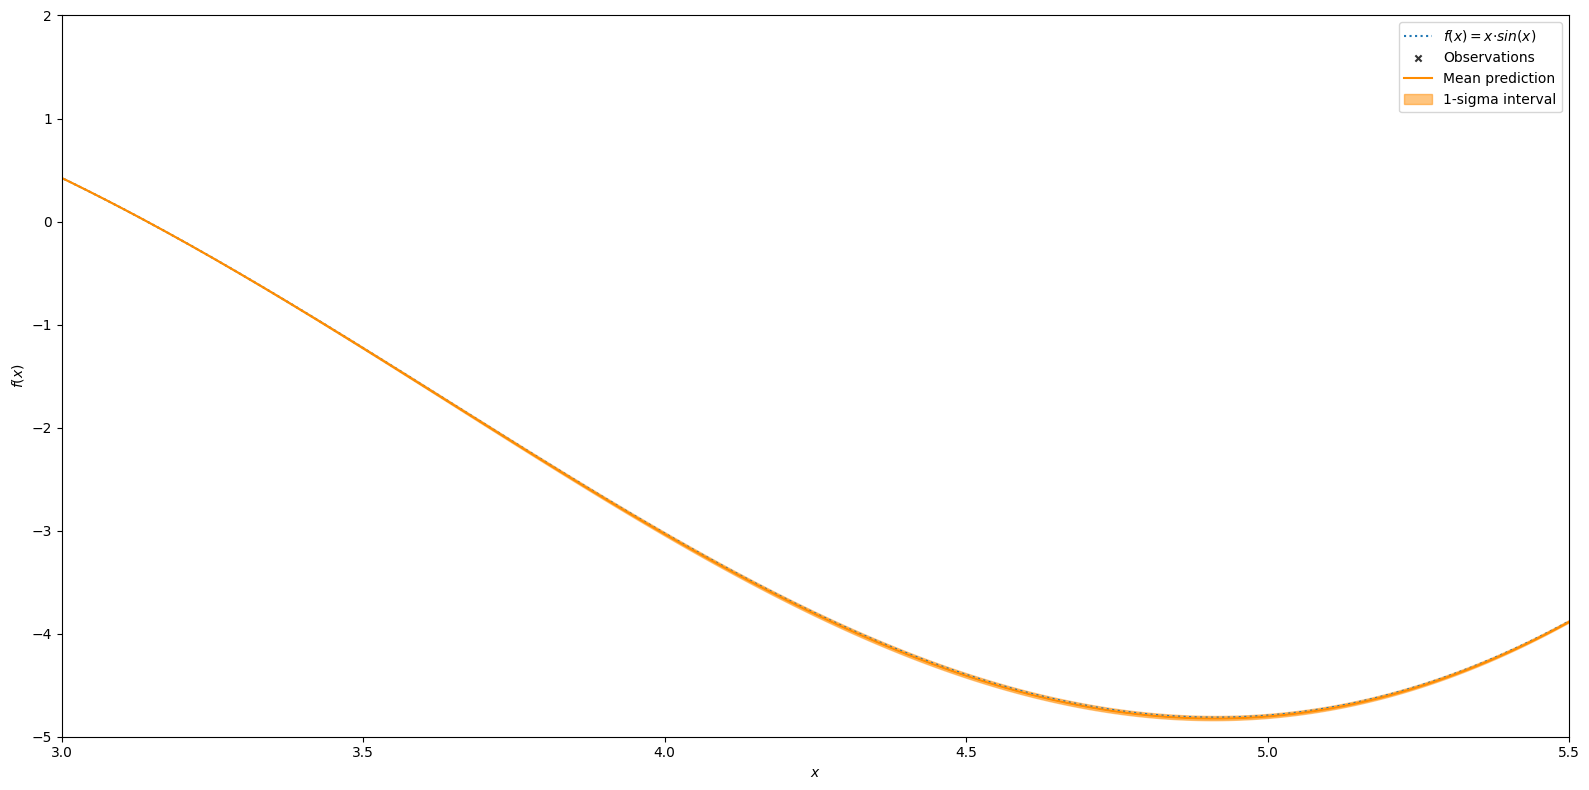

In [ ]:
Bryson.title = "Bryson: GPR auf Schwingungsprozess - Tal-Ausschnitt"
Bryson.drawfit(xlim=(3,5.5), ylim=(-5,2))

Corin.title = "Corin: GPR auf Schwingungsprozess - Tal-Ausschnitt"
Corin.drawfit(xlim=(3,5.5), ylim=(-5,2))

##`Darian`-Experiment



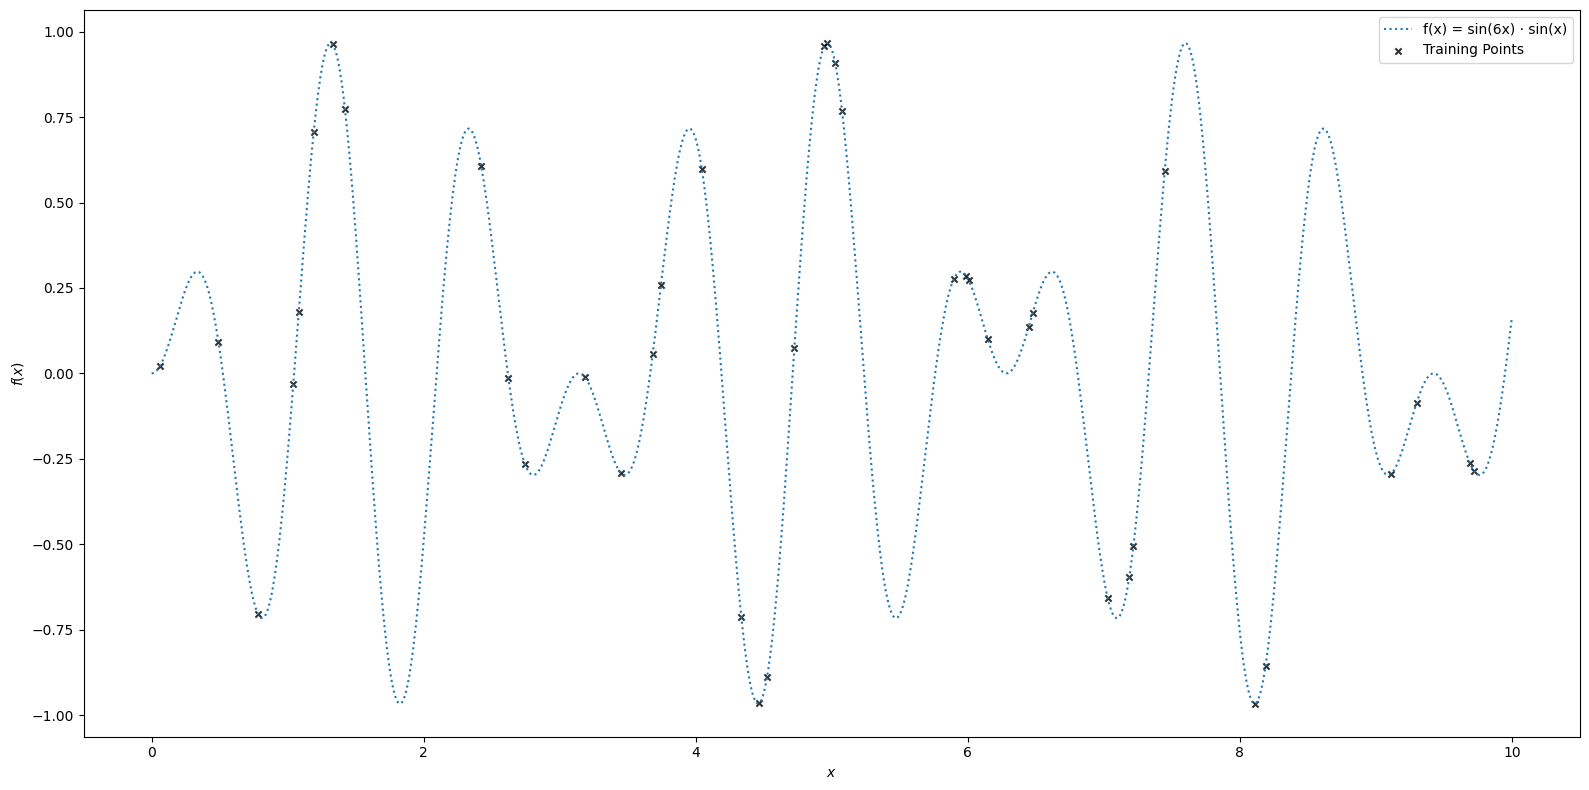

In [ ]:
def modulated_sine_wave(x):
  return np.sin(6*x) * np.sin(x)

Darian = AnalyticalExperiment()
Darian.generate(modulated_sine_wave, "Darian: modulierter Sinus mit ausgewählten Trainingspunkten")
Darian.trainingdata(size=40)
Darian.label=r'f(x) = sin(6x) ⋅ sin(x)'
Darian.draw()

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


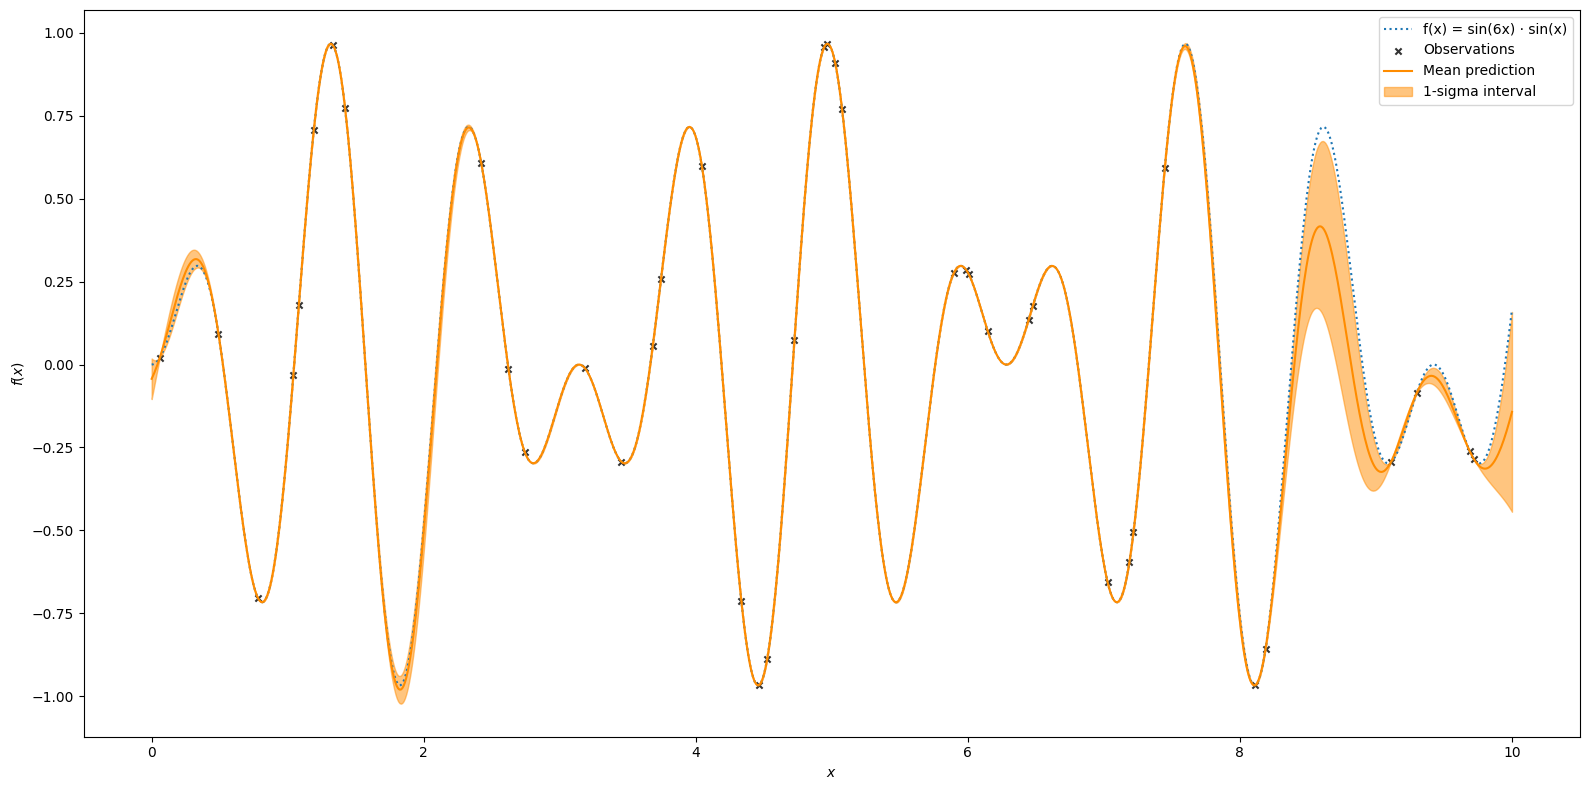


Der resultierende Kernel nach dem GP: 1.95**2 * ExpSineSquared(length_scale=9.7e-05, periodicity=2.87e+04)



In [ ]:
modsin_kernel_1 = 1**2 * ExpSineSquared(length_scale=1.0)

Darian.gpr_fit(modsin_kernel_1)
Darian.title = "Darian: GPR auf modulierten Sinus mit simplem ESS-Kernel"
Darian.drawfit()
print("\n" + "Der resultierende Kernel nach dem GP: " + str(Darian.gpr_kernel)+ "\n")

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


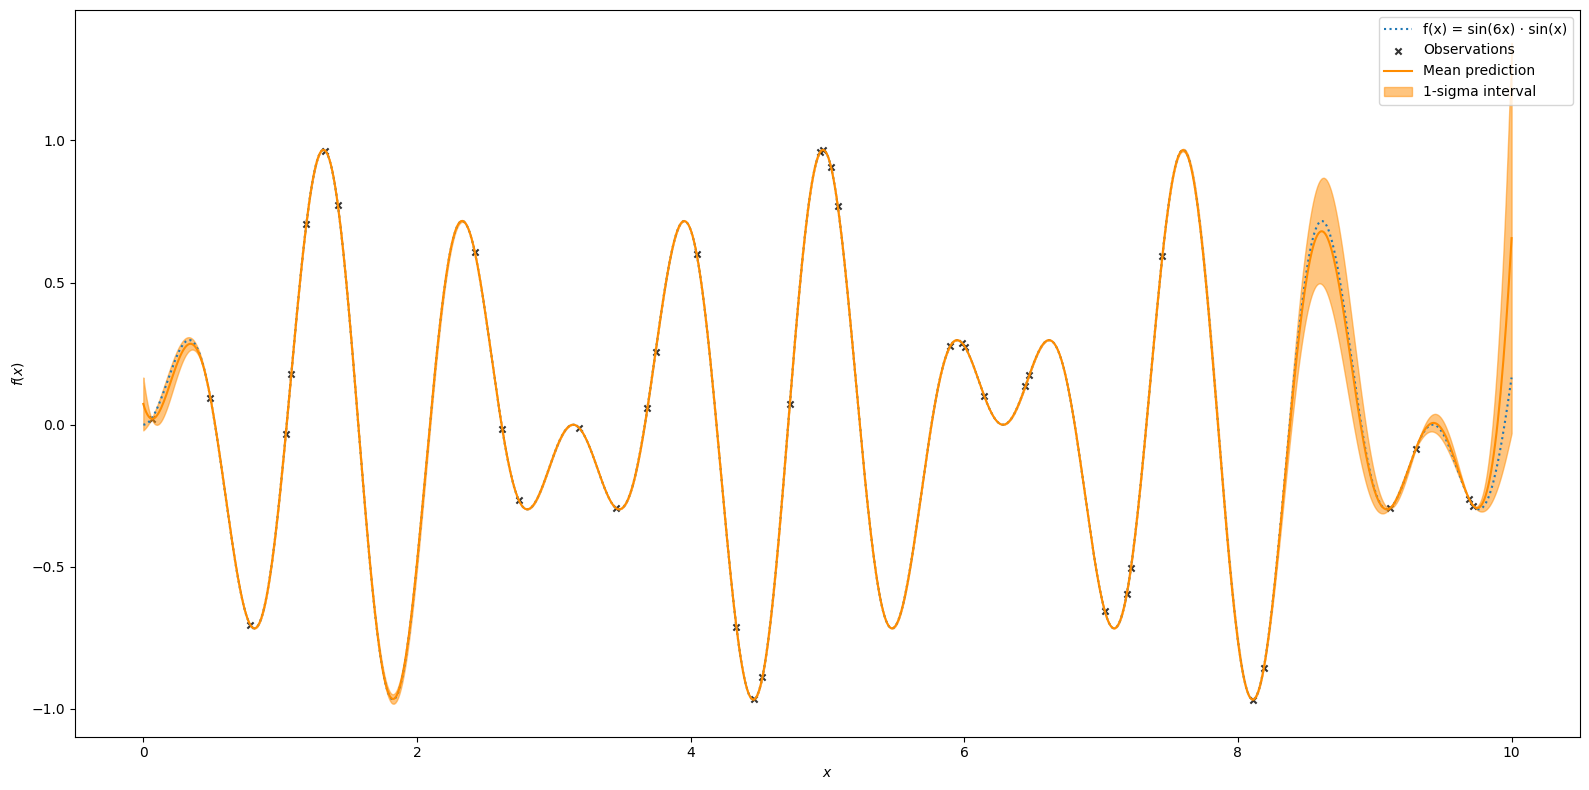


Der resultierende Kernel nach dem GP: 0.873**2 * ExpSineSquared(length_scale=1.45, periodicity=4.73) * 26.1**2 * ExpSineSquared(length_scale=0.000574, periodicity=1.13e+04)



In [ ]:
modsin_kernel_2 = 1**2 * ExpSineSquared(length_scale=1.0) * 1**2 * ExpSineSquared(length_scale=1.0)

Darian.gpr_fit(modsin_kernel_2)
Darian.title = "Darian: GPR auf modulierten Sinus mit doppeltem ESS-Kernel"
Darian.drawfit()
print("\n" + "Der resultierende Kernel nach dem GP: " + str(Darian.gpr_kernel)+ "\n")

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


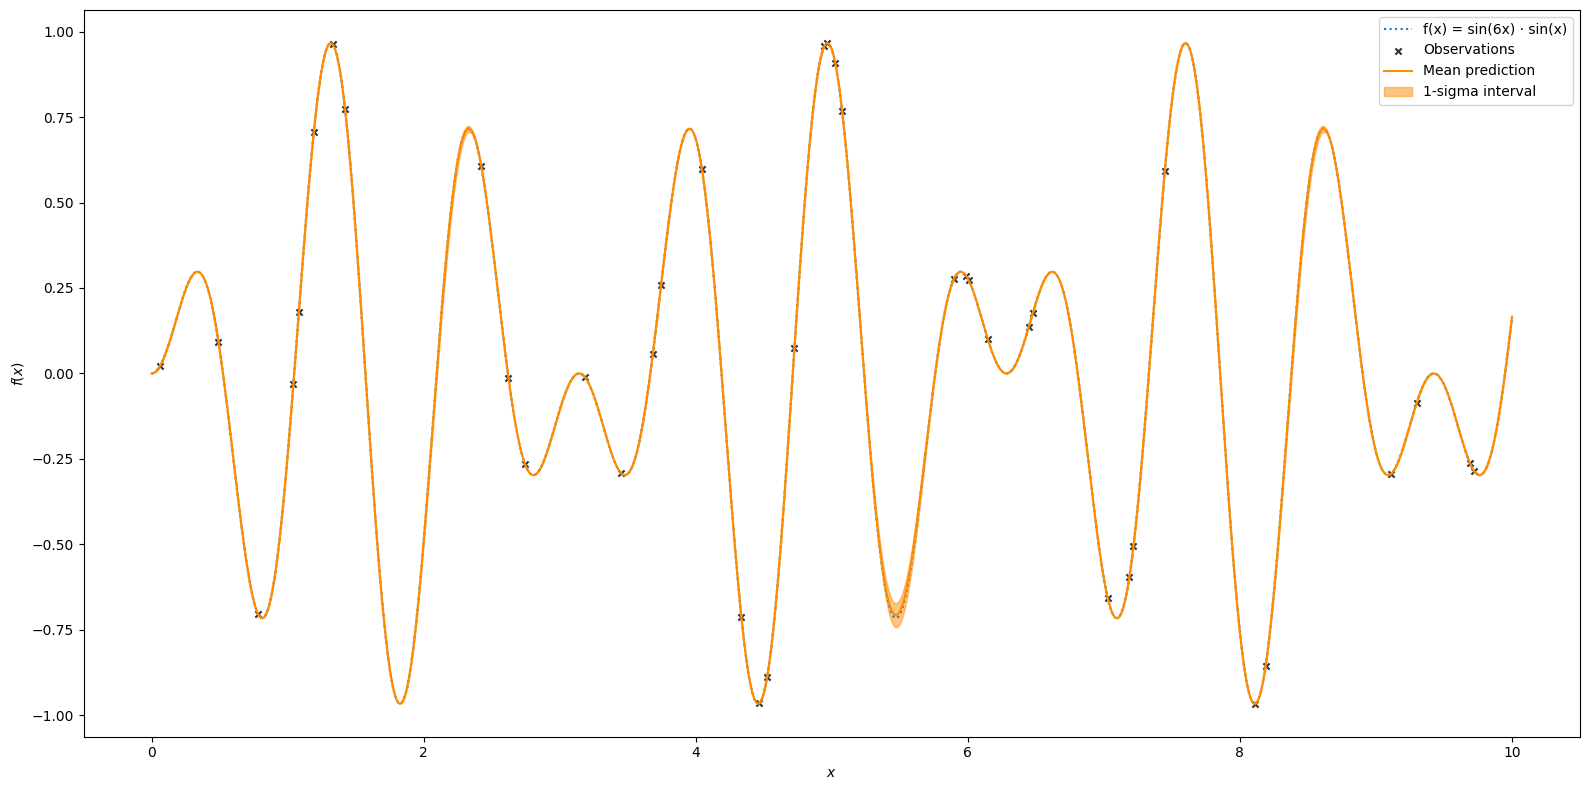


Der resultierende Kernel nach dem GP: 0.717**2 * ExpSineSquared(length_scale=0.331, periodicity=6.28) * 0.717**2 * ExpSineSquared(length_scale=9.13, periodicity=1.26)



In [ ]:
modsin_kernel_3 = 1**2 * ExpSineSquared(length_scale=1.0, periodicity=6) * 1**2 * ExpSineSquared(length_scale=1.0, periodicity=1.0)
Darian.gpr_fit(modsin_kernel_3)
Darian.title = "Darian: GPR auf modulierten Sinus mit doppeltem ESS-Kernel mit vorgegebenen Periodizitäten"
Darian.drawfit()
print("\n" + "Der resultierende Kernel nach dem GP: " + str(Darian.gpr_kernel)+ "\n")

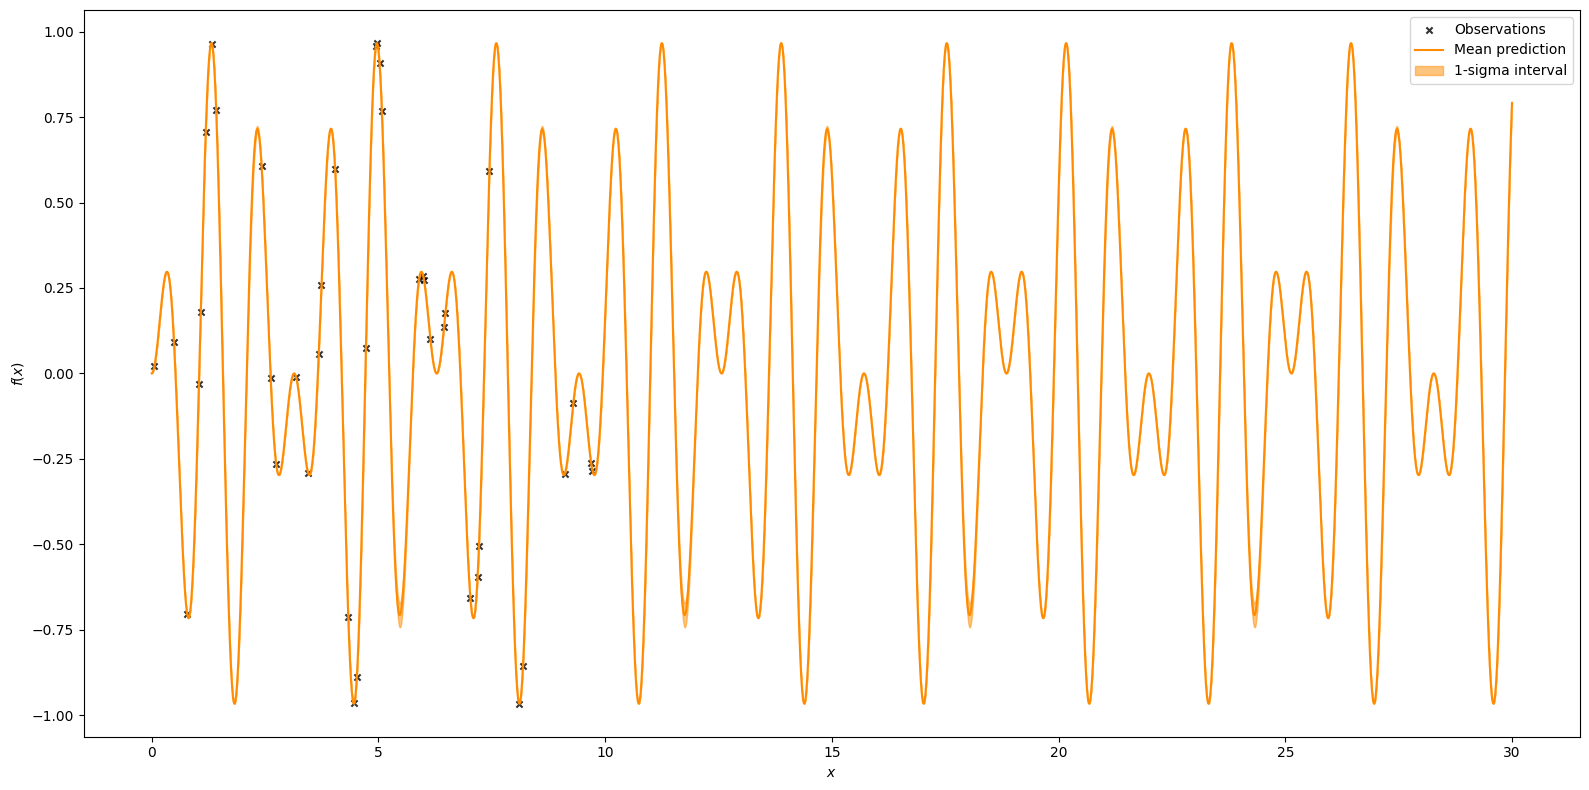


Der resultierende Kernel nach dem GP: 0.717**2 * ExpSineSquared(length_scale=0.331, periodicity=6.28) * 0.717**2 * ExpSineSquared(length_scale=9.13, periodicity=1.26)


In [ ]:
Darian.X = np.linspace(start=0, stop=30, num=3_000).reshape(-1, 1)
Darian.gpr_fit(modsin_kernel_3)
Darian.title = "Darian: GPR-Extrapolation des modulierten Sinus mit doppelten ESS-Kernel mit vorgegebenen Periodizitäten"
Darian.drawfit(optout=True)
print("\n" + "Der resultierende Kernel nach dem GP: " + str(Darian.gpr_kernel))

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


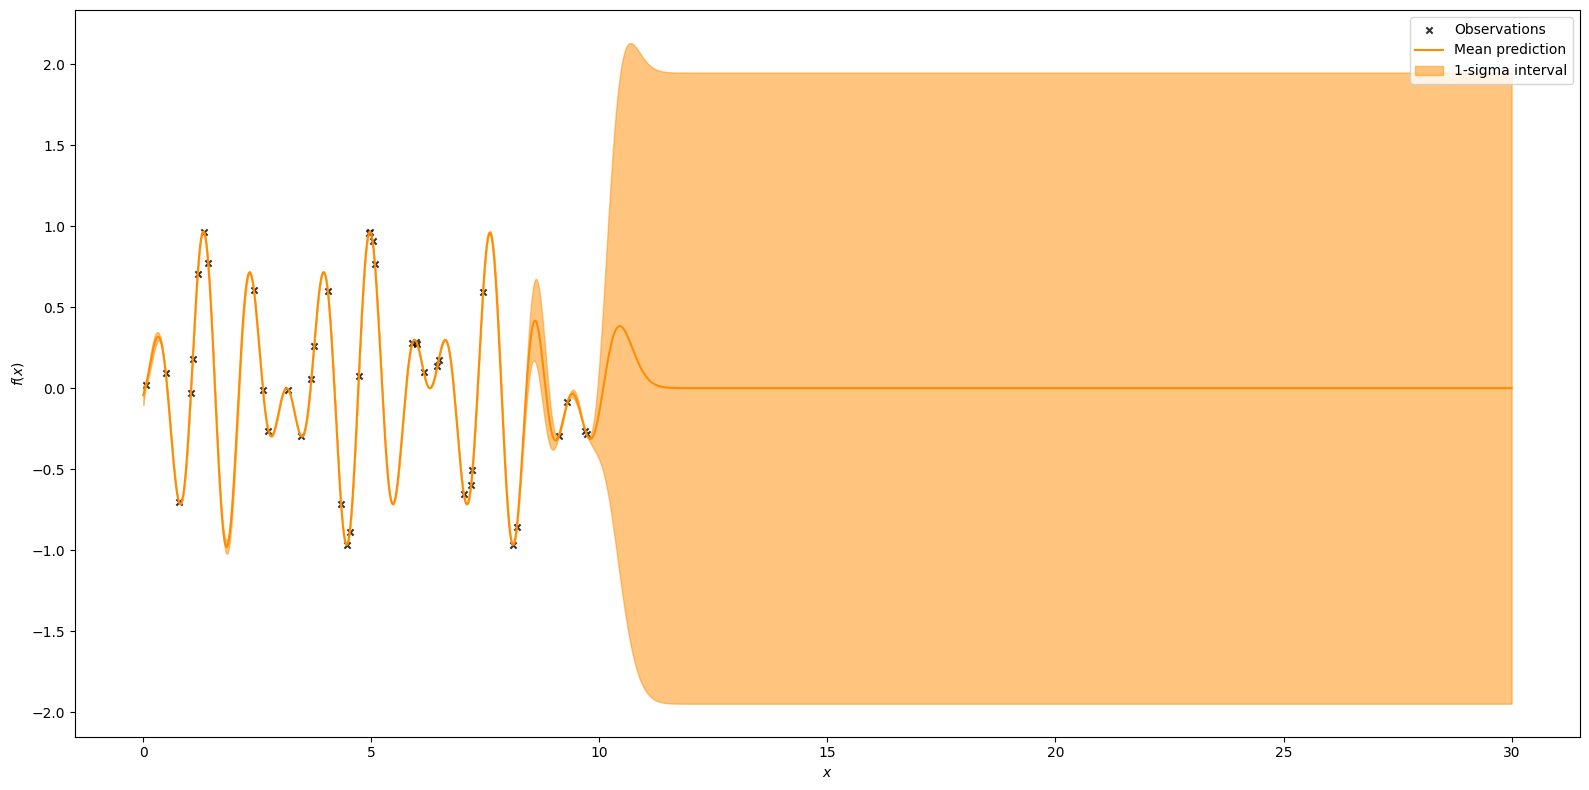


Der resultierende Kernel nach dem GP: 5.52**2 * ExpSineSquared(length_scale=0.00215, periodicity=1.3e+03) * 0.353**2 * ExpSineSquared(length_scale=104, periodicity=16.2)


In [ ]:
Darian.X = np.linspace(start=0, stop=30, num=3_000).reshape(-1, 1)
Darian.gpr_fit(modsin_kernel_2)
Darian.title = "Darian: GPR-Extrapolation des modulierten Sinus mit ungenügenden Kernel"
Darian.drawfit(optout=True)
print("\n" + "Der resultierende Kernel nach dem GP: " + str(Darian.gpr_kernel))

# Experiment 2: CO2 Data Fit


In [ ]:
class CO2DataExperiment(DataAnalyzer):
  '''
  Every Childclass of DataAnalyzer needs a function name and a title for correct plots.
  '''
  def __init__(self, label=None):
    self.X = self.y = self.function_name = self.title = self.X_train = None
    self.co2 = fetch_openml(data_id=41187, as_frame=True).frame
    self.plot_extra=True
    self.label = label

    #data for gpr_prediction:
    self.today = datetime.datetime.now()
    current_month = self.today.year + self.today.month / 12
    self.X_pred = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)

  def displaydata(self):
    print("Das Minimum wurde gemessen am: ", self.co2.index.min())
    print("Das Maximum wurde gemessen am: ", self.co2.index.max())
    return self.co2.head()

  def cut_to_daily(self):
    self.co2["date"] = pd.to_datetime(self.co2[["year", "month", "day"]])
    self.co2 = self.co2[["date", "co2"]].set_index("date")

  def rebin(self):
    self.co2 = self.co2.resample("M").mean().dropna(axis="index", how="any")
    self.X = (self.co2.index.year + self.co2.index.month / 12).to_numpy().reshape(-1, 1)
    self.y = self.co2["co2"].to_numpy()

  def extend_to_today(self):
    self.X = self.X_pred

  def set_train(self):
    self.X_train = self.X
    self.y_train = self.y

  def plot_extra(self):
    plt.plot(self.X_train, self.y_train, 'C0', alpha=0.8, label="Training Points", linestyle="dotted")


## `Eira`-Experiment

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


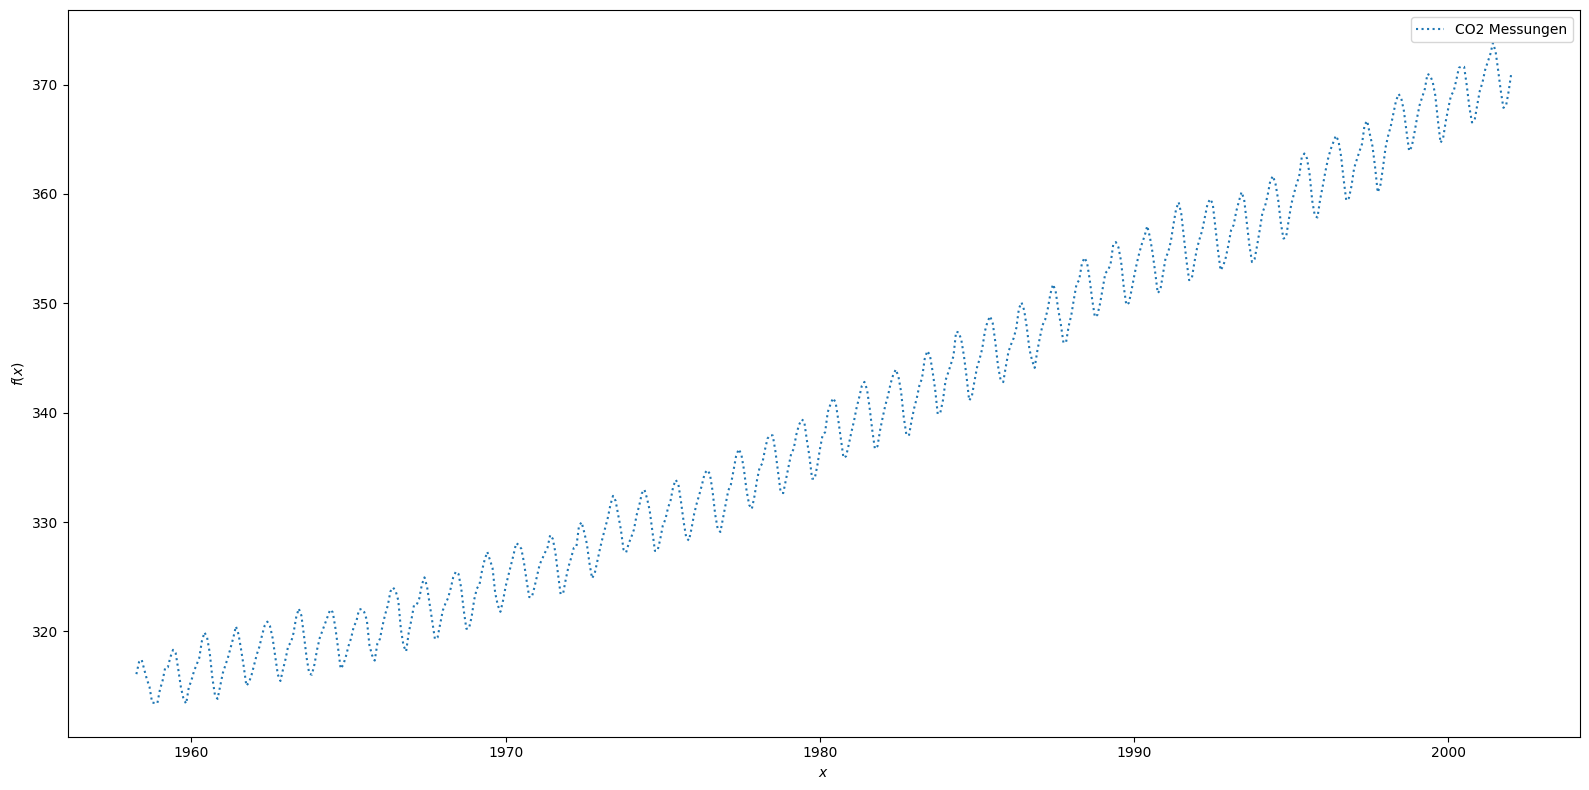

In [ ]:
Eira = CO2DataExperiment()
#Eira.displaydata() #verbose for data transformation-visualization
Eira.cut_to_daily()
#Eira.displaydata() #verbose for data transformation-visualization
Eira.rebin()
#Eira.displaydata() #verbose for data transformation-visualization
Eira.title="Eira: Rohdaten der CO2-Messungen von 1958 bis 2001"
Eira.label="CO2 Messungen"
Eira.draw()

In [ ]:
long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (2.0**2*RBF(length_scale=100.0) * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed"))
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))

co2_kernel = (long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel)

In [ ]:
Eira.set_train()
Eira.extend_to_today()
Eira.gpr_fit(co2_kernel)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


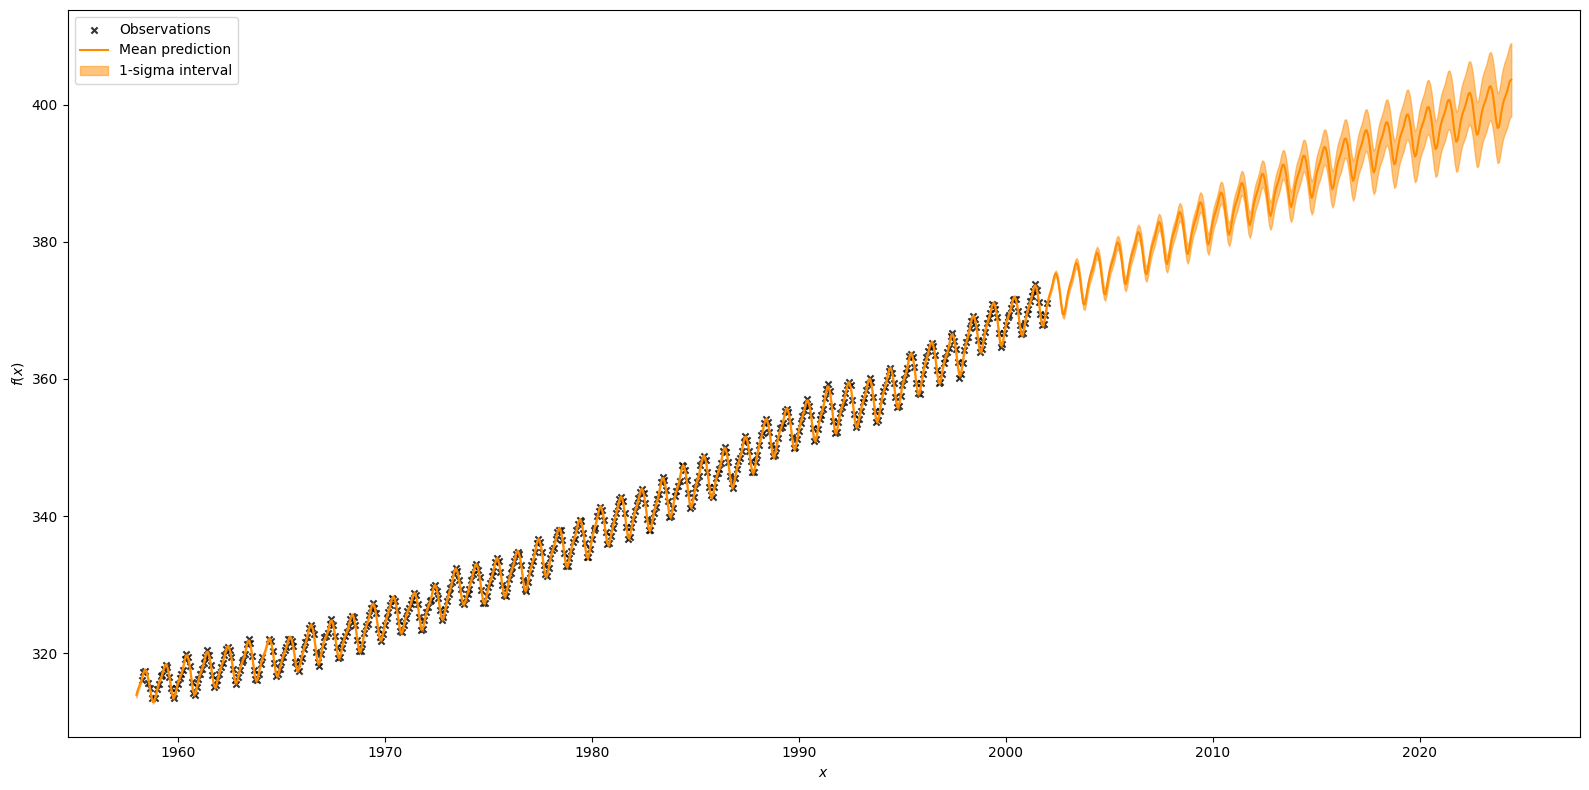

In [ ]:
Eira.title="Eira: GPR-Extrapolation auf CO2 Messungen bis heute"
Eira.drawfit(optout=True)

In [ ]:
print("\n" + "Der resultierende Kernel nach dem GP: \n" + str(Eira.gpr_kernel))


Der resultierende Kernel nach dem GP: 
316**2 * RBF(length_scale=94.1) + 2.64**2 * RBF(length_scale=92.2) * ExpSineSquared(length_scale=1.48, periodicity=1) + 0.553**2 * RationalQuadratic(alpha=1.96, length_scale=0.992) + 0.187**2 * RBF(length_scale=0.121) + WhiteKernel(noise_level=0.0366)


# Experiment 3: Voigt Fit

In [ ]:
class EnhancedAnalyticalExperiment(DataAnalyzer):
  '''
  Every Childclass of DataAnalyzer needs a function name and a title for correct plots.
  '''
  def __init__(self, min=-0.8, max=0.8, count=1000, alpha=0.1, gamma=0.1, testcount=20, seed=1, size=6, densepercentile=0.75, denserange=0.25, noise_std=0.075, label=None):
    self.alpha = alpha
    self.gamma = gamma

    self.count = count
    self.testcount = testcount
    self.size = size  # for random points method
    self.seed = seed  # for random points method
    self.densepercentile = densepercentile  # for yspaced method
    self.denserange = denserange  # for yspaced method
    self.noise_std = noise_std
    self.function_name = self.title = self.yspaced_perc = self.X_train = None

    self.X = np.linspace(min,max,count).reshape(-1,1)
    self.label = label

  def Gauss(self):
    """ Return Gaussian line shape at x with HWHM alpha """
    return np.sqrt(np.log(2) / np.pi) / self.alpha * np.exp(-(self.X / self.alpha)**2 * np.log(2))

  def CLorentz(self):
    """ Return Cauchy-Lorentzian line shape at x with HWHM gamma """
    return self.gamma / np.pi / (self.X**2 + self.gamma**2)

  def Voigt(self):
    """
    Return the Voigt line shape at x with Cauchy-Lorentzian component HWHM gamma and Gaussian component HWHM alpha"""
    self.sigma = self.alpha / np.sqrt(2 * np.log(2))
    return np.real(wofz((self.X + 1j*self.gamma)/self.sigma/np.sqrt(2))) / self.sigma /np.sqrt(2*np.pi)

  def comparisonplot(self):
    self.title = "Vergleich der Gauß-, Cauchy-Lorentz- und Voigt-Verteilungen mit den verwendeten alpha- und gamma-Werten"

    plt.plot(self.X, self.Gauss(), linestyle="dashed", label="Gaussian")
    plt.plot(self.X, self.CLorentz(), linestyle="dashed", label="Cauchy-Lorentzian")
    plt.plot(self.X, self.Voigt(), label="Voigt")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/ZLP Output Graphics/" + self.title + ".png", dpi=300, bbox_inches='tight')
    plt.show()

  def generate(self, data_generator=None):
    if data_generator is None:
        data_generator = self.Voigt  # Voigt() as default
    self.y = np.squeeze(data_generator())

  def randompoints(self, seed=None):
    seed = seed if seed is not None else self.seed # Using the class variable self.seed as the default, but if another seed is provided, we prioritize the given one
    self.rng = np.random.RandomState(seed)
    self.training_indices = self.rng.choice(np.arange(self.y.size), size=self.size, replace=False)
    self.X_train, self.y_train = self.X[self.training_indices], self.y[self.training_indices]
    return self.X_train, self.y_train

  def compareseeds(self, startseed=1,endseed=8):
    # how many seeds to check?
    seeds=[*range(startseed,endseed+1)]
    n = len(seeds)
    div = 4
    linecount = int(n/div) + (n % div>0)

    #calculate testpoints
    self.POINTS=[]
    for seed in seeds:
      u, v= self.randompoints(seed=seed)
      self.POINTS.append([u, v, seed])
    fig, axs = plt.subplots(linecount,div,figsize=(20,linecount * 6))
    for (ax, points) in zip(axs.reshape(-1), self.POINTS):
      self.X_train, self.y_train, thisseed = points                     #unpack testpoints & make title
      title = str(self.size) + "TPs with seed=" + str(thisseed)
      ax.plot(self.X, self.y, label=r"voigt shape", linestyle="dotted") # voigt plot is constant based on X and Y
      ax.scatter(self.X_train, self.y_train, label="Training Points")   # scatterplot depends on seed
      ax.set_xlabel("$x$")
      ax.set_ylabel("$f(x)$")
      ax.set_title(title)
      ax.legend()
    fig.tight_layout()
    fig.savefig("/content/drive/MyDrive/ZLP Output Graphics/" + self.title + ".png", dpi=300, bbox_inches='tight')
    plt.show()

  def xevenlypoints(self, count=None, testcount=None):
    count = count if count is not None else self.count
    testcount = testcount if testcount is not None else self.testcount
    training_indices = np.arange(0,count,int(count/testcount))
    self.X_train, self.y_train = self.X[training_indices], self.y[training_indices]

  def yspaced(self, densepercentile=0.75, denserange=0.25, verbose=False, suppressWarning=False):
    if verbose: print("With given densepercentile of ", densepercentile)
    if verbose: print("With given denserange of ", denserange)

    # Calculate how many points will be required by the dense and diffuse areas
    densepoints = int(self.testcount * densepercentile)
    diffusepoints = int(self.testcount * (1 - densepercentile)/2)

    if verbose: print("densepoints: ", densepoints)
    if verbose: print("diffusepoints: ", diffusepoints)

    # Calculate cut-points between dense and diffuse areas
    lowcut = int(denserange * self.count)
    highcut = int((1 - denserange) * self.count)

    if verbose: print("lowcut: ", lowcut)
    if verbose: print("highcut: ", highcut)

    # Make single arrays for each of the three regions and concatenate them
    lowpoints = np.arange(0, lowcut, int(lowcut / diffusepoints))
    highpoints = np.arange(highcut, self.count, int((self.count - highcut) / diffusepoints))
    midpoints = np.arange(lowcut, highcut, int((highcut - lowcut) / densepoints))

    if verbose: print("lowpoints: ", lowpoints)
    if verbose: print("midpoints: ", midpoints)
    if verbose: print("highpoints: ", highpoints)

    testpoints = np.concatenate((lowpoints, midpoints, highpoints))

    if verbose: print("from the target value of ", self.testcount, " testpoints, ", np.size(testpoints), " were actually generated.")

    # Warning Message because more than 50% of training points didn't actually generate
    if np.size(testpoints) / self.testcount * 100 < 50 and not suppressWarning:
        print('─' * 100, "\n", '\033[1m' + 'Warning!' + '\033[0m',
              "only ", np.size(testpoints) / self.testcount * 100,
              "% target testpoint count were actually generated. This is probably a result of too narrow ranges",
              "\n", '─' * 100, "\n")

    self.yspaced_perc = np.size(testpoints) / self.testcount
    if verbose: print("overwrote the global yspaced_perc to ", self.yspaced_perc)

    # Use X and Y (previously computed) to get data points from chosen indices:
    self.X_train, self.y_train = self.X[testpoints], self.y[testpoints]
    return self.X_train, self.y_train

  def yspaced_optimizer(self, verbose=False, suppressWarning=True):
    self.yspaced_perc = 1.0
    for _ in range(5):
        self.X_train, self.y_train = self.yspaced(verbose=verbose, suppressWarning=suppressWarning)
        #set a new fake testcount to steer the generation of testpoints towards the desired testcount
        self.testcount = (-(-20 // self.yspaced_perc)) # the value set here should be the desired testcount which can no longer be called because it is already modified
        if verbose: print("new testcount value: " + str(self.testcount) + "\n")

  def behead(self, cut_perc = 0.11):
    sorted_index_array = np.argsort(self.y_train)
    sorted_array = self.y_train[sorted_index_array]
    rslt = sorted_array[-int(cut_perc*np.shape(self.y_train)[0])]
    X_train_cut = [] #muss nacher umgewandelt werden
    y_train_cut = [] #same
    for x, y in zip(self.X_train,self.y_train):
      if y < rslt:
        X_train_cut.append(x)
        y_train_cut.append(y)
    print("Data Points pre cut: ", len(self.y_train))
    print("Data Points after cut: ", len(y_train_cut))
    self.X_train = X_train_cut
    self.y_train = y_train_cut

  def noisify(self, noise_std = 0.75, noise_type='poisson', seed=1):
    '''
    decide wether gaussian or poisson noise should be generated
    for gaussian just use noise_std as level and generate noise
    for poisson generate noise_level using the training amplitudes
    finally in both cases add noise to the data and call it the new data
    '''
    self.rng = np.random.RandomState(seed)
    if noise_type == 'gaussian':
      noise = self.rng.normal(0, noise_std,self.y_train.shape)
    elif noise_type == 'poisson':
      noise_level = np.sqrt(self.y_train)
      noise = self.rng.normal(0, noise_level/4) # rng.normal takes standard deviation as argument which is approximated here as a quarter of the noise-range
    self.y_train = self.y_train + noise

## `Farren`-Experiment


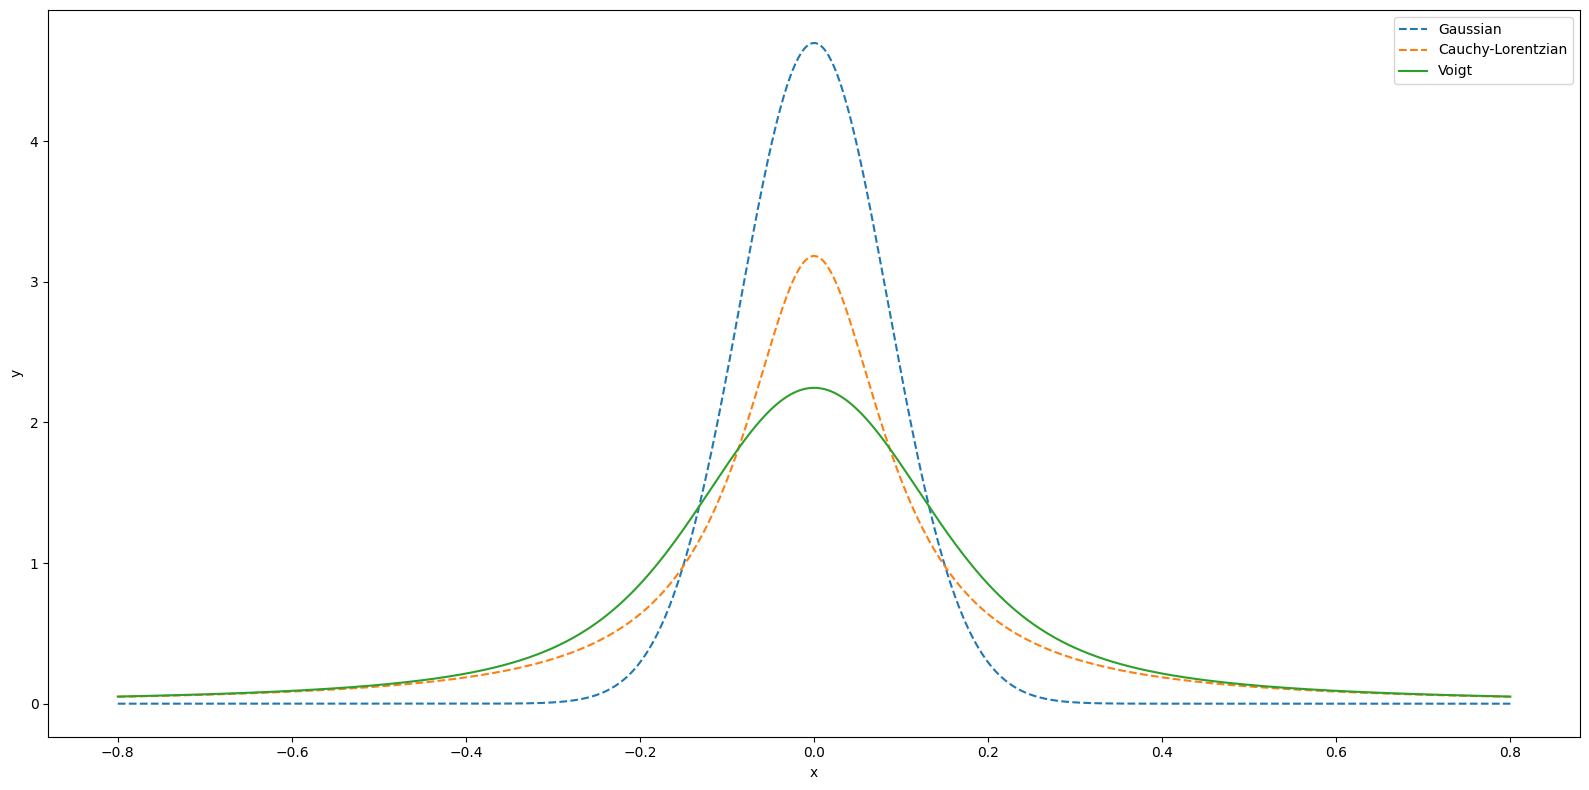

In [ ]:
Farren = EnhancedAnalyticalExperiment()
Farren.comparisonplot()

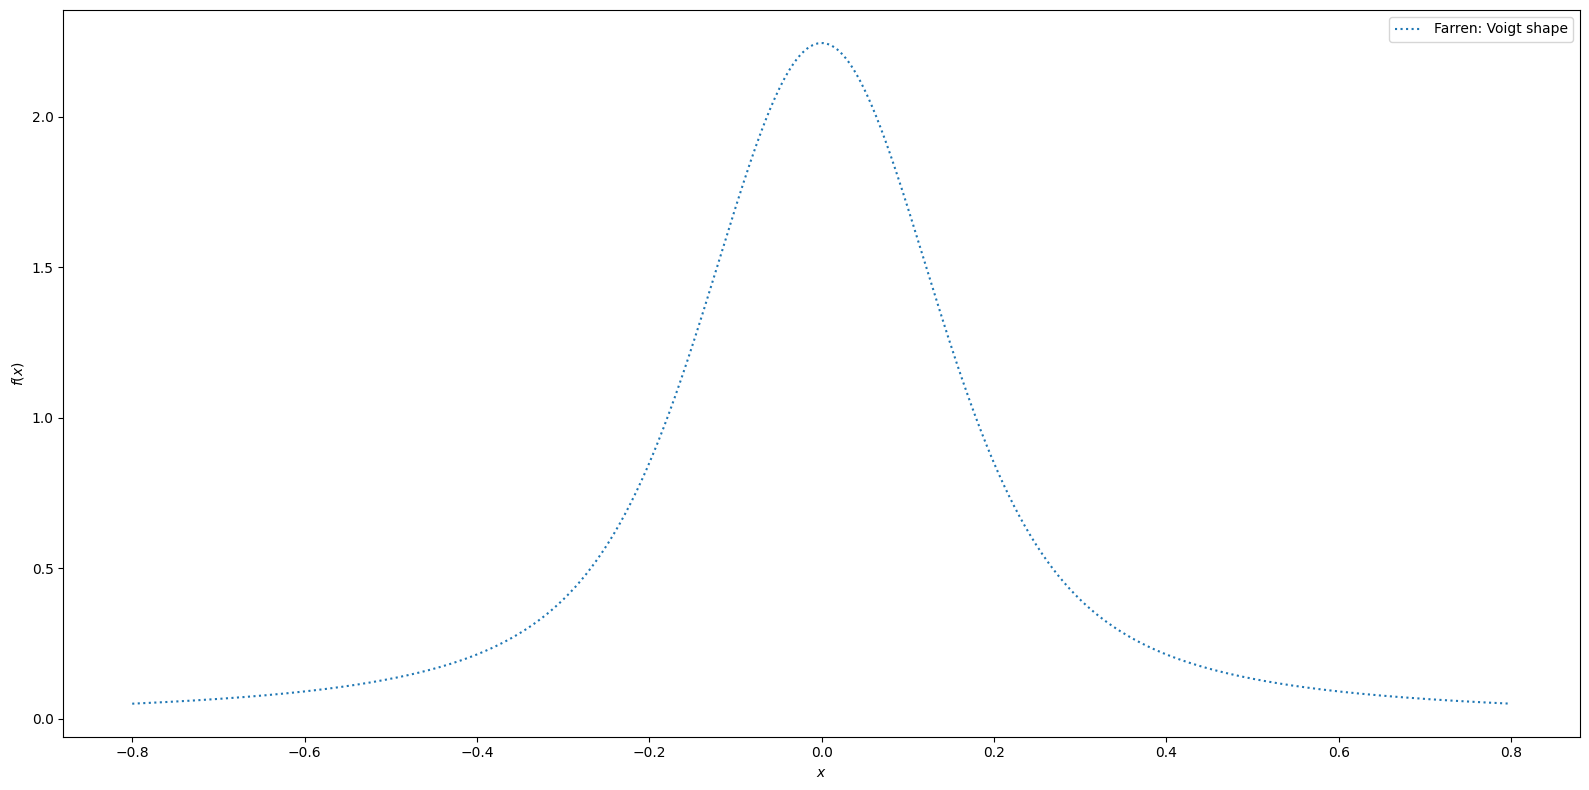

In [ ]:
Farren.generate(Farren.Voigt)
Farren.label=r'Farren: Voigt shape'
Farren.title=r'Farren: Voigt shape'
Farren.draw()

### Trainingsdaten: Zufällig

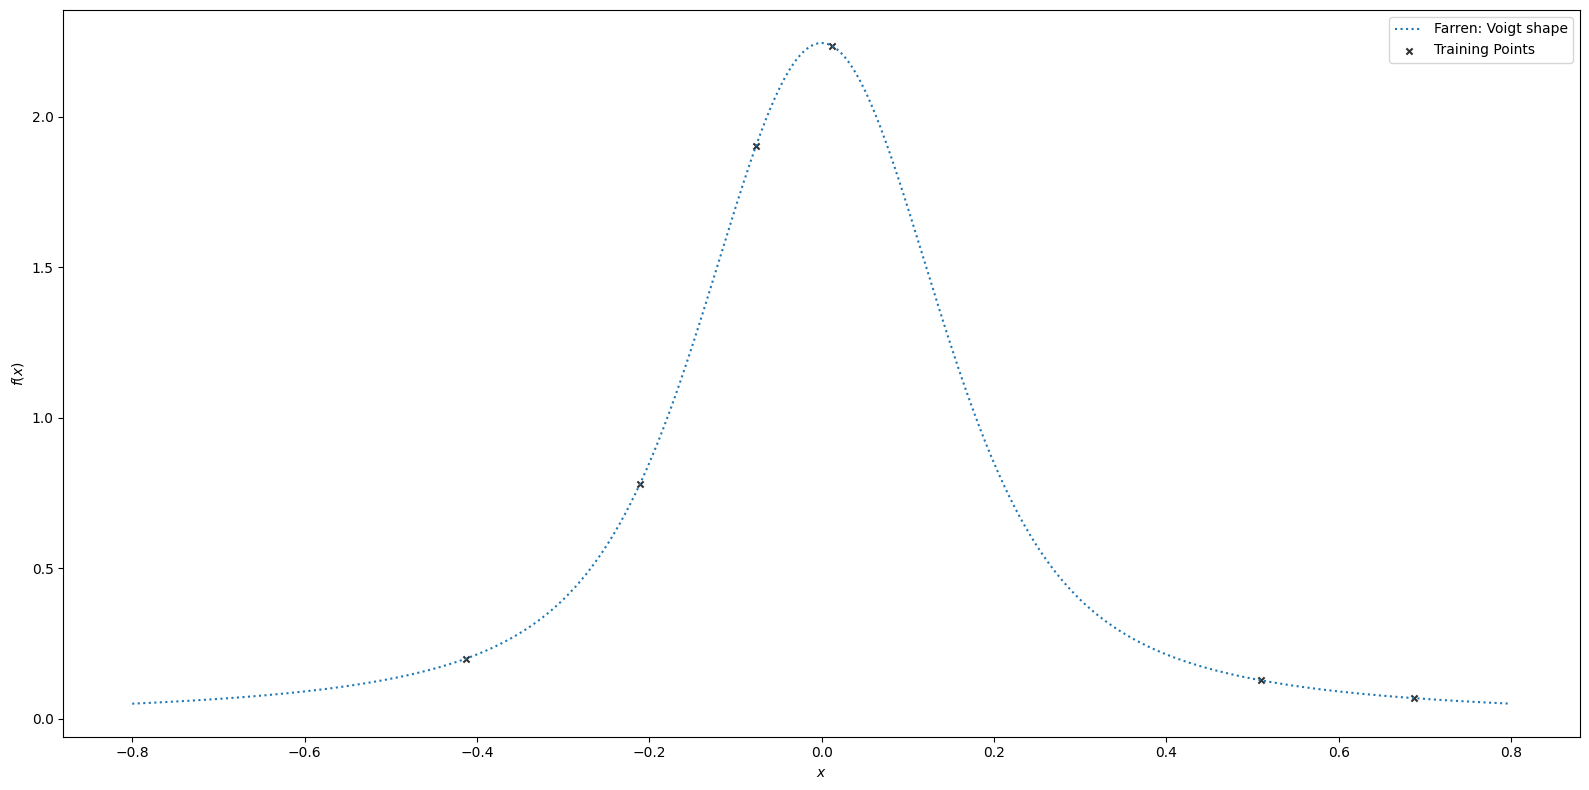

In [ ]:
Farren.randompoints()
Farren.title=r'Farren: Voigt Verteilung mit Trainingspunkten nach seed=1'
Farren.draw()

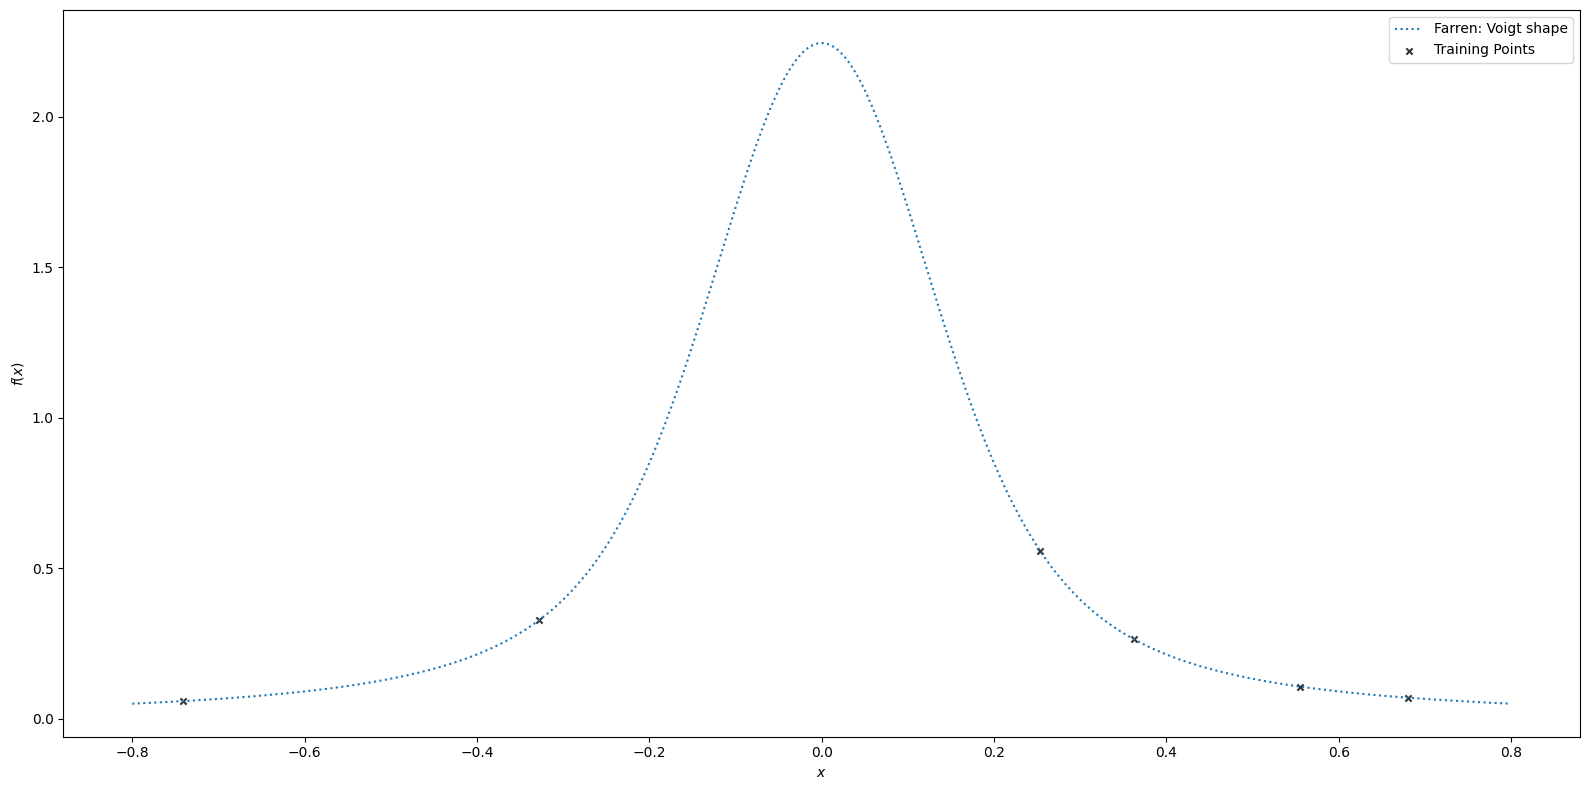

In [ ]:
Farren.randompoints(seed=2)
Farren.title=r'Farren: Voigt Verteilung mit Trainingspunkten nach seed=2'
Farren.draw()

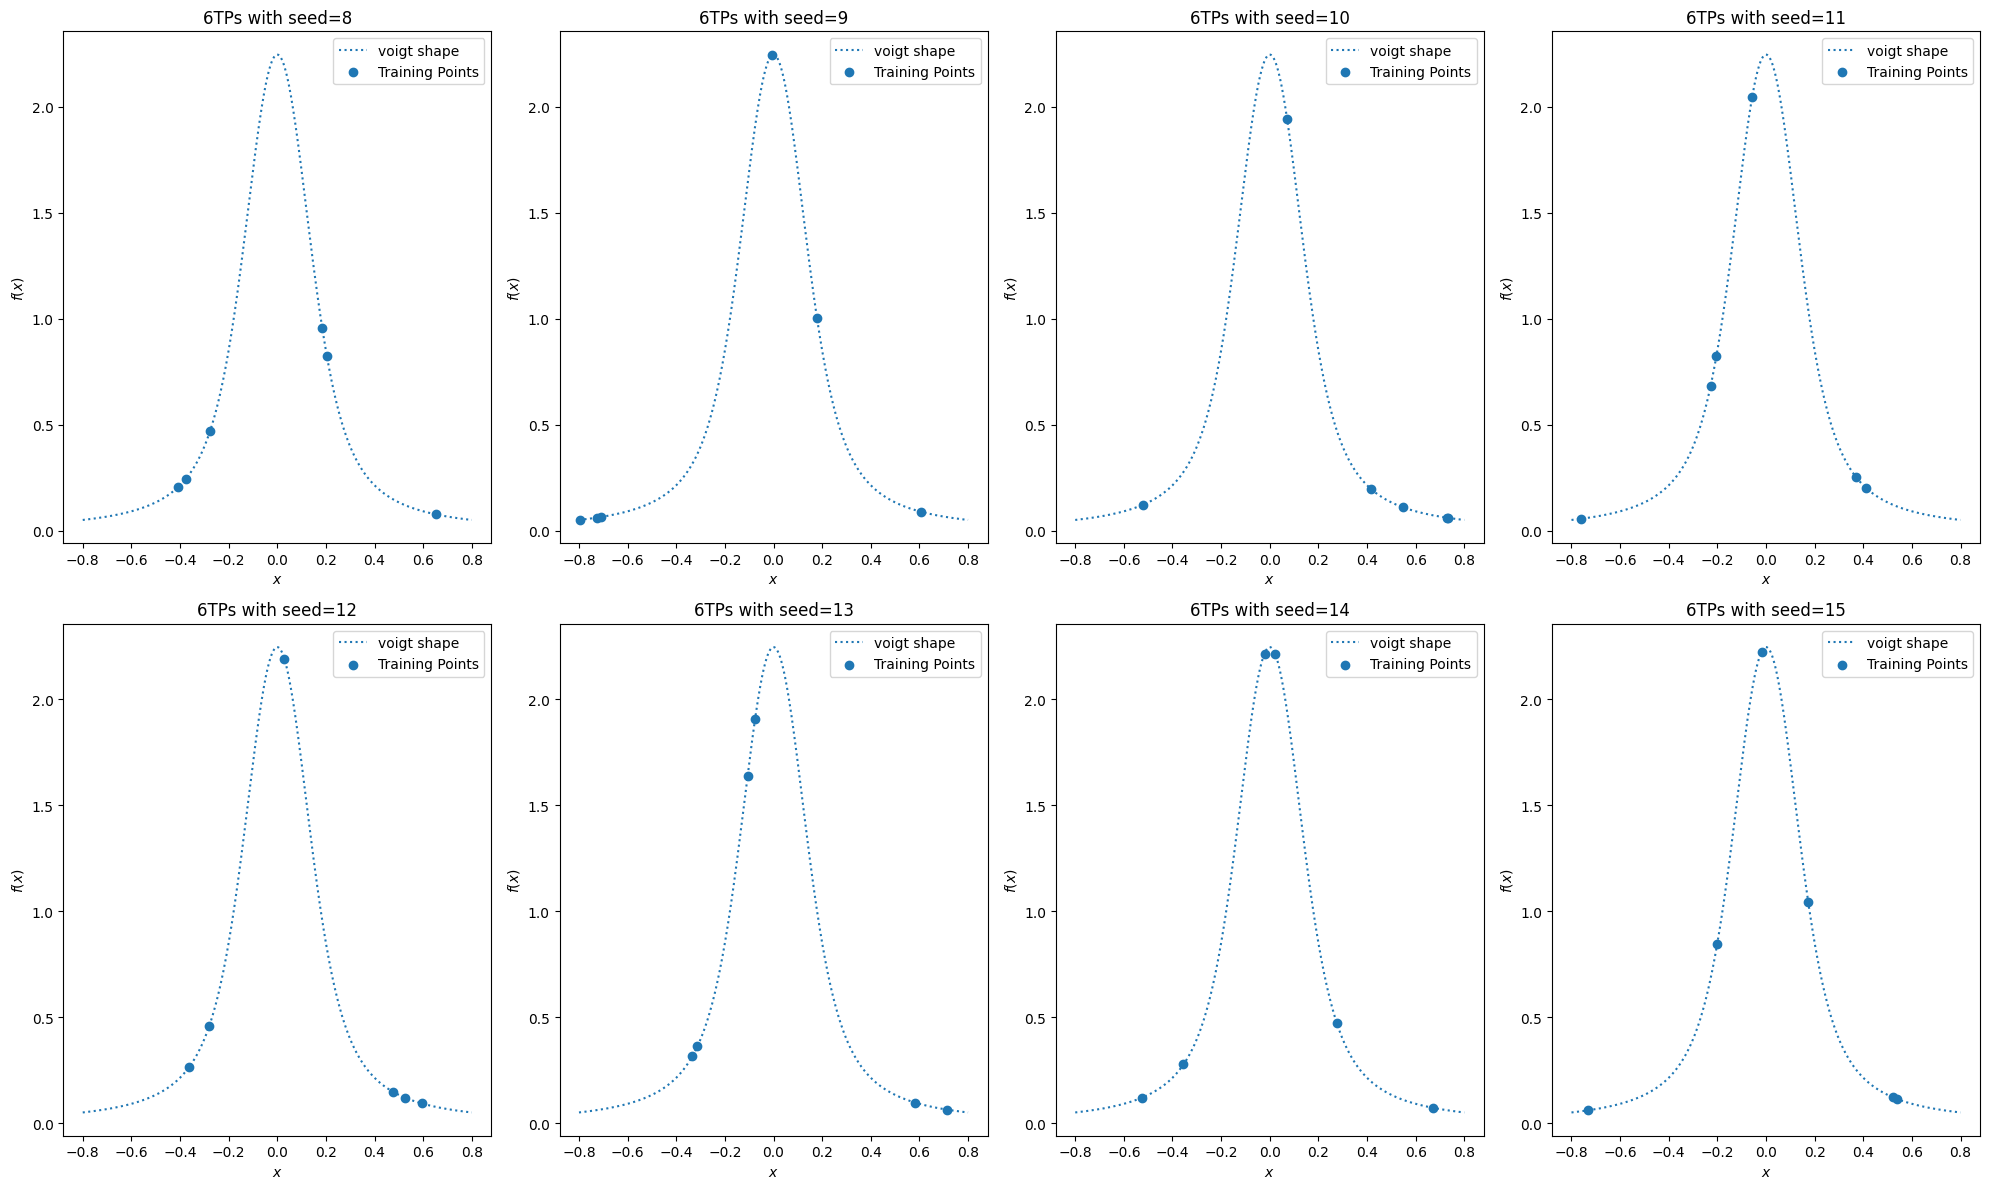

In [ ]:
Farren.title=r'Farren: vergleiche Seeds für zufällige Trainingspunkte,8-15'
Farren.compareseeds(8, 15)

### Trainingsdaten: x-Gleichmäßig verteilt

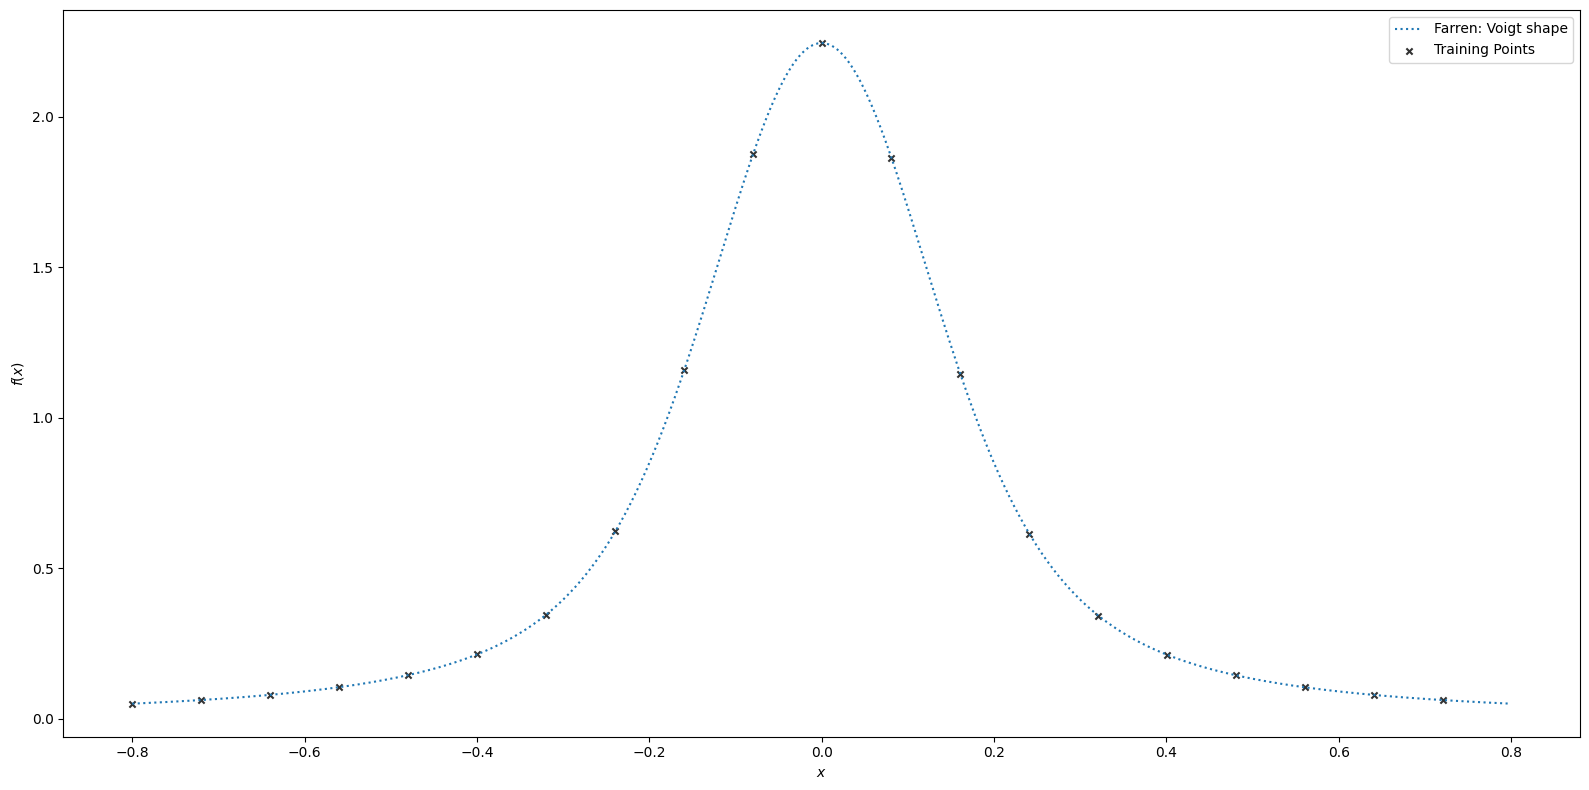

In [ ]:
Farren.xevenlypoints(testcount=20)
Farren.title=r'Farren: xevenlypoints'
Farren.draw()

### Trainingsdaten: y-Gleichmäßig verteilt

With given densepercentile of  0.75
With given denserange of  0.25
densepoints:  15
diffusepoints:  2
lowcut:  250
highcut:  750
lowpoints:  [  0 125]
midpoints:  [250 283 316 349 382 415 448 481 514 547 580 613 646 679 712 745]
highpoints:  [750 875]
from the target value of  20  testpoints,  20  were actually generated.
overwrote the global yspaced_perc to  1.0


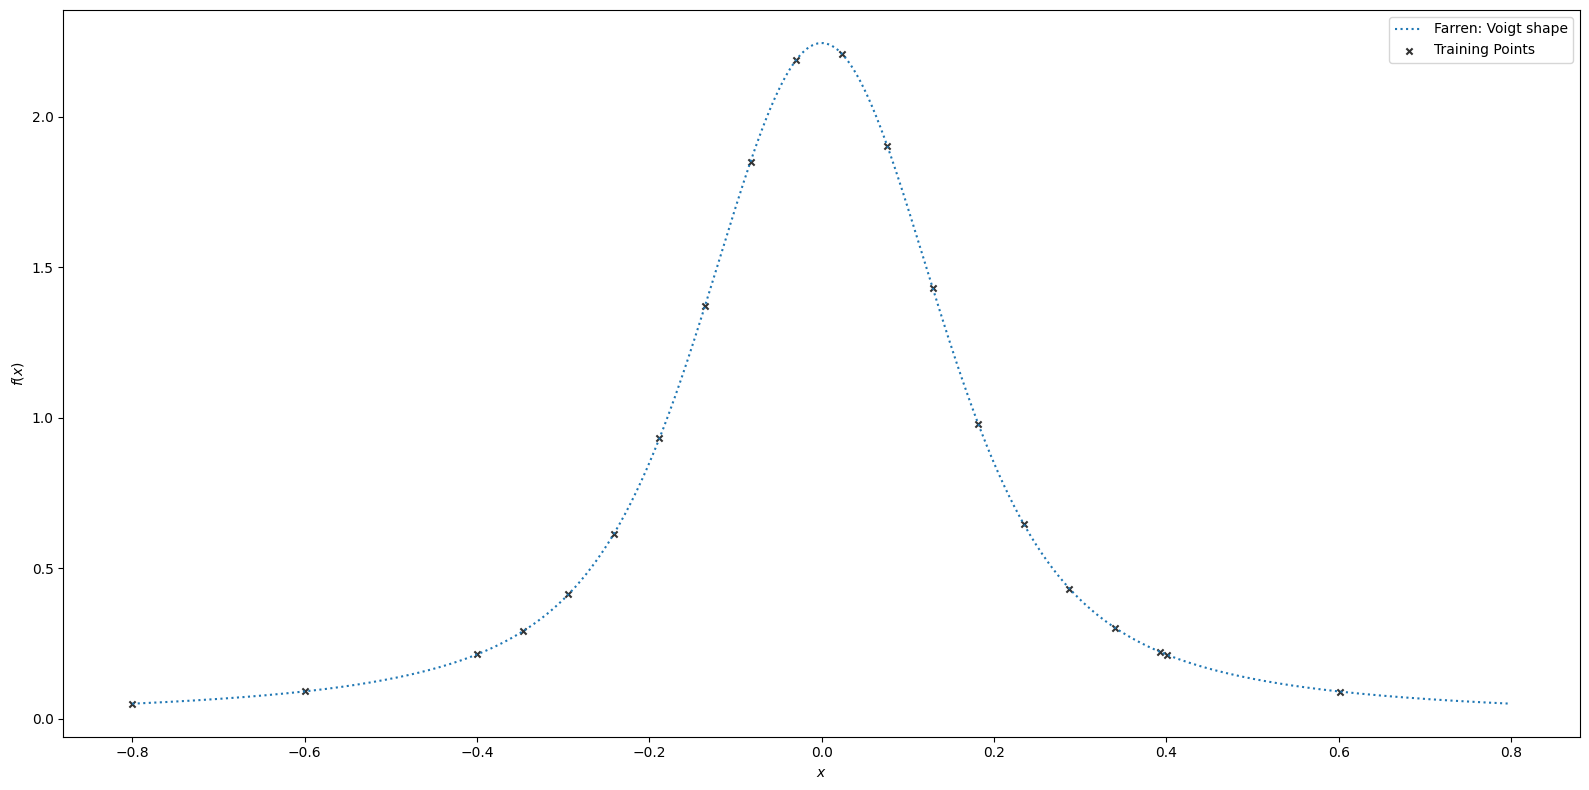

In [ ]:
Farren.yspaced(verbose=True, suppressWarning=False)
Farren.title=r'Farren: yspaced'
Farren.draw()

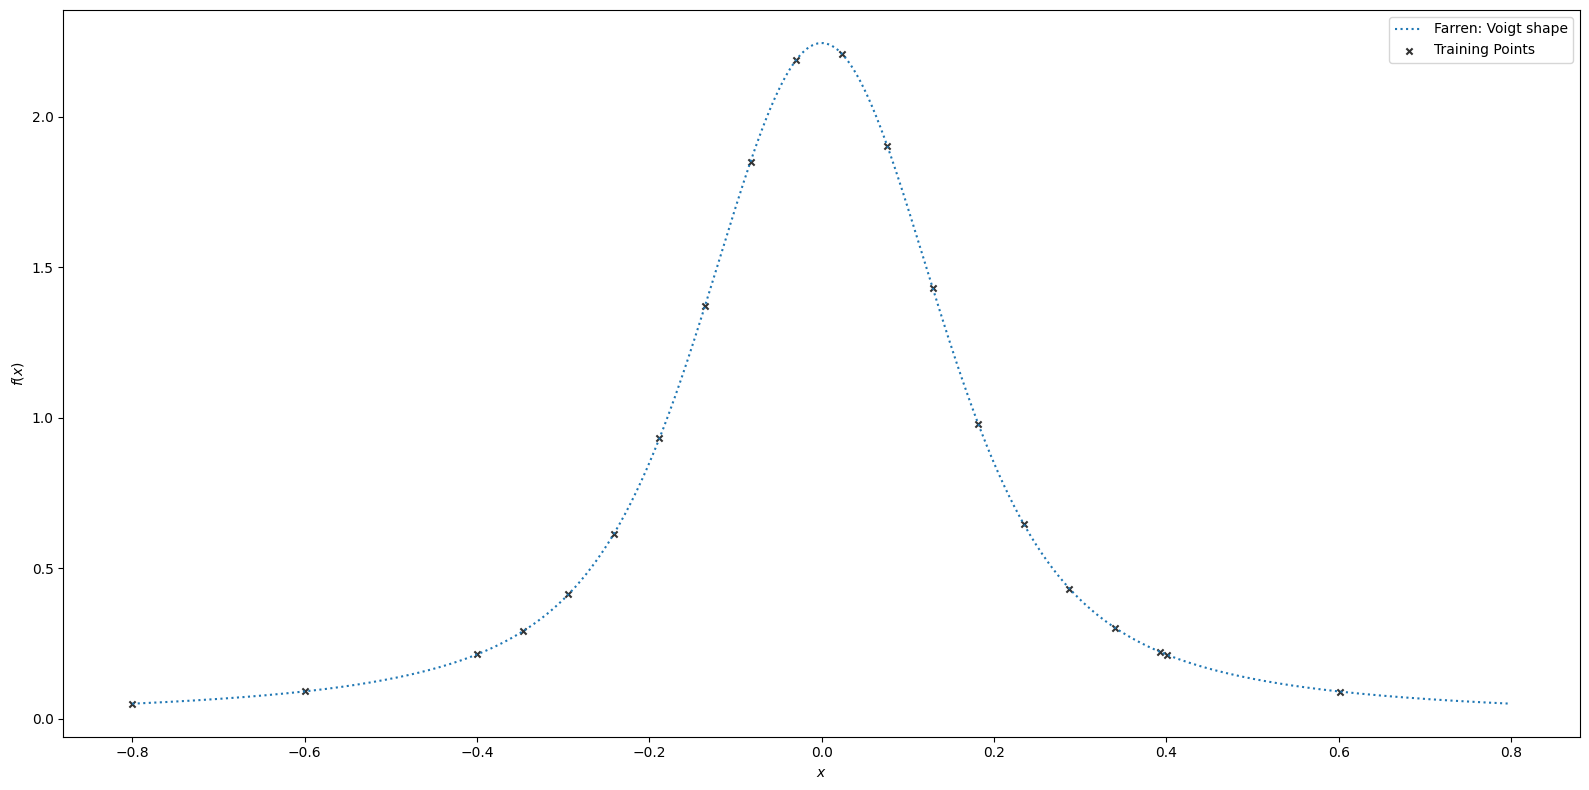

In [ ]:
Farren.yspaced_optimizer()
Farren.title=r'Farren: yspaced_optimized'
Farren.draw()

## Enthauptung

Data Points pre cut:  20
Data Points after cut:  18


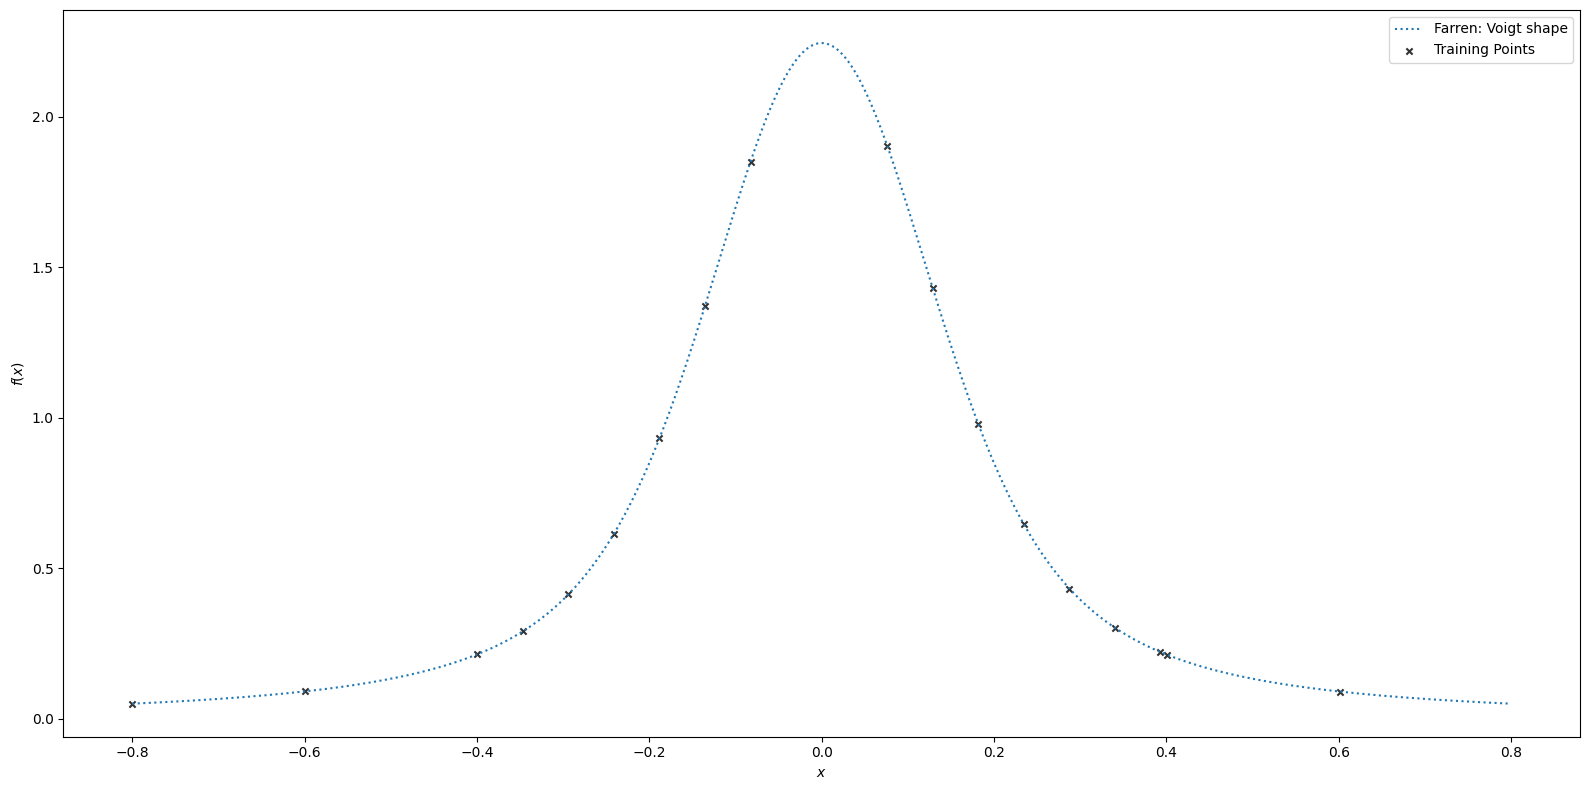

In [ ]:
#Farren.draw()
Farren.behead()
Farren.title=r'Farren: arren'
Farren.draw()

## GPR-Fit

### `Geraint`-Experiment

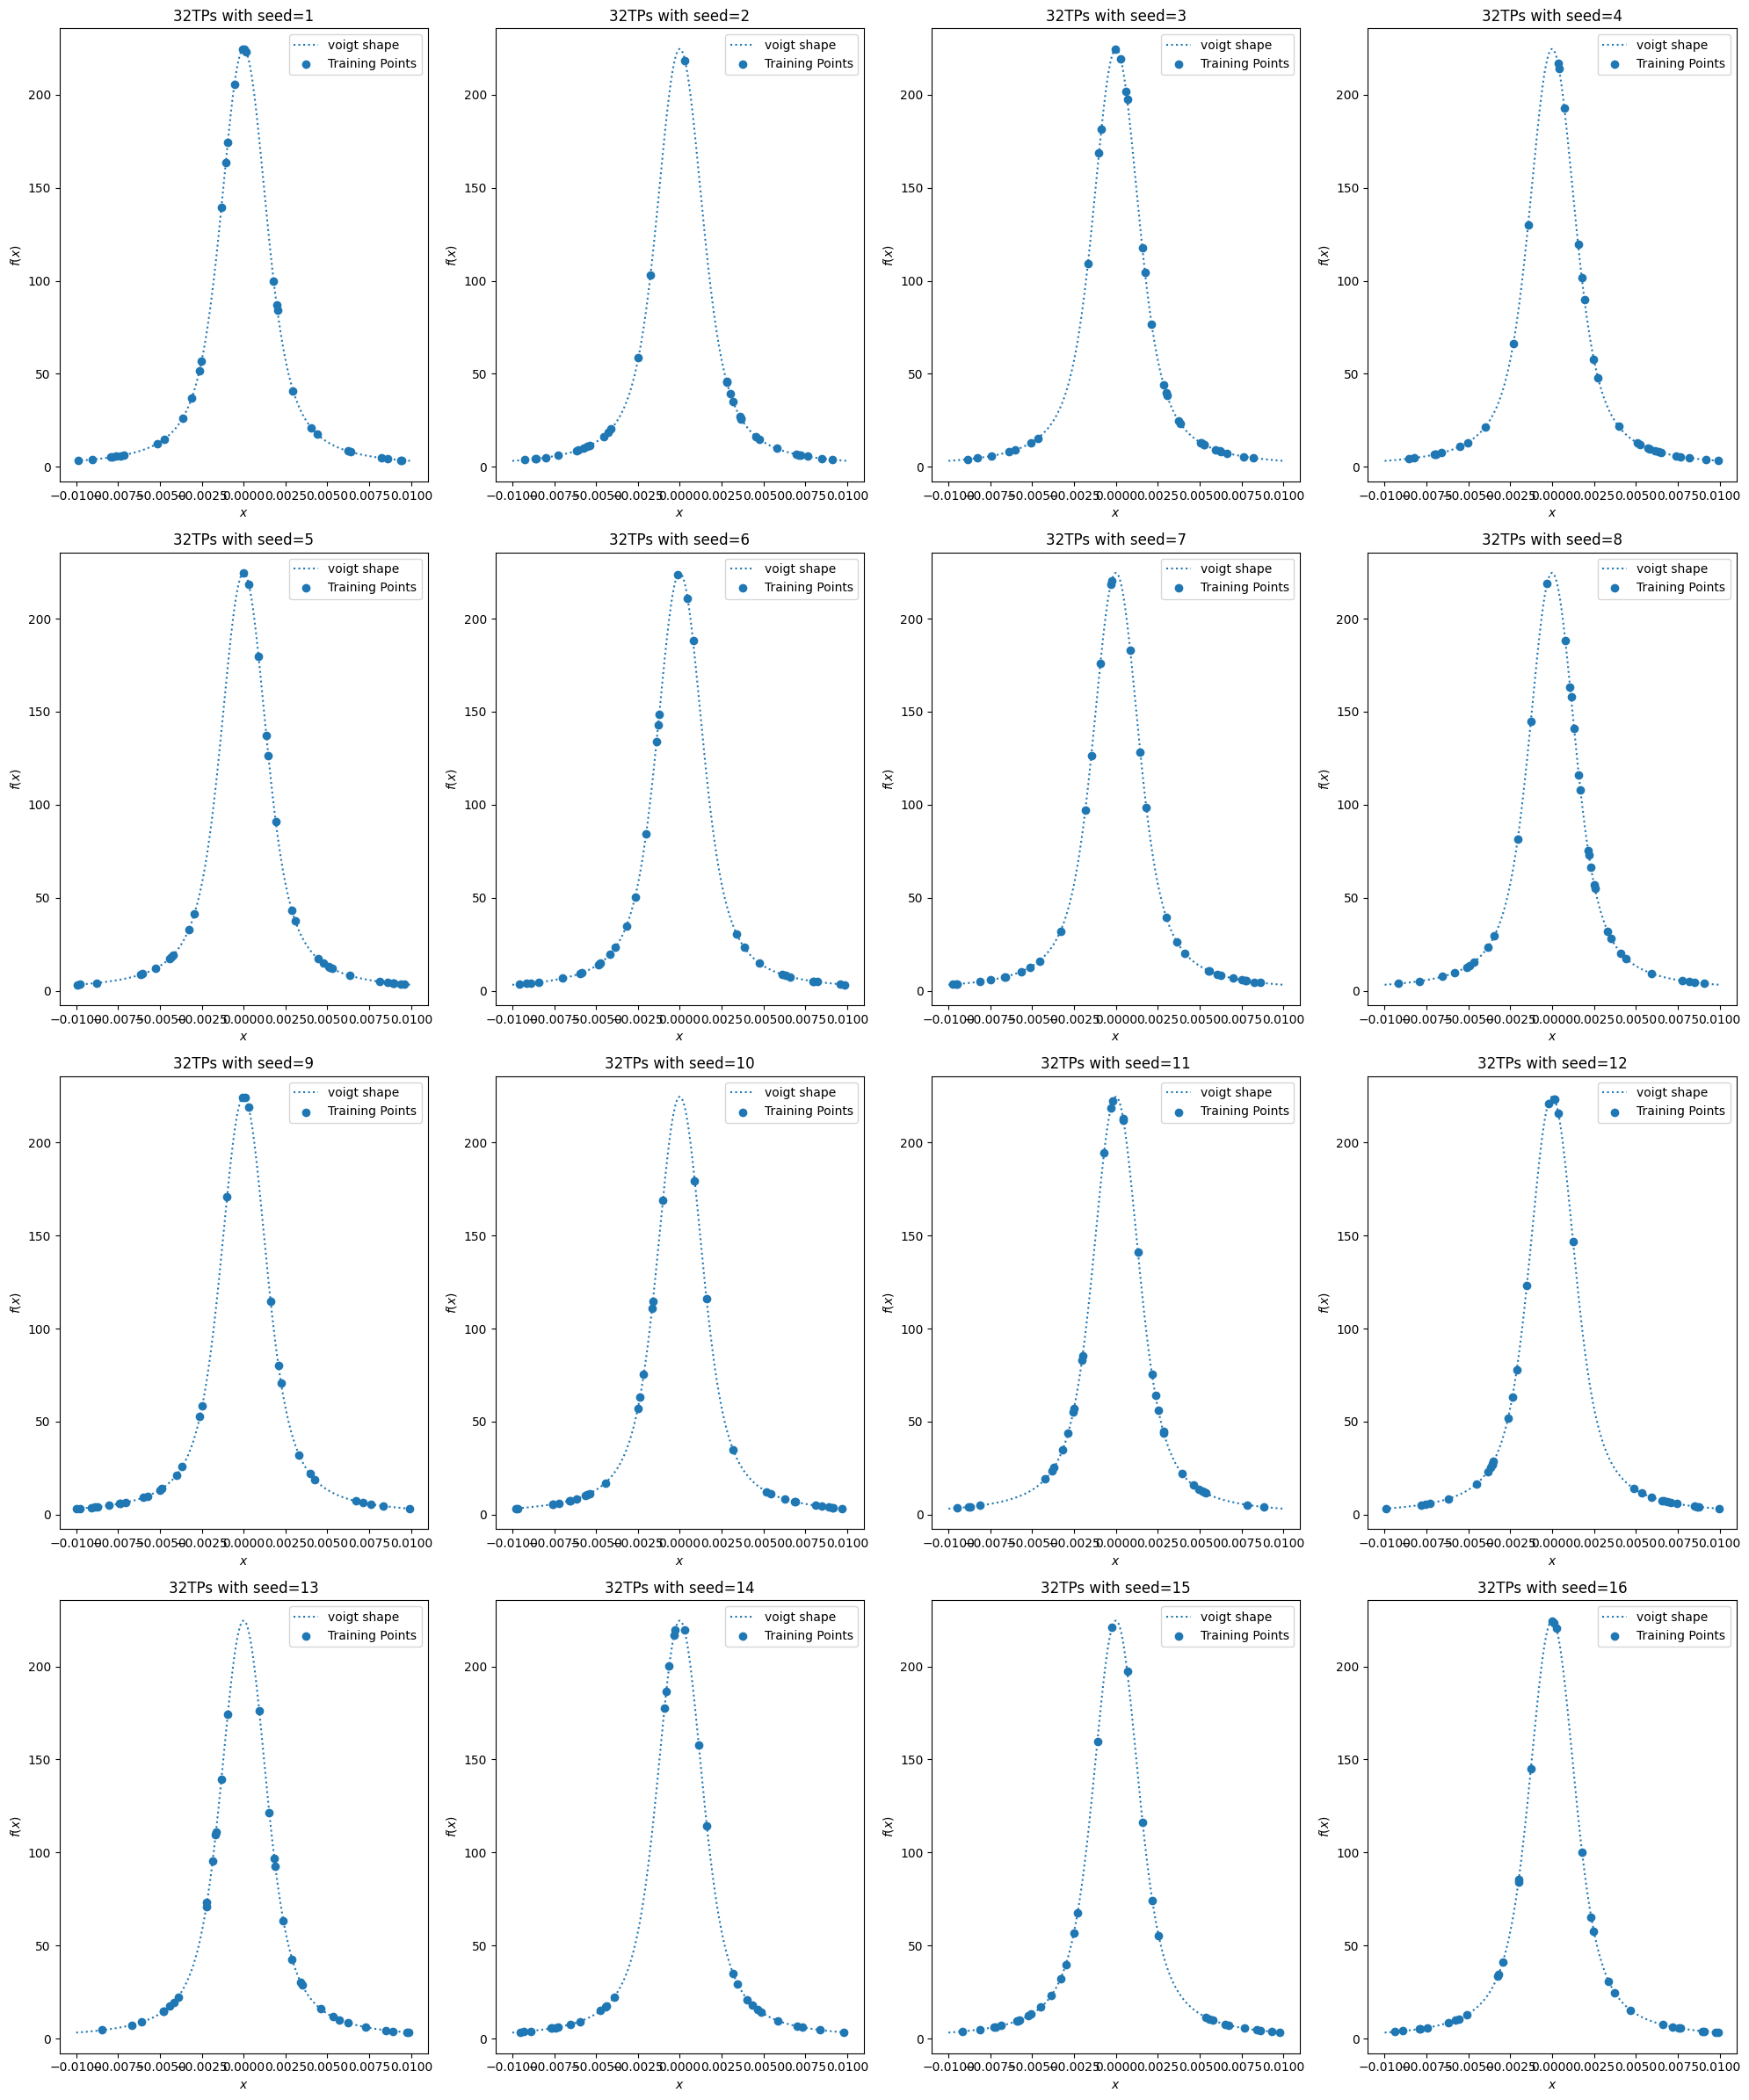

In [ ]:
Geraint = EnhancedAnalyticalExperiment(min = -0.01, max = 0.01, alpha= 0.001, gamma= 0.001, size=32)
Geraint.generate()
#Geraint.draw()
Geraint.title=r'Geraint: vergleiche Seeds fuer zufaellige Trainingspunkte, 1-16'
Geraint.compareseeds(1,16)

In [ ]:
k_rbf = 1**2 * RBF(length_scale=100.0, length_scale_bounds=(1e-5, 1e20)) # default bounds = (1e-5, 1e5)
k_rq = 1**2 * RationalQuadratic(length_scale=1.0, alpha=1, length_scale_bounds=(1e-05, 1e20), alpha_bounds=(1e-05, 1e10))
k_m = 1**2 * Matern(length_scale=1.0,nu=2.5)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


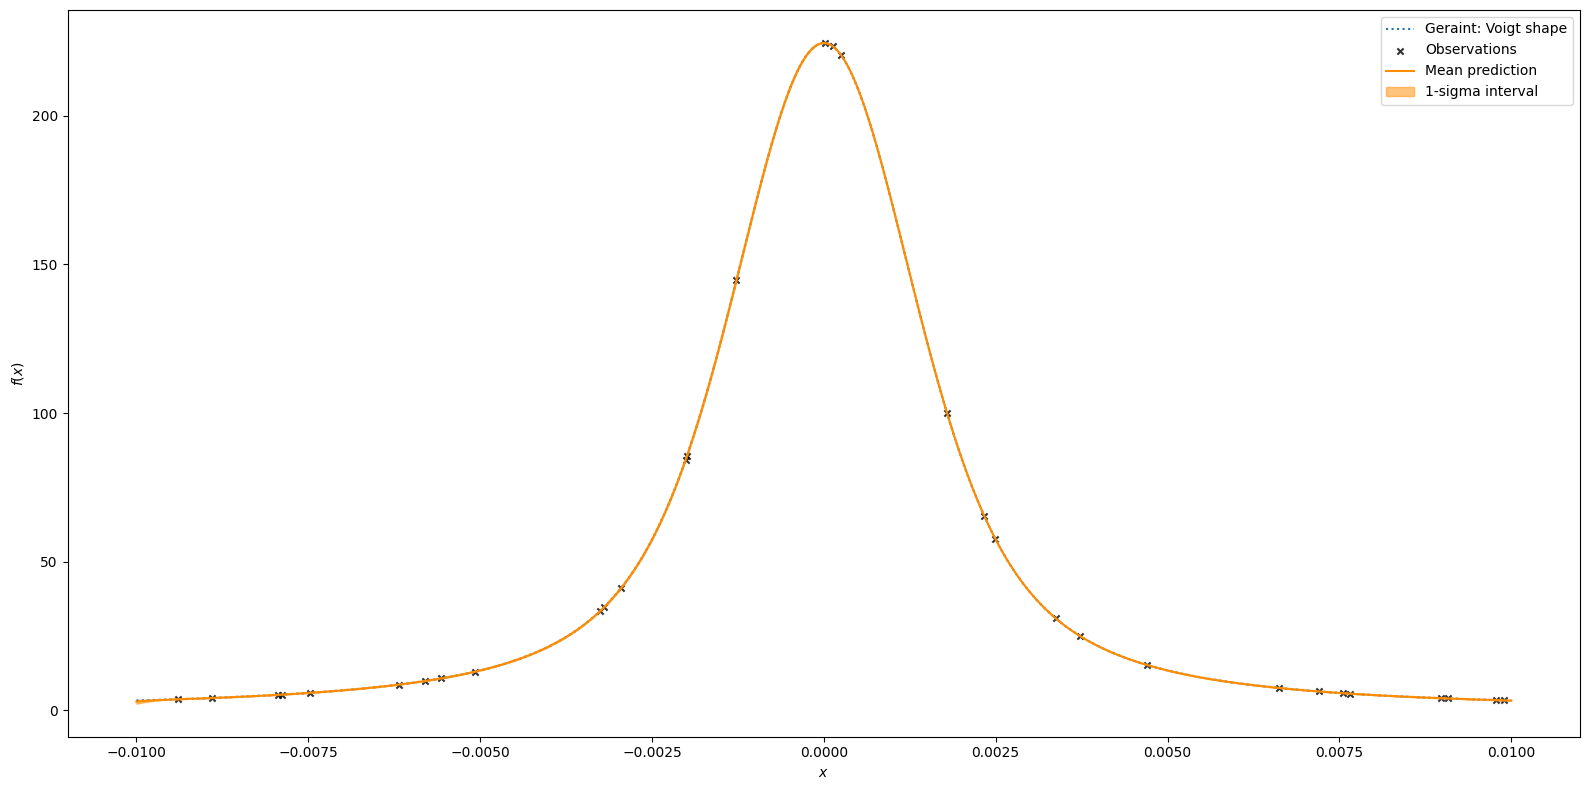

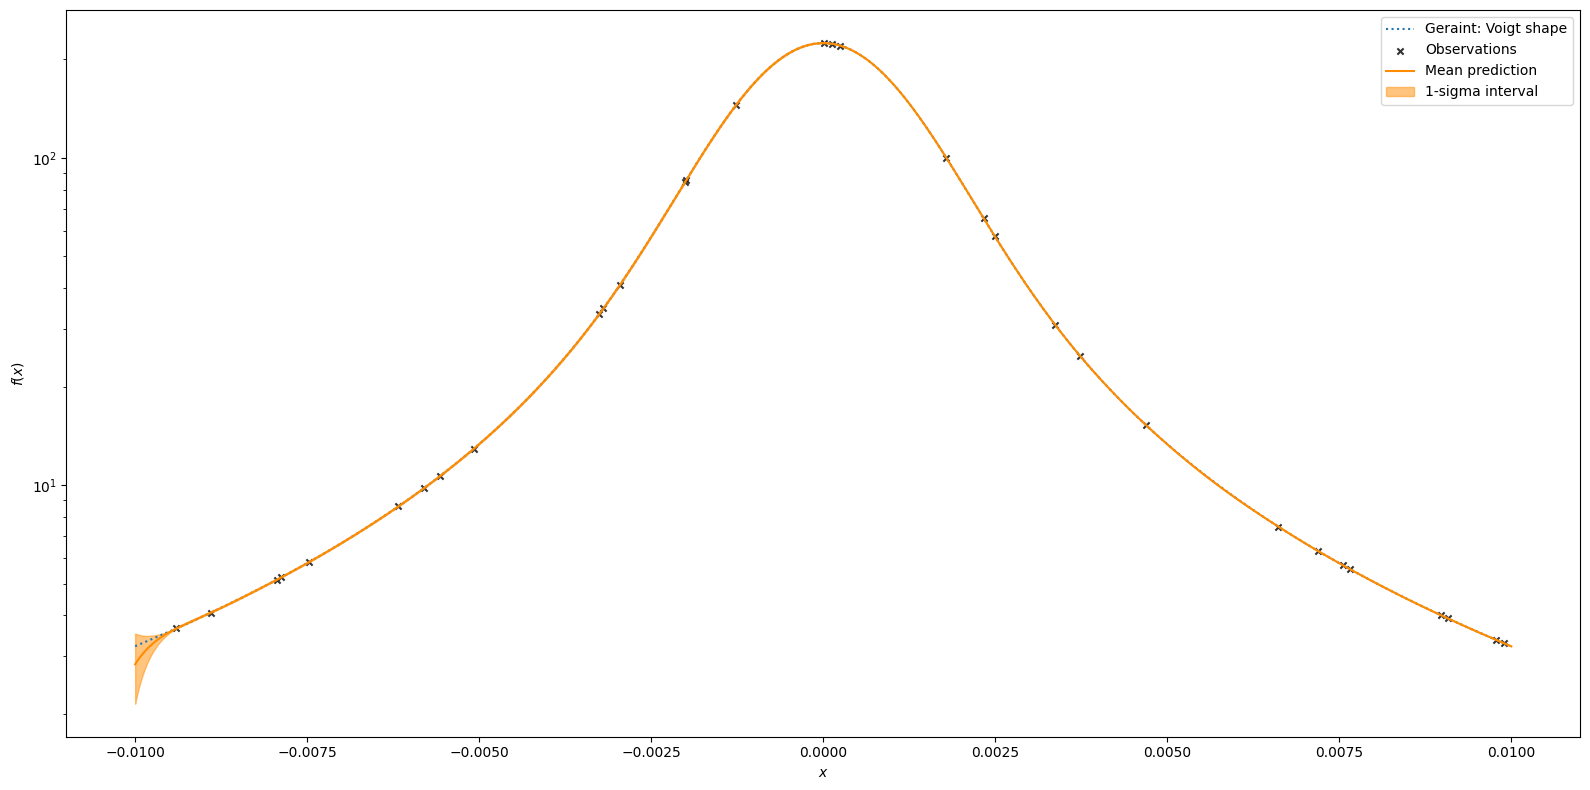

51.6**2 * RBF(length_scale=0.0015)


In [ ]:
Geraint.label=r'Geraint: Voigt shape'
Geraint.gpr_fit(kernel = k_rbf)
Geraint.title=r'Geraint: GPR auf zufällige Trainingspunkte mit RBF'
Geraint.drawfit()
Geraint.title=r'Geraint: GPR auf zufällige Trainingspunkte mit RBF in logscale'
Geraint.drawfit(log=True)
print(Geraint.gpr_kernel)

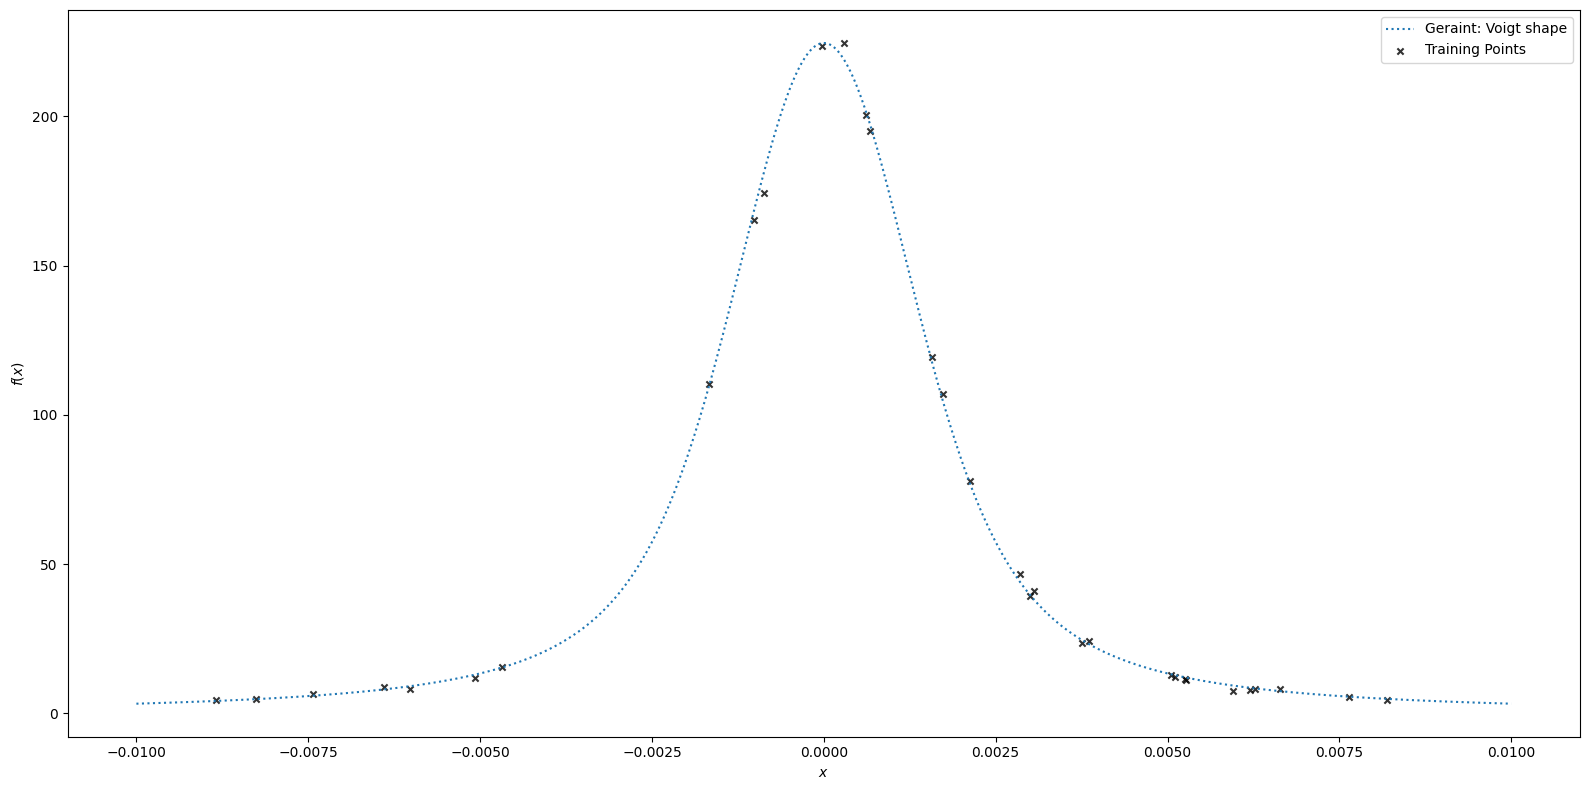

In [ ]:
Geraint.randompoints(seed=3)

alpha_Geraint = np.sqrt(Geraint.y_train)/4
Geraint.noisify(noise_type='poisson')
Geraint.title=r'Geraint mit seed 3 '
Geraint.draw()

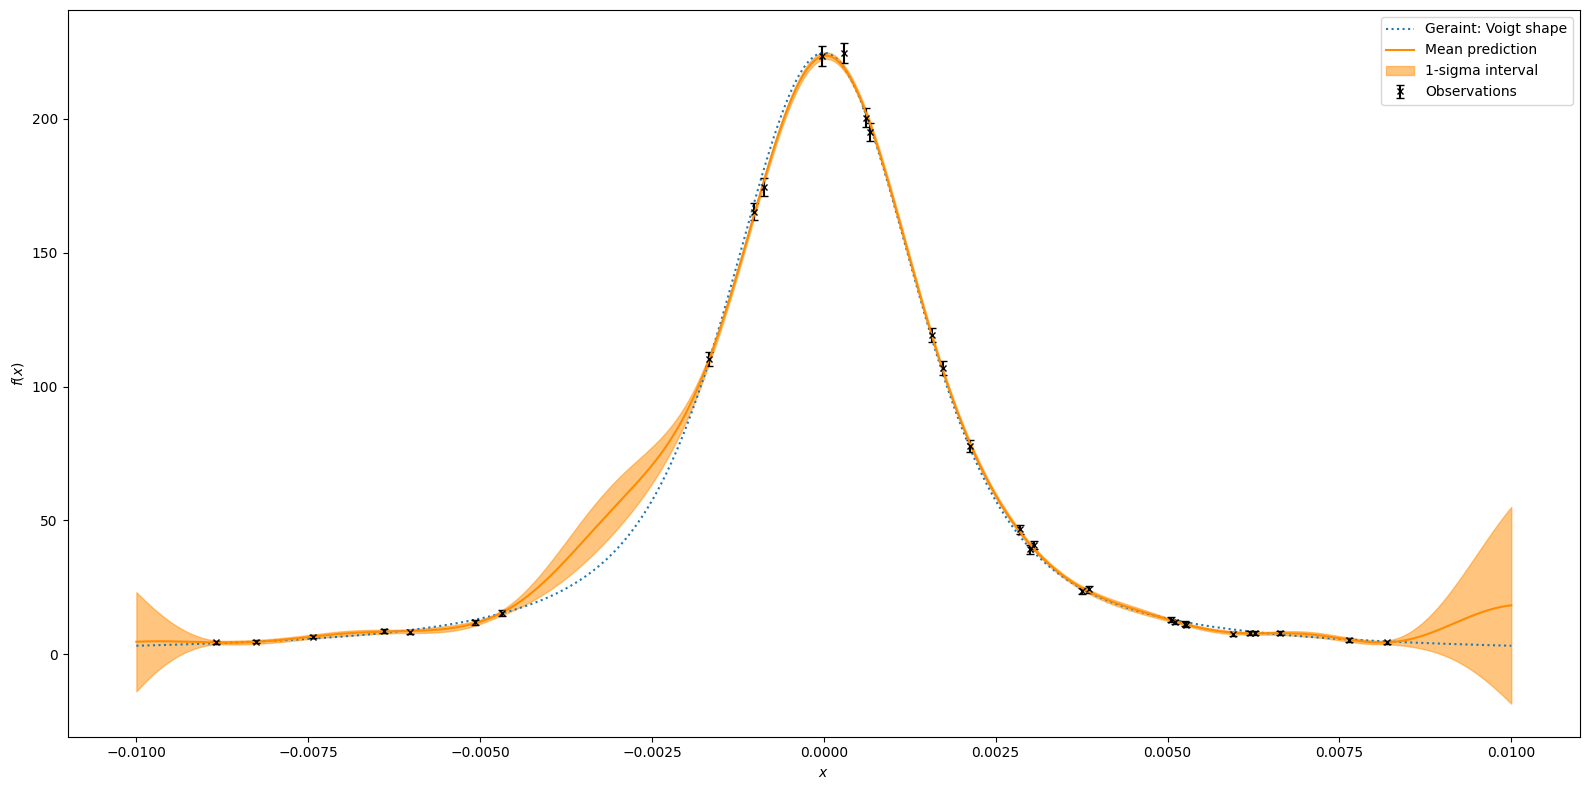

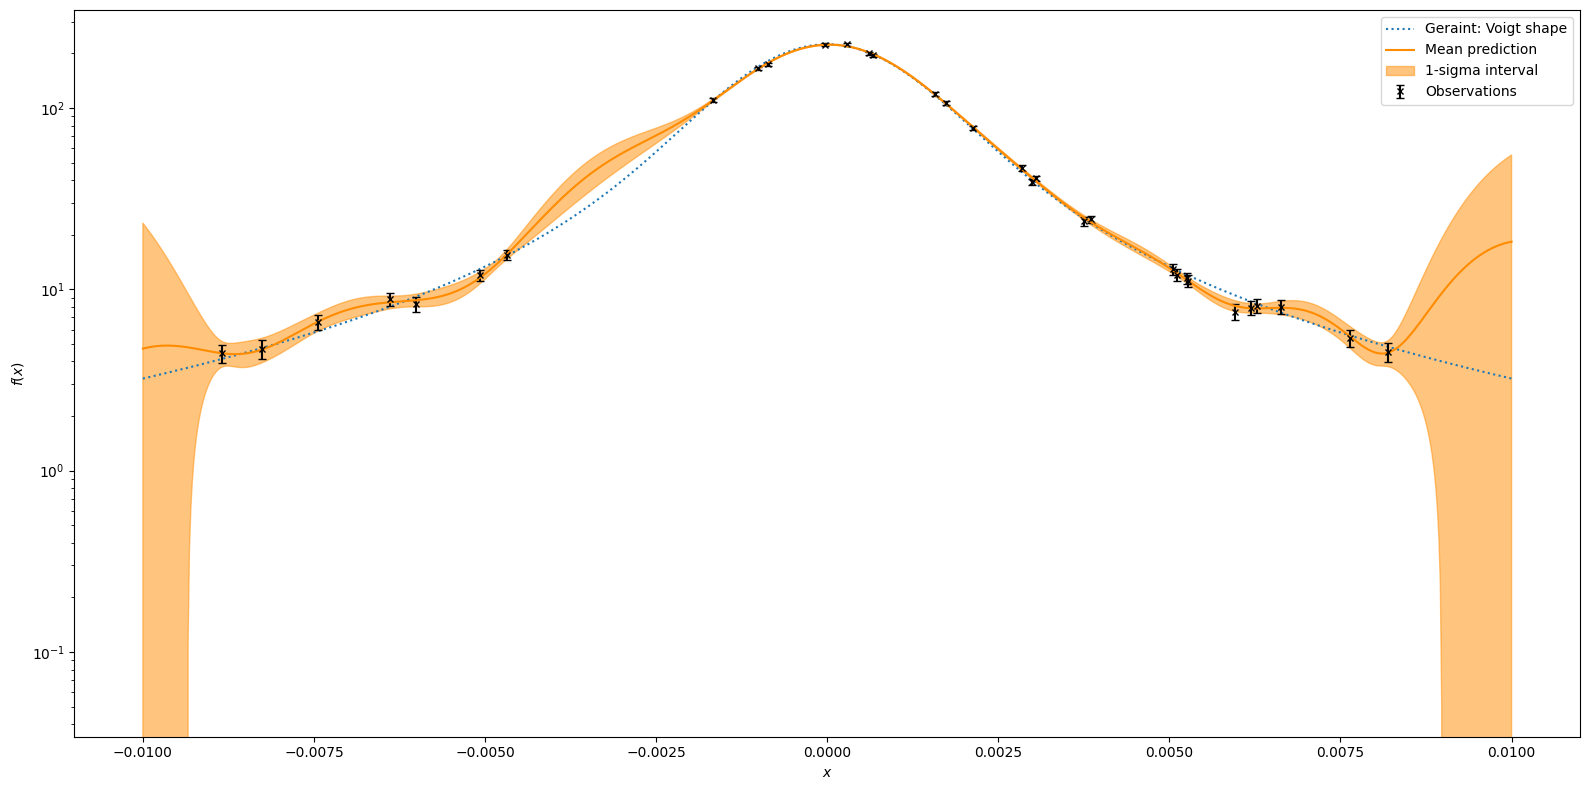

65.4**2 * RBF(length_scale=0.00153)


In [ ]:
Geraint.gpr_fit(kernel = k_rbf,alpha=alpha_Geraint)
Geraint.title=r'Geraint: GPR auf verrauschte Trainingspunkte mit RBF'
Geraint.drawfit(noise=alpha_Geraint)
Geraint.title=r'Geraint: GPR auf verrauschte Trainingspunkte mit RBF in logscale'
Geraint.drawfit(noise=alpha_Geraint,log=True)
print(Geraint.gpr_kernel)

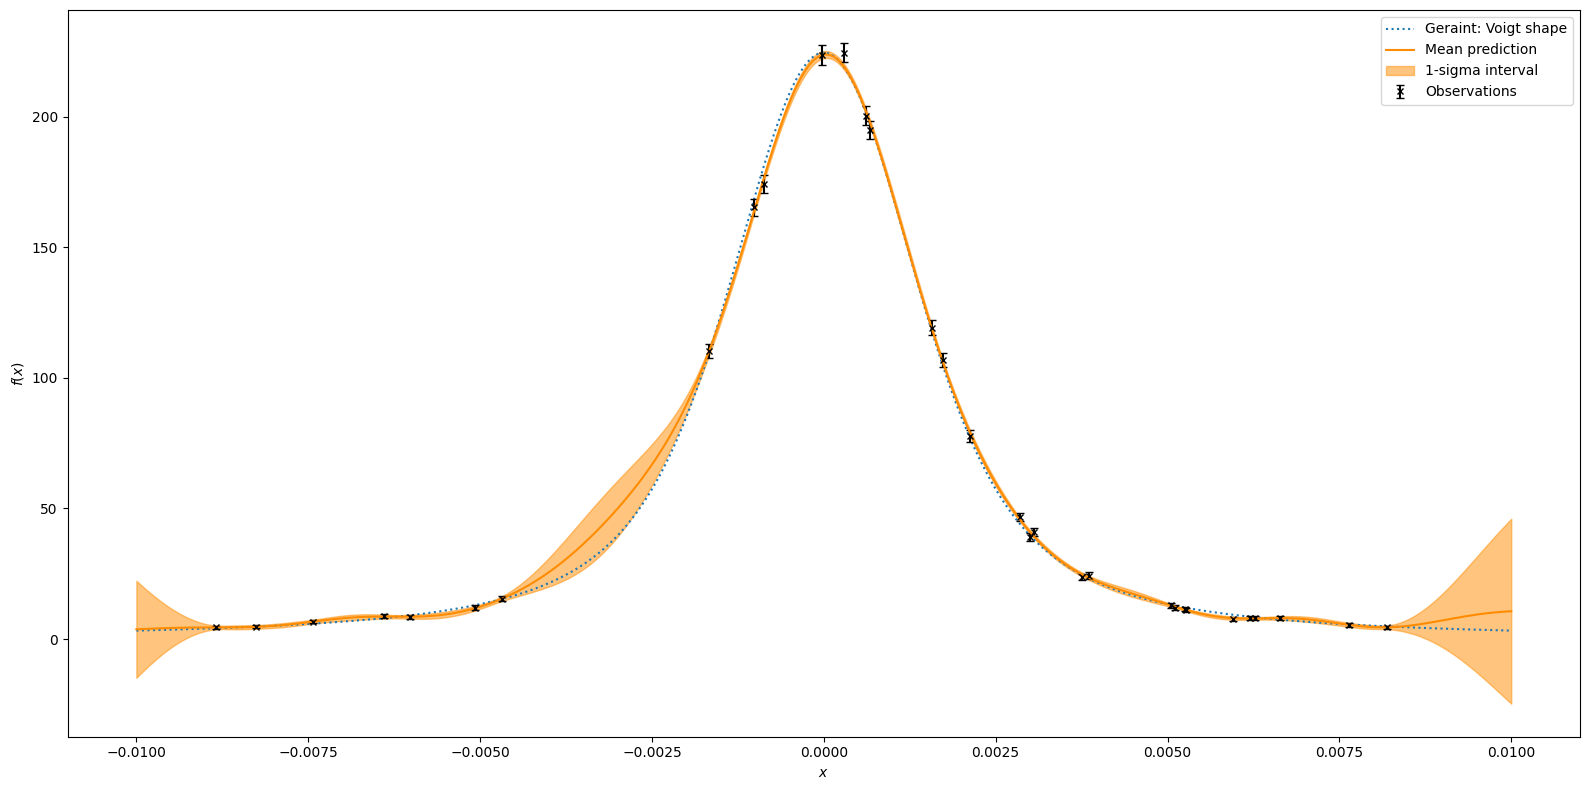

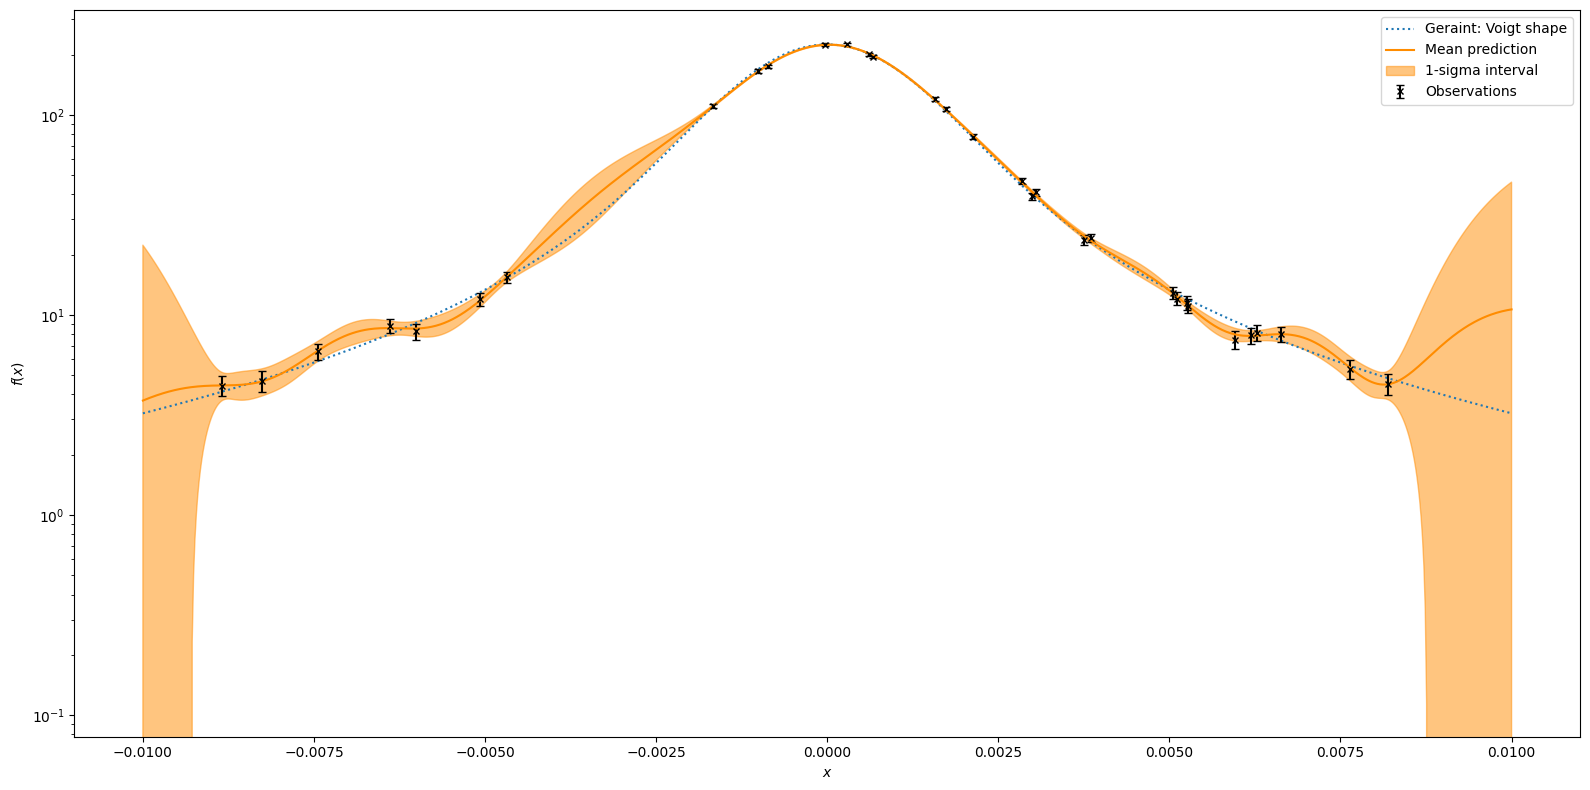

36.4**2 * RBF(length_scale=1.89e+09) * 2.07**2 * RationalQuadratic(alpha=1.75, length_scale=0.0021)


In [ ]:
Geraint.gpr_fit(kernel = k_rbf * k_rq,alpha=alpha_Geraint)
Geraint.title=r'Geraint: GPR auf verrauschte Trainingspunkte mit RBFRQ'
Geraint.drawfit(noise=alpha_Geraint)
Geraint.title=r'Geraint: GPR auf verrauschte Trainingspunkte mit RBFRQ in logscale'
Geraint.drawfit(noise=alpha_Geraint,log=True)
print(Geraint.gpr_kernel)

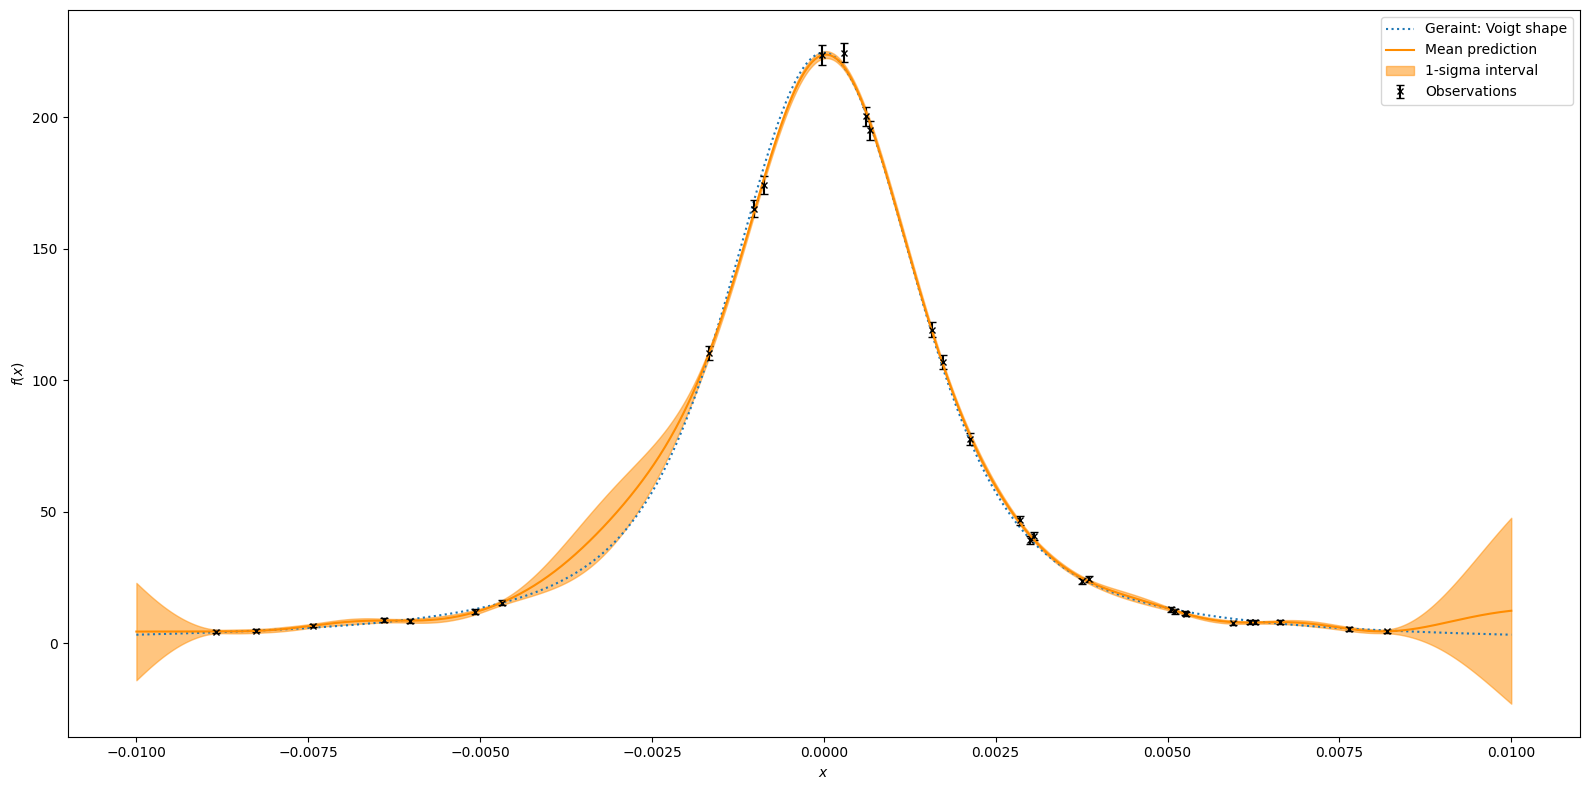

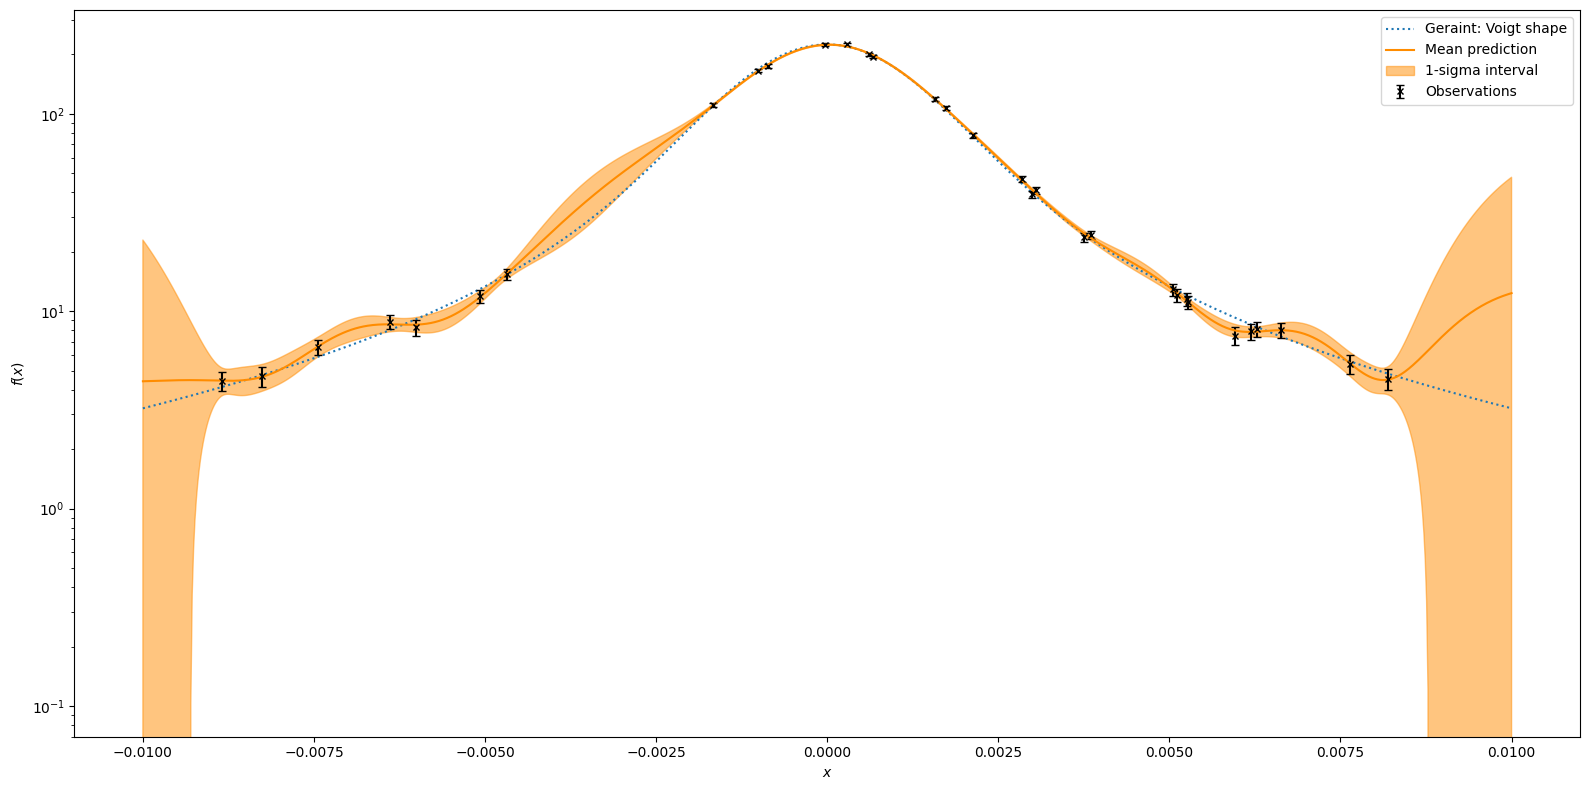

17.5**2 * RBF(length_scale=100) + 73**2 * RationalQuadratic(alpha=1.95, length_scale=0.00205)


In [ ]:
Geraint.gpr_fit(kernel = k_rbf + k_rq,alpha=alpha_Geraint)
Geraint.title=r'Geraint: GPR auf verrauschte Trainingspunkte mit RBF+RQ'
Geraint.drawfit(noise=alpha_Geraint)
Geraint.title=r'Geraint: GPR auf verrauschte Trainingspunkte mit RBF+RQ in logscale'
Geraint.drawfit(noise=alpha_Geraint,log=True)
print(Geraint.gpr_kernel)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


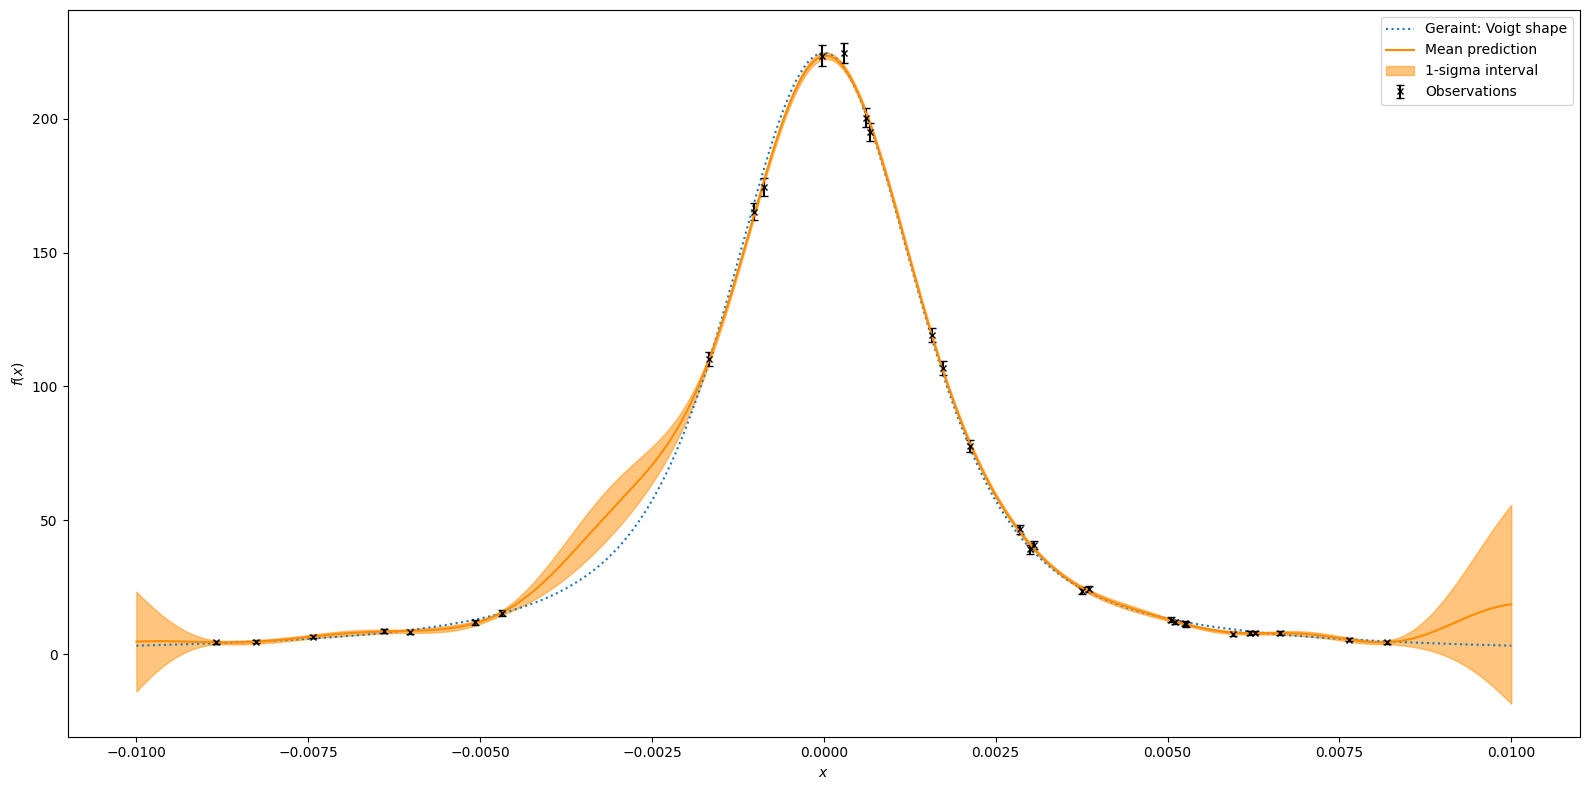

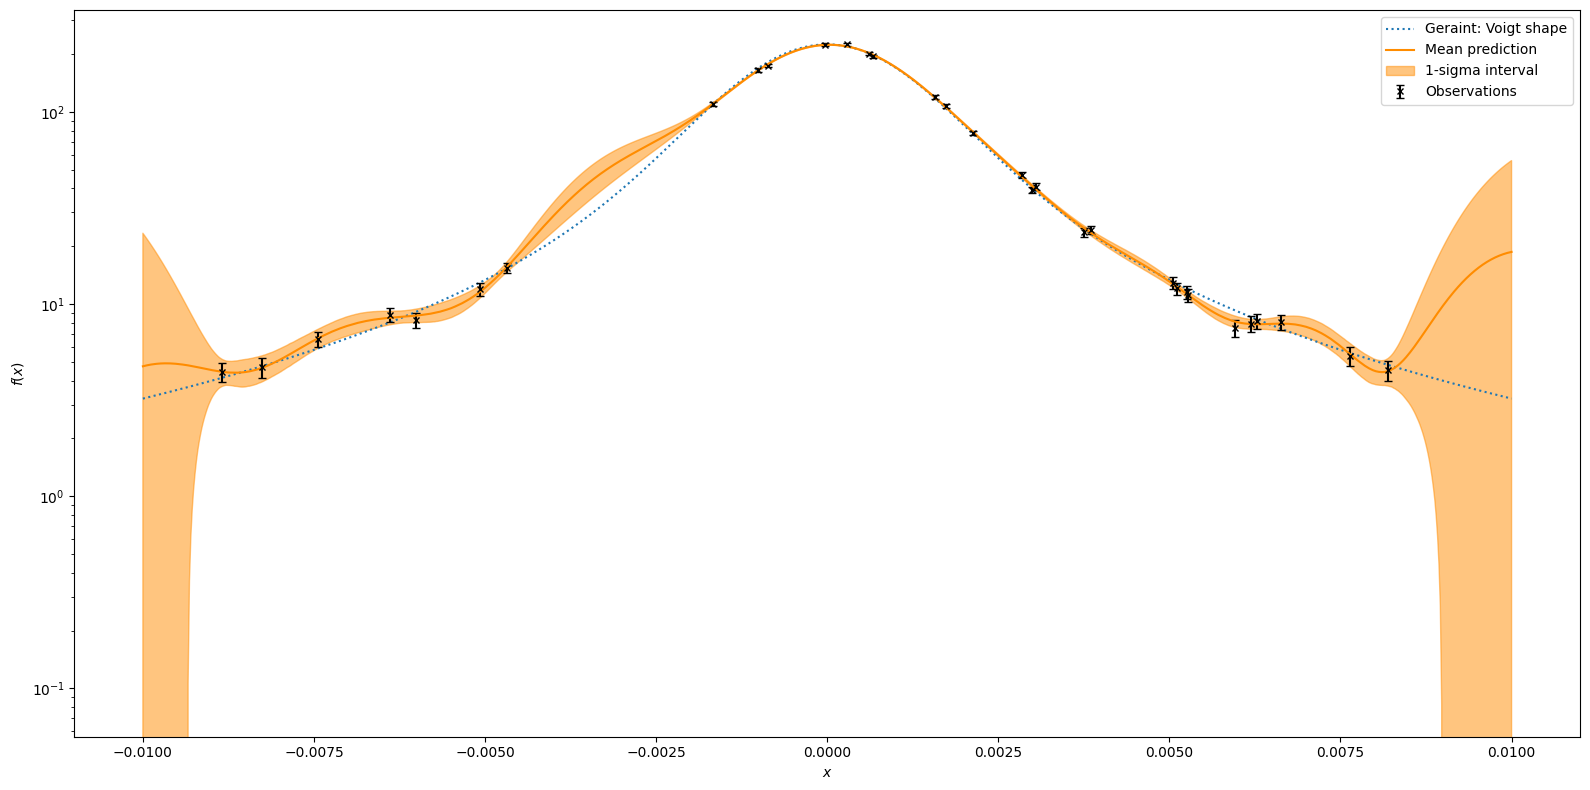

15.4**2 * RBF(length_scale=1.94e+13) * 4.33**2 * RationalQuadratic(alpha=9.84e+09, length_scale=0.00154) + 0.0483**2 * WhiteKernel(noise_level=0.00141)


In [ ]:
k_w = 1**2 * WhiteKernel(1.0)

Geraint.gpr_fit(kernel = k_rbf * k_rq + k_w,alpha=alpha_Geraint)
Geraint.title=r'Geraint: GPR auf verrauschte Trainingspunkte mit RBFRQW'
Geraint.drawfit(noise=alpha_Geraint)
Geraint.title=r'Geraint: GPR auf verrauschte Trainingspunkte mit RBFRQW in logscale'
Geraint.drawfit(noise=alpha_Geraint,log=True)
print(Geraint.gpr_kernel)

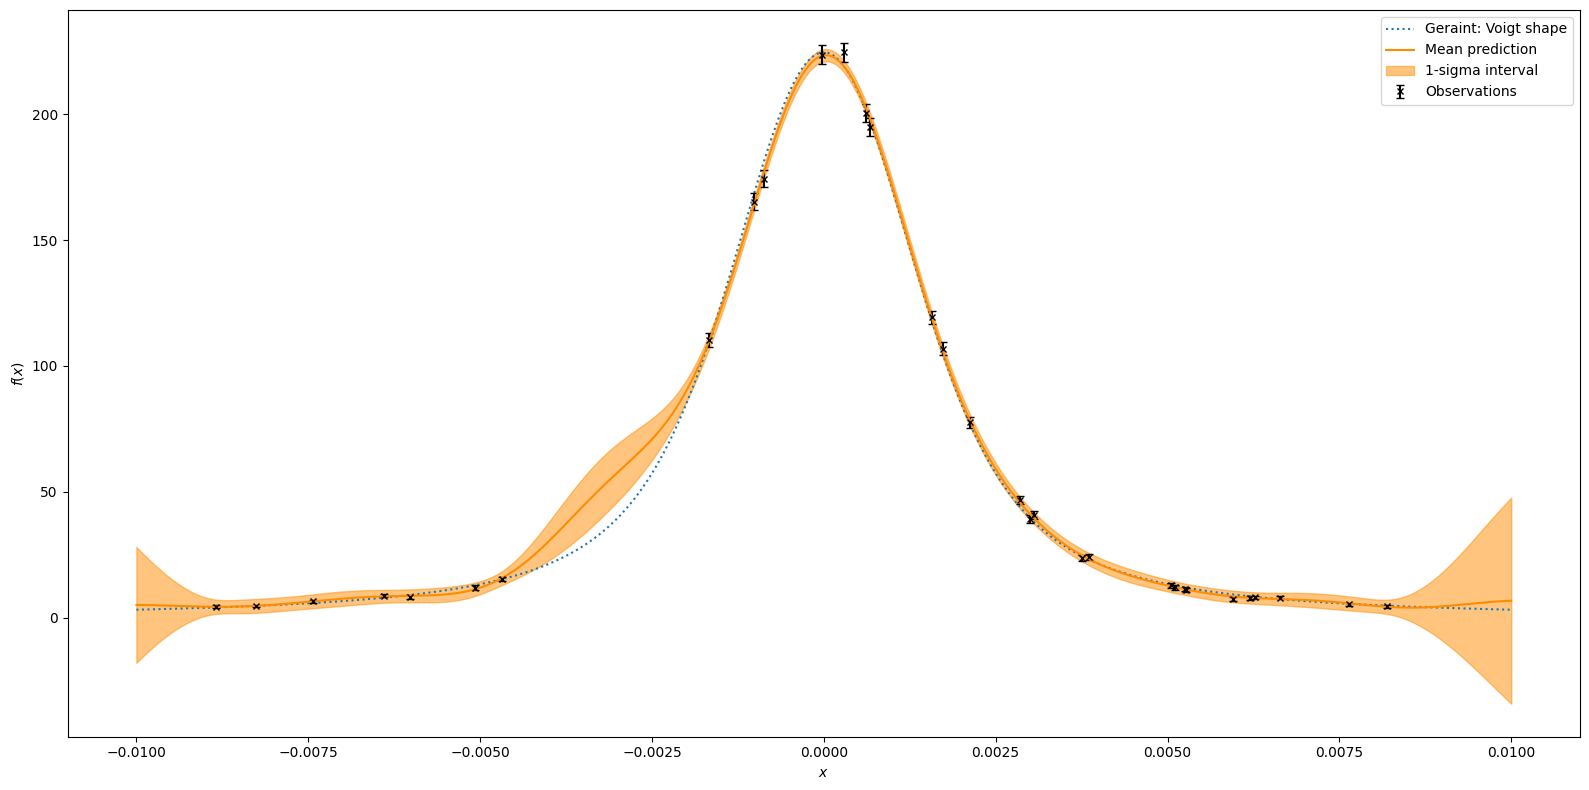

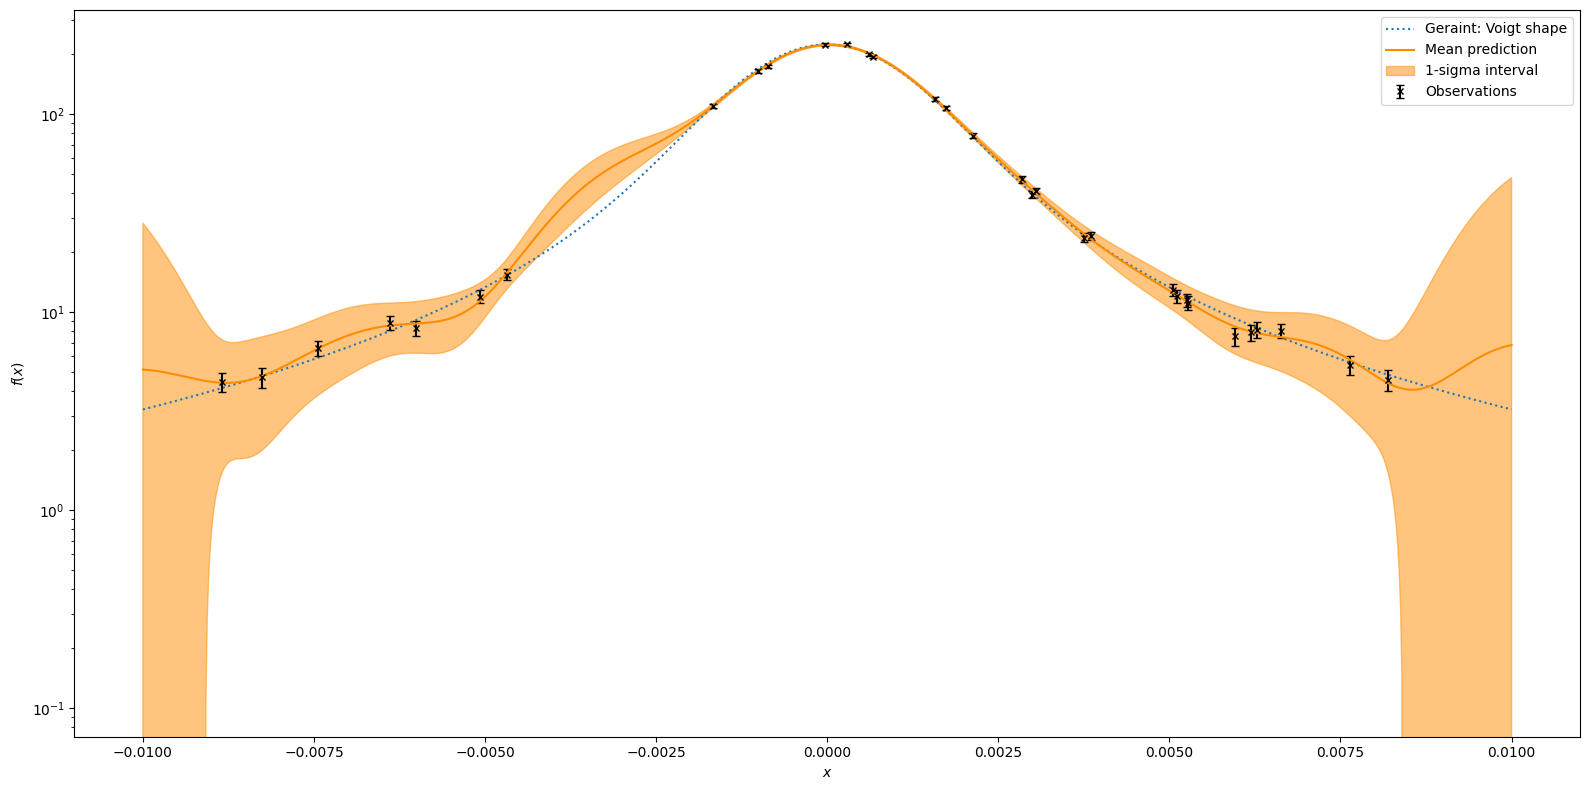

8.19**2 * RBF(length_scale=0.00158) * 8.13**2 * RationalQuadratic(alpha=1.07e+09, length_scale=0.00918) + 1.77**2 * WhiteKernel(noise_level=1.31)


In [ ]:
Geraint.gpr_fit(kernel = k_rbf * k_rq + k_w,alpha=1e-10)
Geraint.title=r'Geraint: GPR auf verrauschte Trainingspunkte mit RBFRQW ohne alpha'
Geraint.drawfit(noise=alpha_Geraint)
Geraint.title=r'Geraint: GPR auf verrauschte Trainingspunkte mit RBFRQW ohne alpha in logscale'
Geraint.drawfit(noise=alpha_Geraint,log=True)
print(Geraint.gpr_kernel)

Data Points pre cut:  32
Data Points after cut:  29


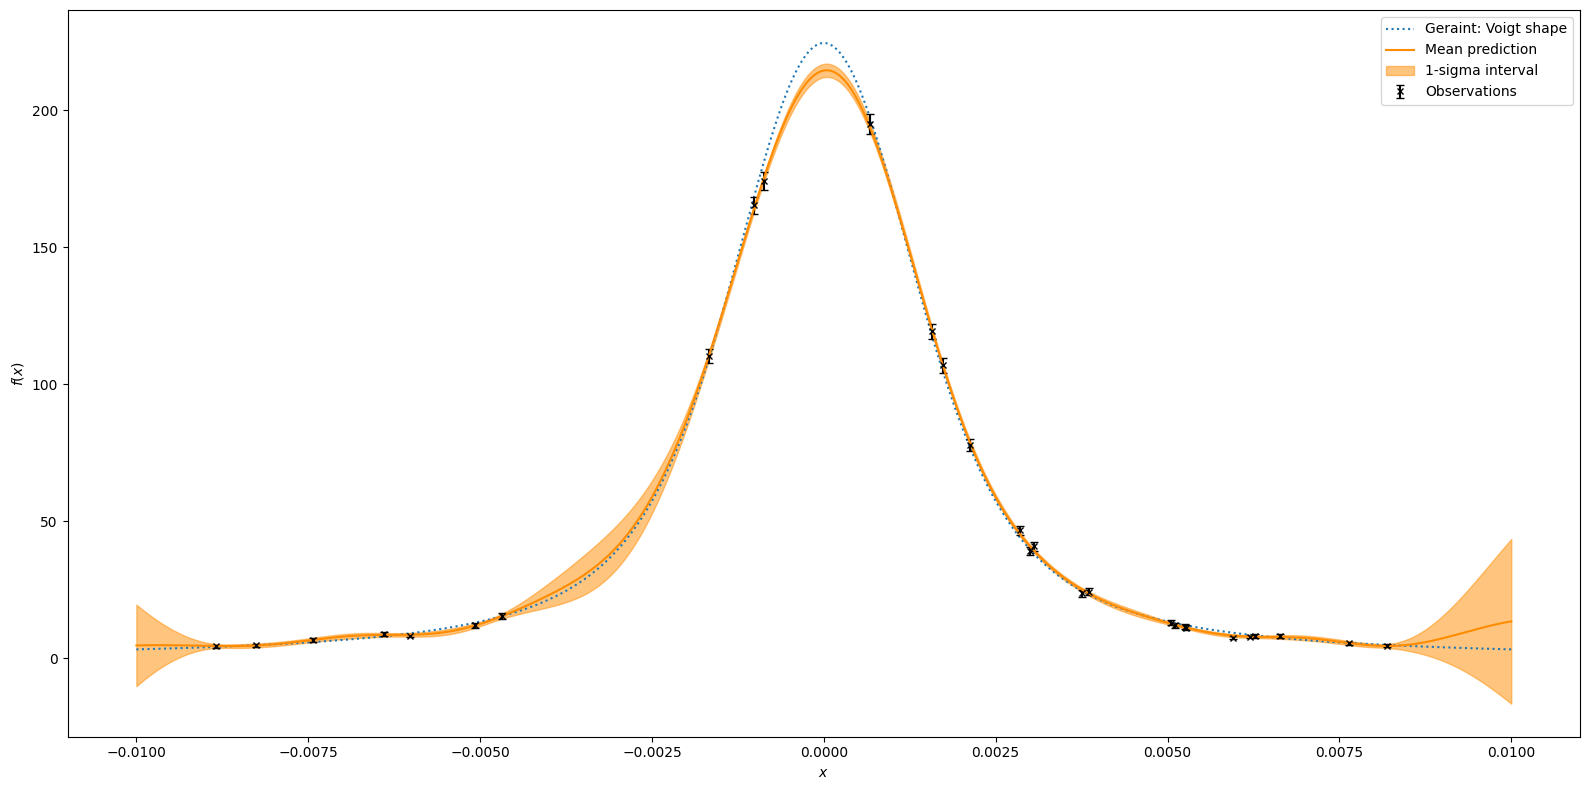

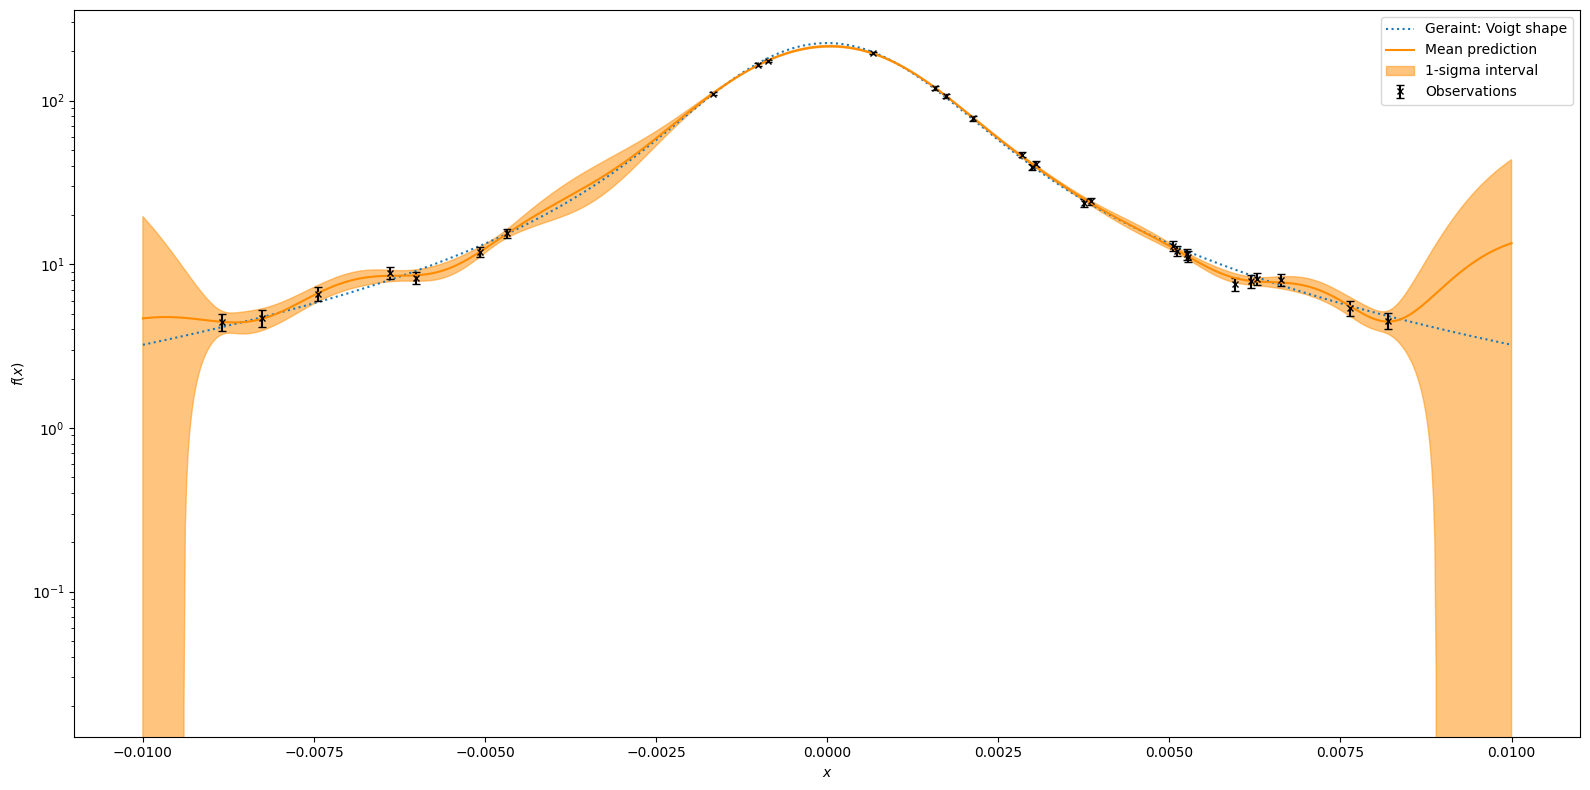

8.59**2 * RBF(length_scale=100) * 8.59**2 * RationalQuadratic(alpha=2.65, length_scale=0.00219)


In [ ]:
Geraint.behead(0.11)
alpha_Geraint = np.sqrt(Geraint.y_train)/4 # update alpha after the array has been cut
Geraint.gpr_fit(kernel = k_rbf * k_rq,alpha=alpha_Geraint)
Geraint.title=r'Geraint: GPR auf verrauschte enthauptete Trainingspunkte mit RBFRQ'
Geraint.drawfit(noise=alpha_Geraint)
Geraint.title=r'Geraint: GPR auf verrauschte enthauptete Trainingspunkte mit RBFRQ in logscale'
Geraint.drawfit(noise=alpha_Geraint,log=True)
print(Geraint.gpr_kernel)

### `Hagan`-Experiment

In [ ]:
k_rbf = 1**2 * RBF(length_scale=0.02, length_scale_bounds=(1e-5, 1e20)) # default bounds = (1e-5, 1e5)
k_rq = 1**2 * RationalQuadratic(length_scale=0.0001, alpha=1, length_scale_bounds=(1e-05, 1e20), alpha_bounds=(1e-05, 1e10))
k_m = 1**2 * Matern(length_scale=1.0,nu=2.5)

In [ ]:
Hagan = EnhancedAnalyticalExperiment(min = -0.01, max = 0.01, alpha= 0.001, gamma= 0.001, size=32)
Hagan.generate()
Hagan.xevenlypoints(testcount=50)
#Hagan.title=r'Hagan: xevenly'
#Hagan.draw()

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


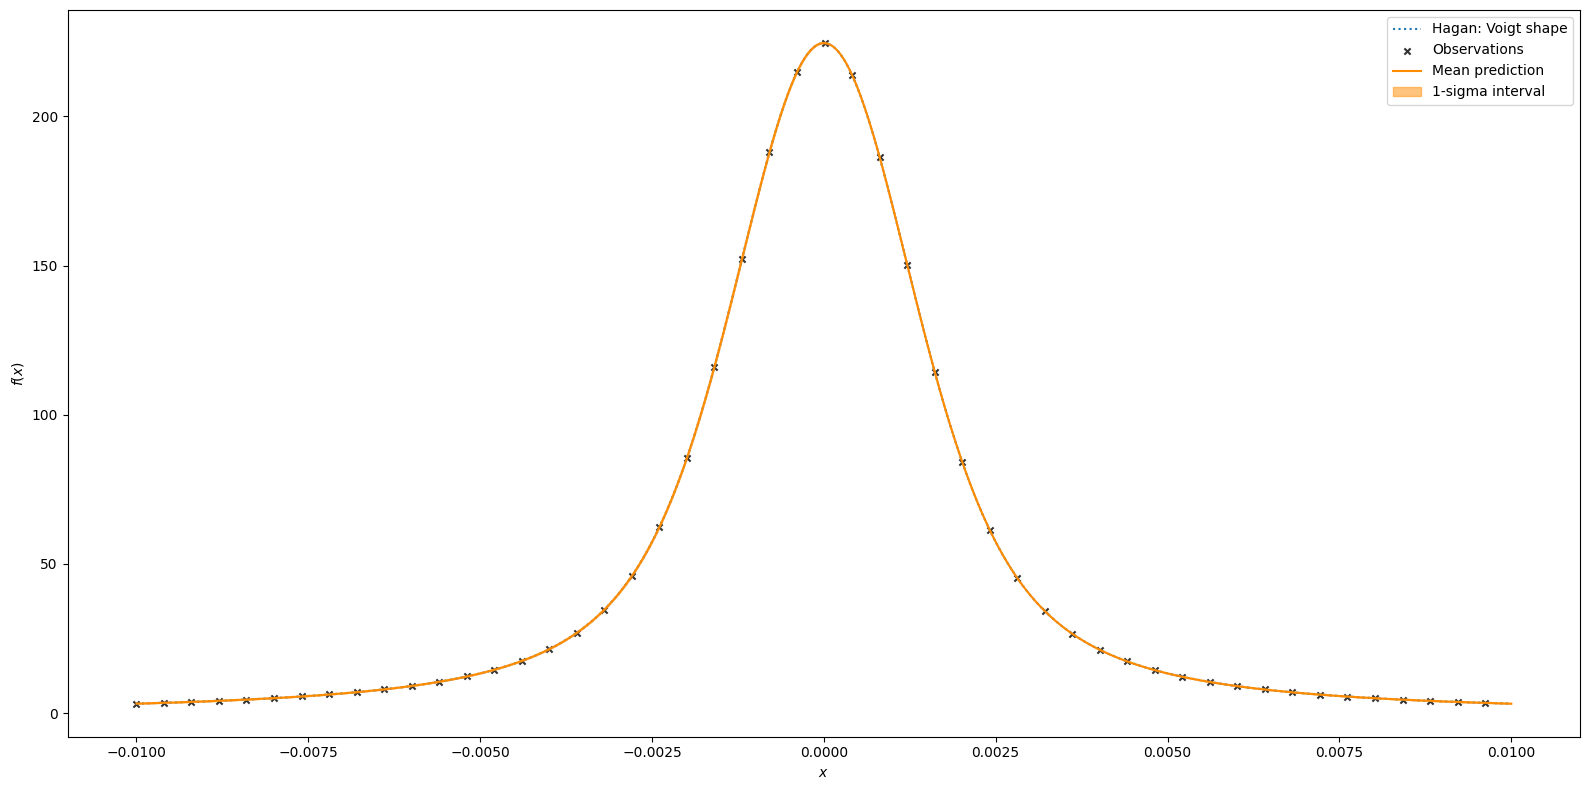

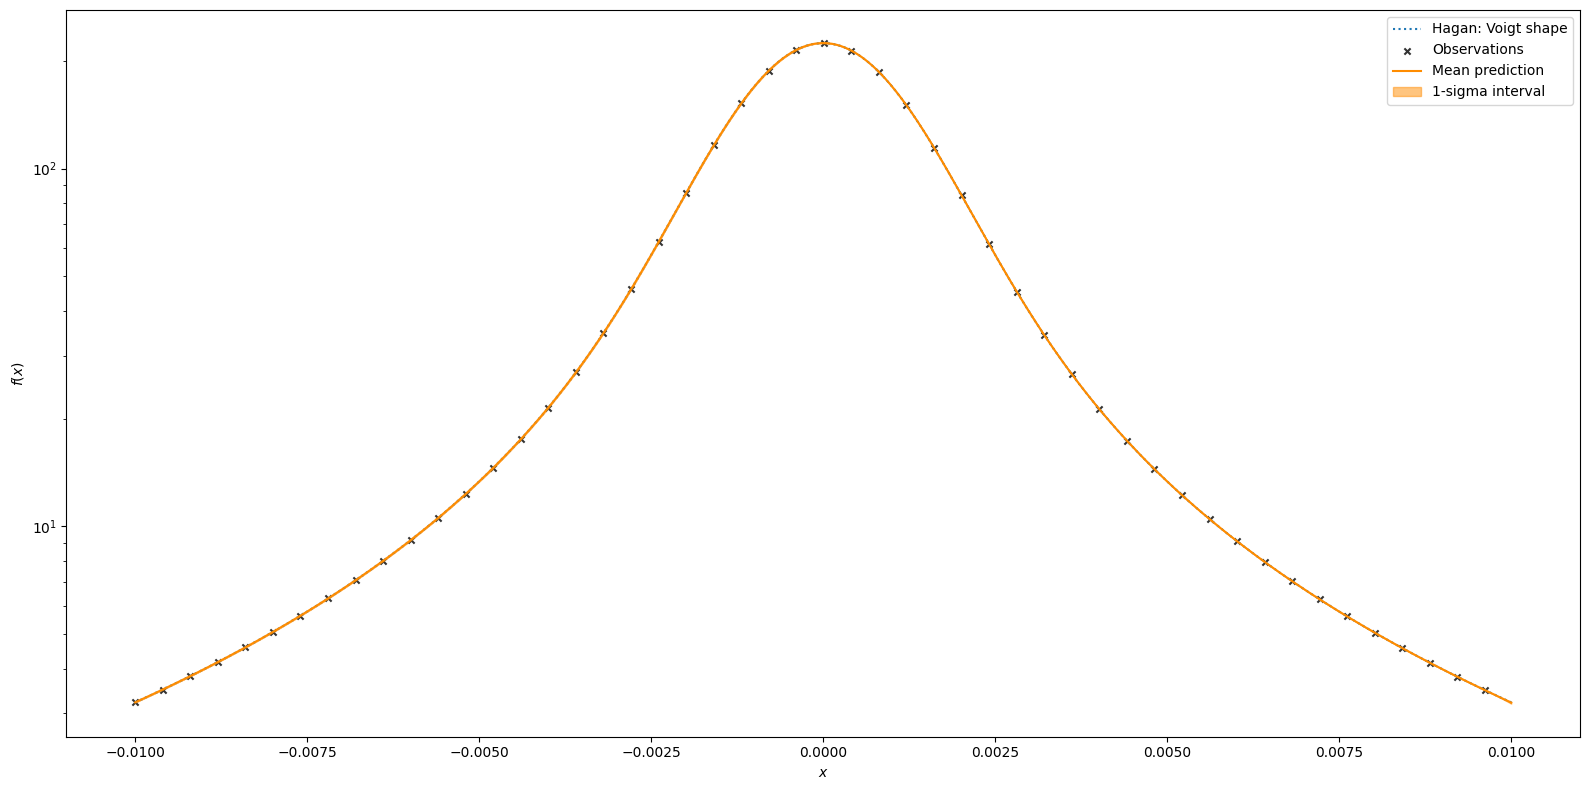

46.1**2 * RBF(length_scale=0.00146)


In [ ]:
hagan_kernel = k_rbf
alpha_Hagan = 1e-10
Hagan.label=r'Hagan: Voigt shape'
Hagan.gpr_fit(kernel = hagan_kernel,alpha=alpha_Hagan)
Hagan.title=r'Hagan: GPR RBF auf xevenly Trainingspunkte'
Hagan.drawfit()
Hagan.title=r'Hagan: GPR RBF auf xevenly Trainingspunkte log'
Hagan.drawfit(log=True)
print(Hagan.gpr_kernel)

In [ ]:
Hagan.noisify(noise_type='poisson')
alpha_Hagan = np.sqrt(Hagan.y_train)/4
#Hagan.title=r'Hagan: xevenly poissoned'
#Hagan.draw()

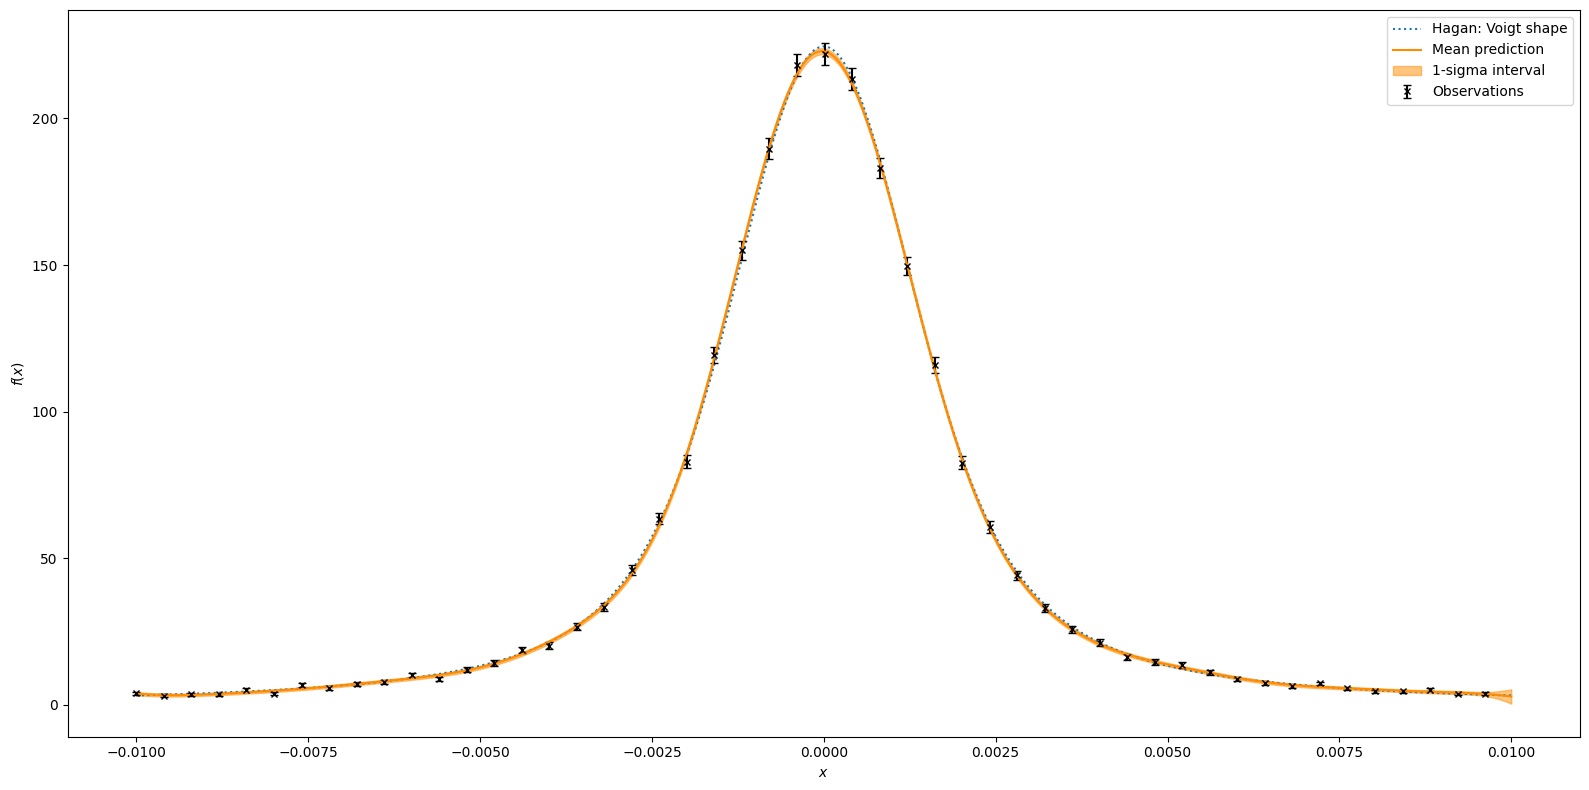

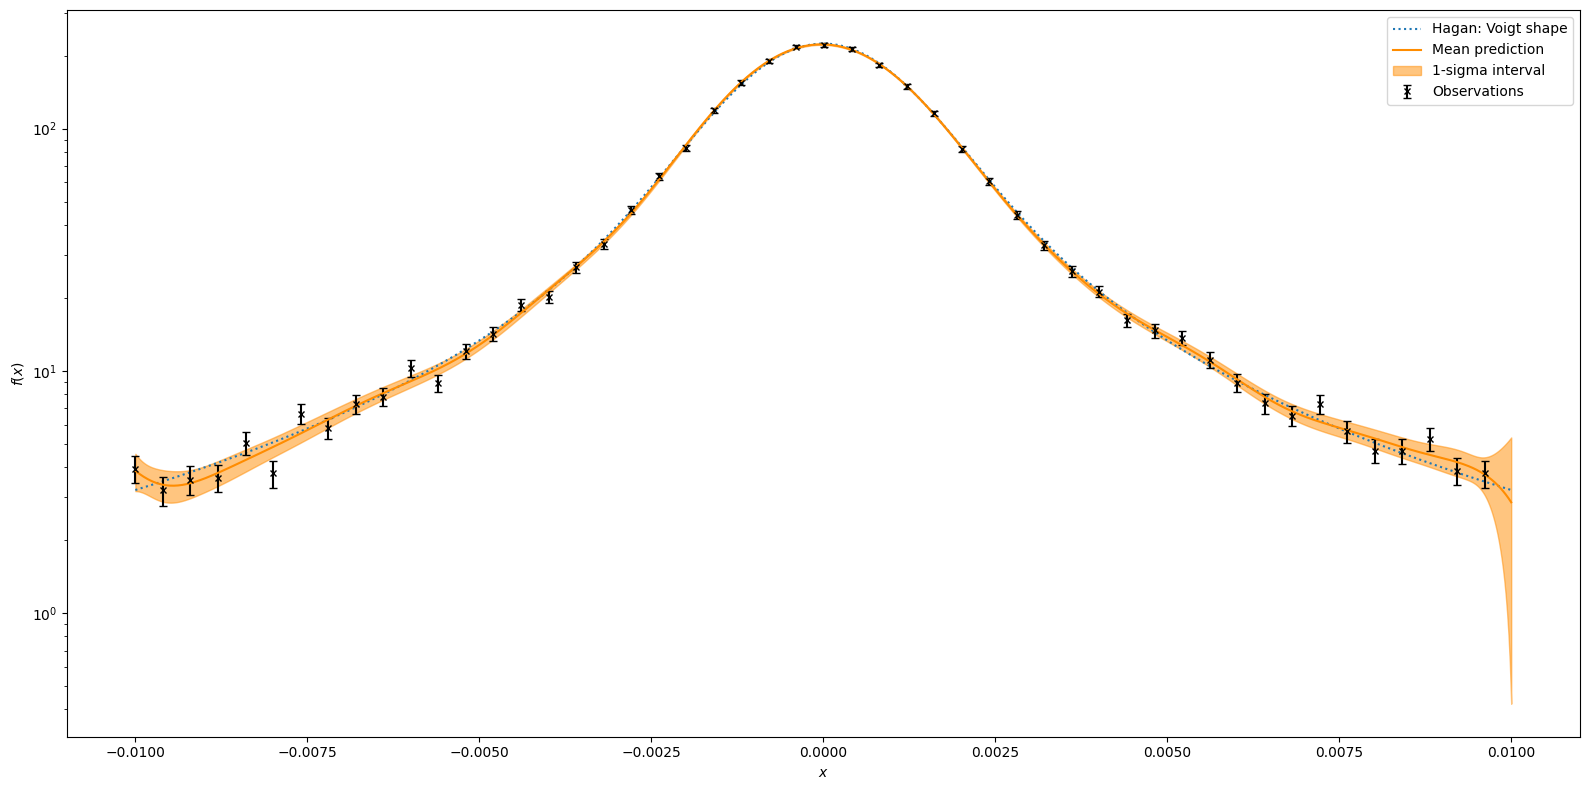

64.5**2 * RBF(length_scale=0.00176)


In [ ]:
hagan_kernel = k_rbf

Hagan.gpr_fit(kernel = hagan_kernel,alpha=alpha_Hagan)
Hagan.title=r'Hagan: GPR RBF auf xevenly poissioned Trainingspunkte'
Hagan.drawfit(noise=alpha_Hagan)
Hagan.title=r'Hagan: GPR RBF auf xevenly poissioned Trainingspunkte log'
Hagan.drawfit(noise=alpha_Hagan,log=True)
print(Hagan.gpr_kernel)

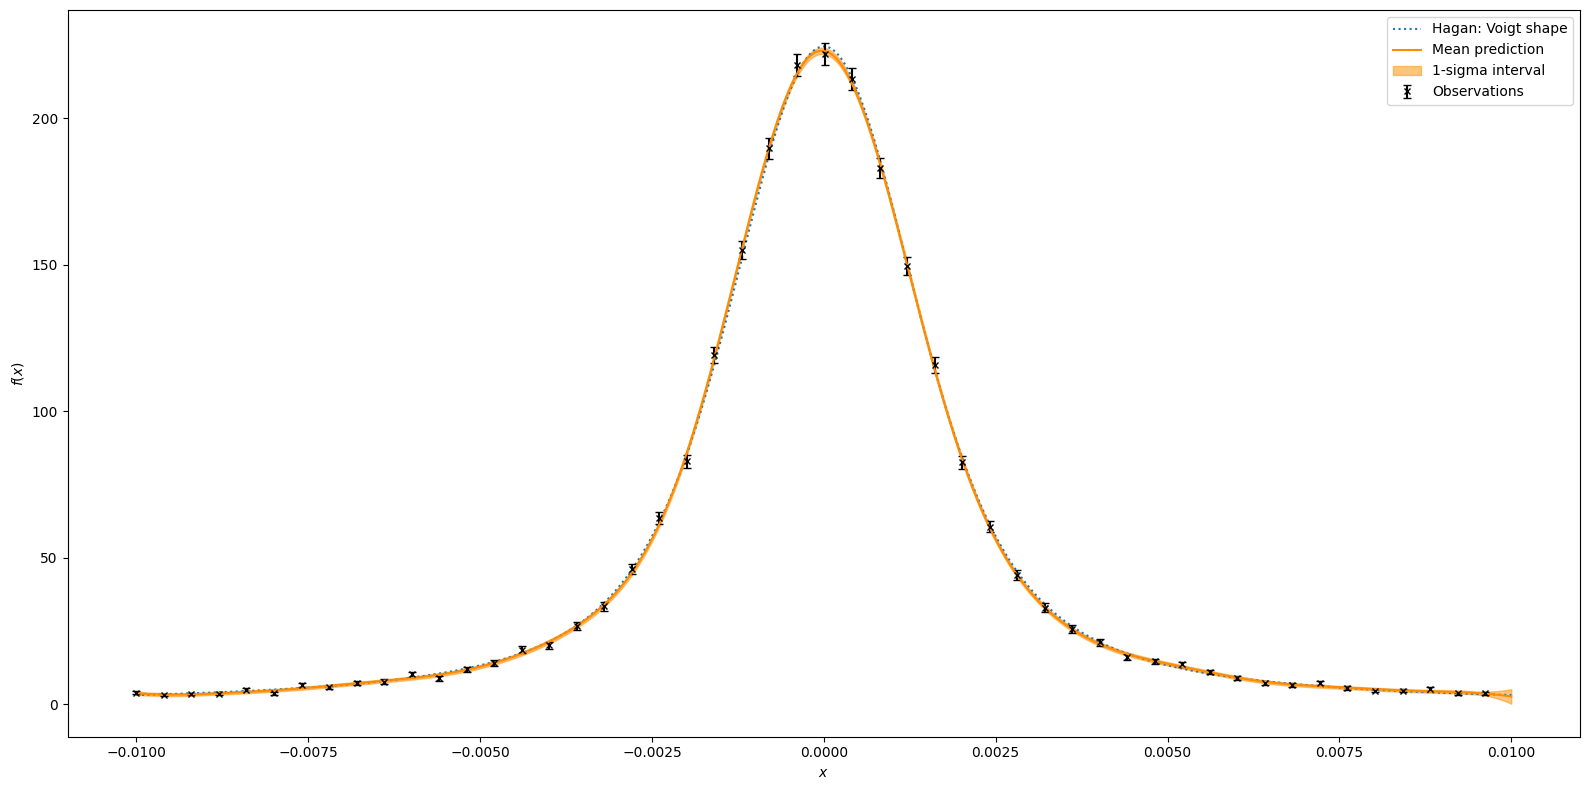

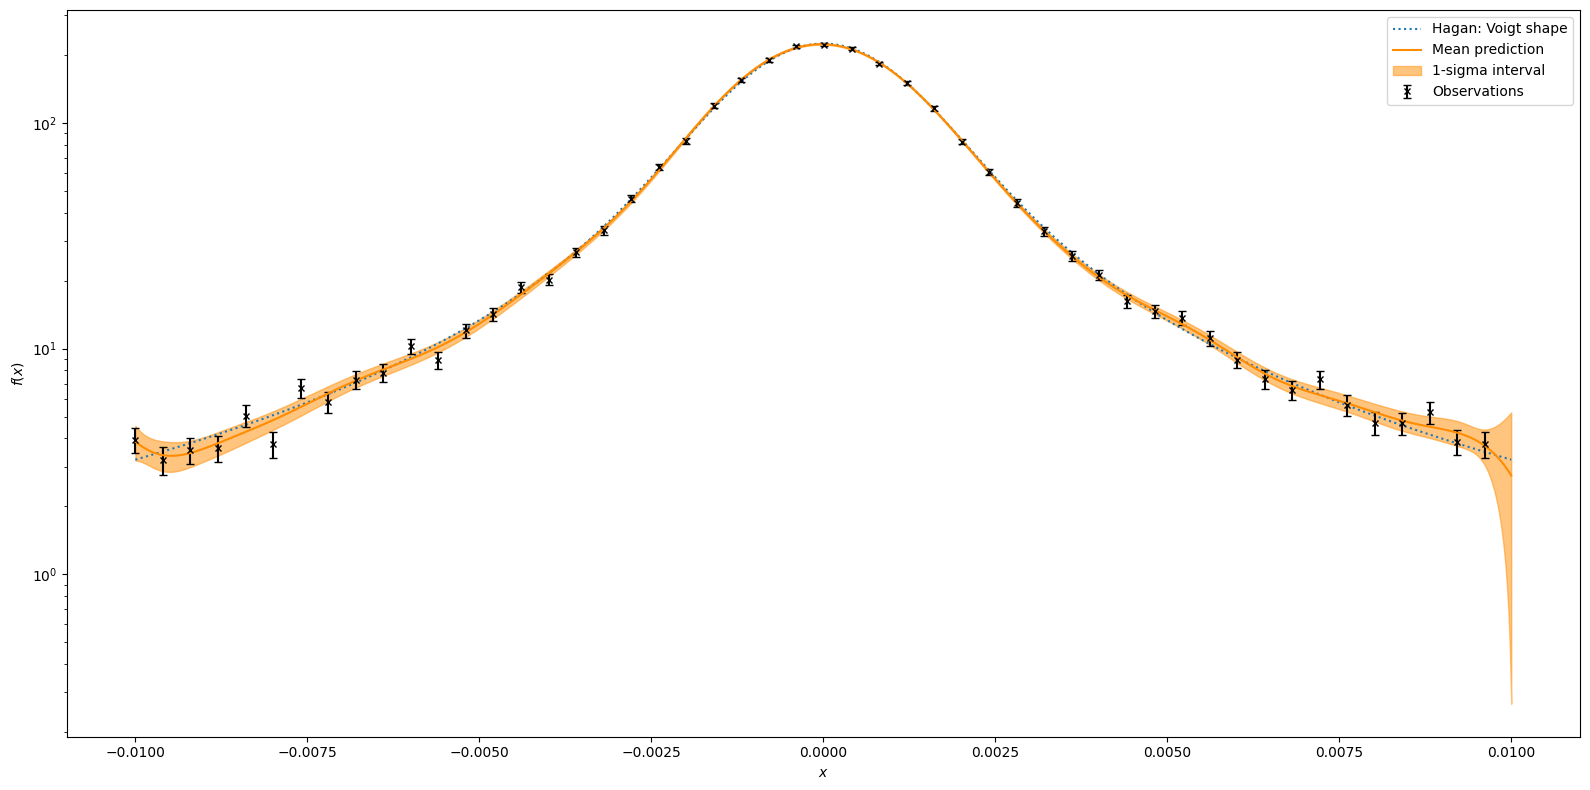

8.32**2 * RBF(length_scale=0.0387) * 8.32**2 * RationalQuadratic(alpha=9.45, length_scale=0.00196)


In [ ]:
hagan_kernel = k_rbf * k_rq

Hagan.gpr_fit(kernel = hagan_kernel,alpha=alpha_Hagan)
Hagan.title=r'Hagan: GPR RBFRQ auf xevenly poissioned Trainingspunkte'
Hagan.drawfit(noise=alpha_Hagan)
Hagan.title=r'Hagan: GPR RBFRQ auf xevenly poissioned Trainingspunkte log'
Hagan.drawfit(noise=alpha_Hagan,log=True)
print(Hagan.gpr_kernel)

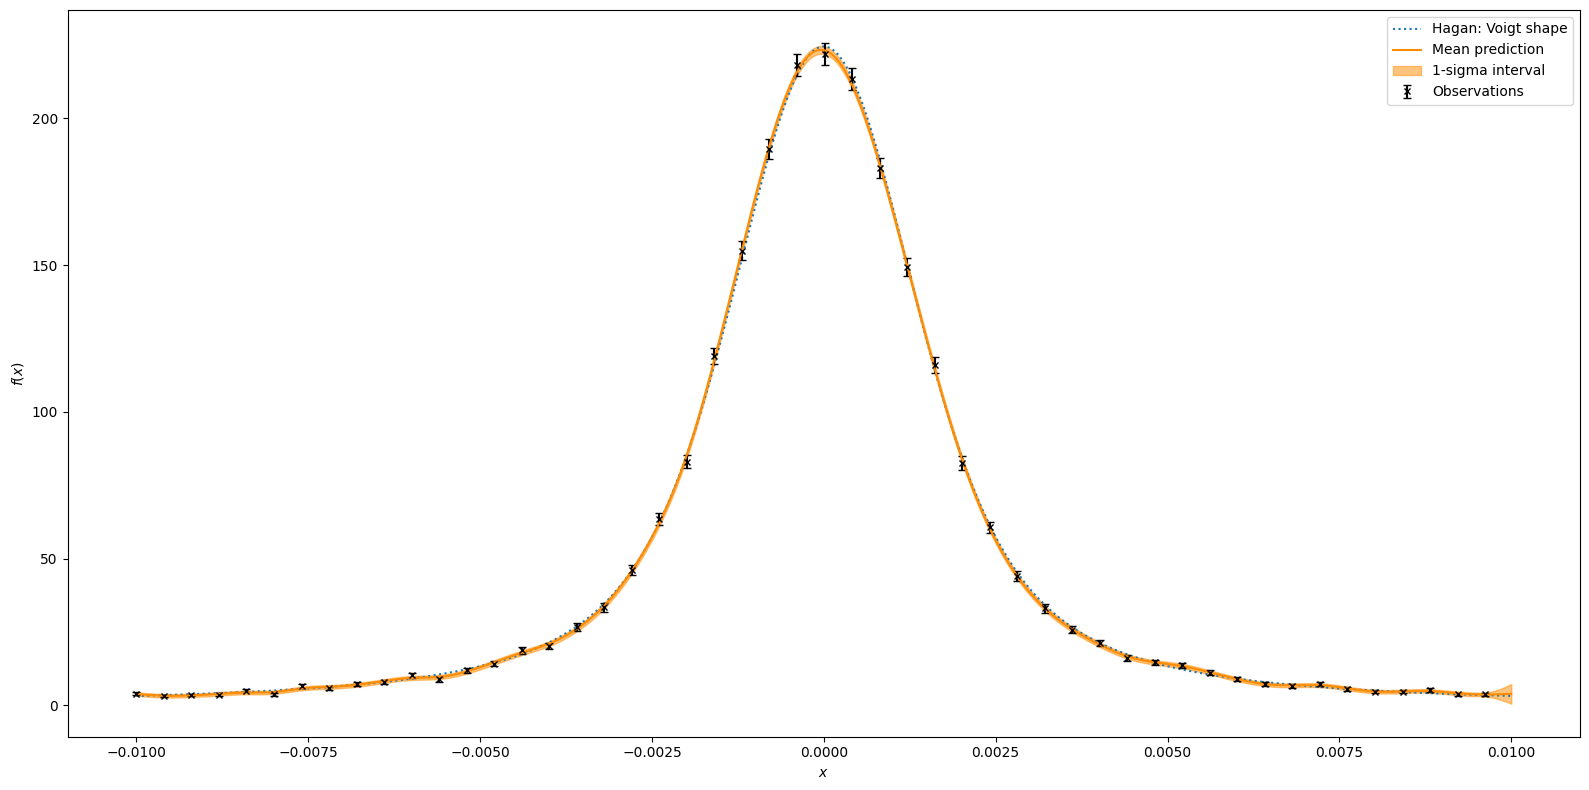

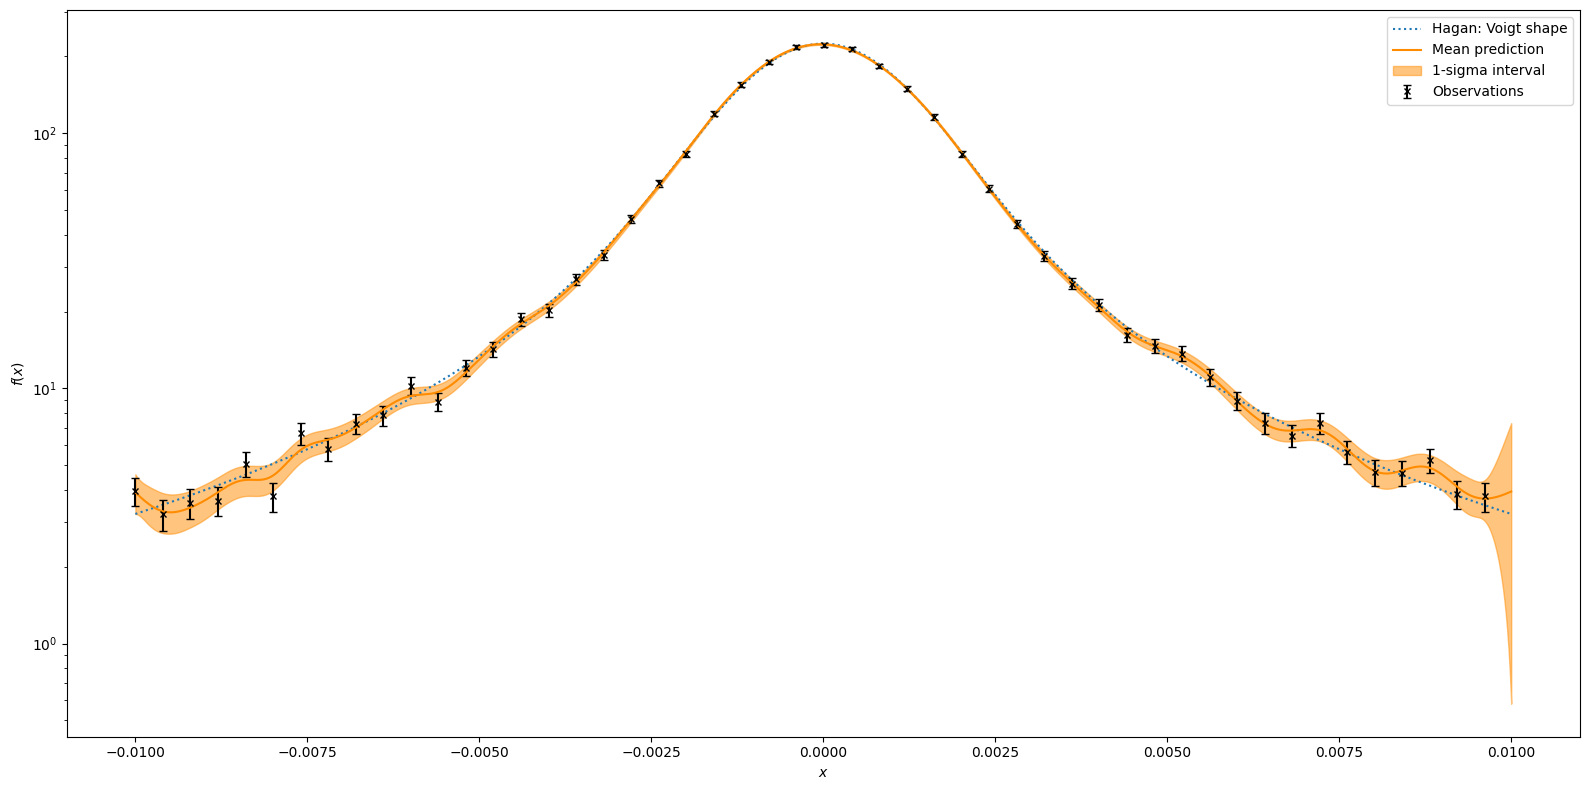

91.8**2 * Matern(length_scale=0.00385, nu=2.5)


In [ ]:
hagan_kernel = k_m

Hagan.gpr_fit(kernel = hagan_kernel,alpha=alpha_Hagan)
Hagan.title=r'Hagan: GPR M auf xevenly poissioned Trainingspunkte'
Hagan.drawfit(noise=alpha_Hagan)
Hagan.title=r'Hagan: GPR M auf xevenly poissioned Trainingspunkte log'
Hagan.drawfit(noise=alpha_Hagan,log=True)
print(Hagan.gpr_kernel)

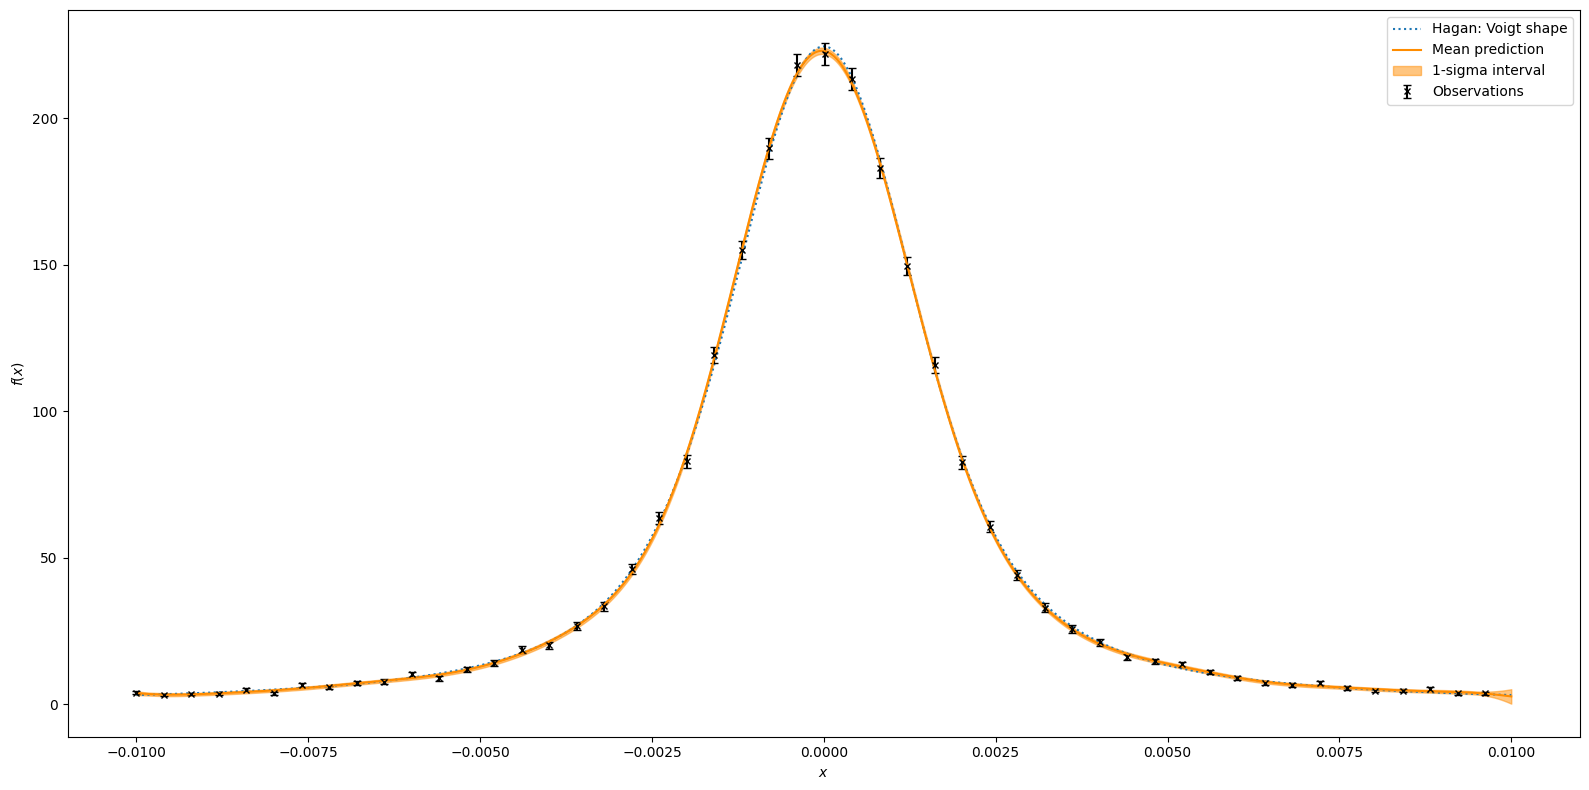

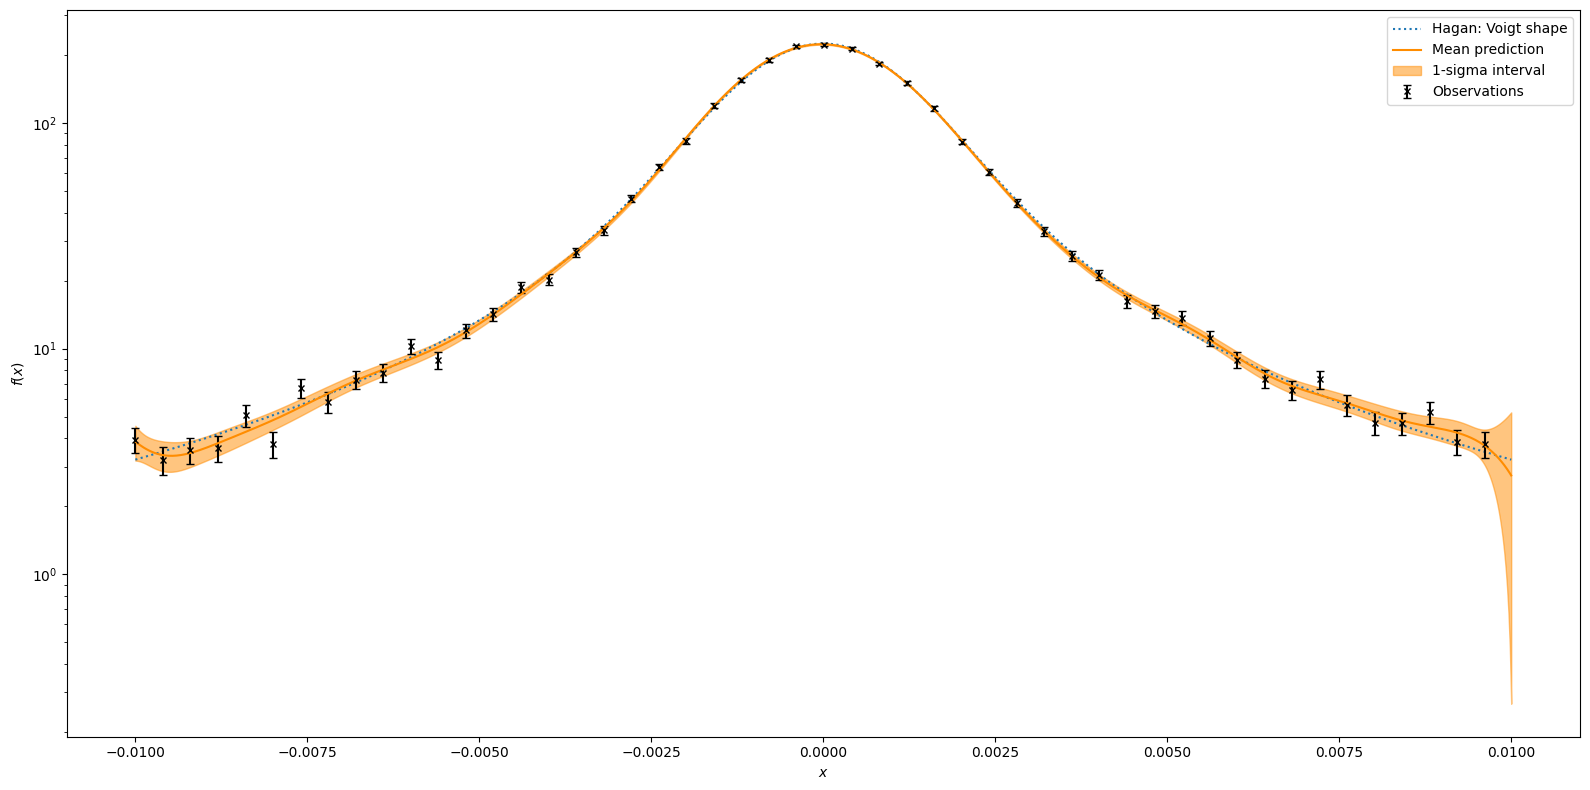

18.1**2 * Matern(length_scale=937, nu=2.5) * 3.84**2 * RationalQuadratic(alpha=9.48, length_scale=0.00196)


In [ ]:
hagan_kernel = k_m * k_rq

Hagan.gpr_fit(kernel = hagan_kernel,alpha=alpha_Hagan)
Hagan.title=r'Hagan: GPR MRQ auf xevenly poissioned Trainingspunkte'
Hagan.drawfit(noise=alpha_Hagan)
Hagan.title=r'Hagan: GPR MRQ auf xevenly poissioned Trainingspunkte log'
Hagan.drawfit(noise=alpha_Hagan,log=True)
print(Hagan.gpr_kernel)

### `Iliad`-Experiment


In [ ]:
Iliad = EnhancedAnalyticalExperiment(min = -0.01, max = 0.01, alpha= 0.001, gamma= 0.001, size=32)
Iliad.generate()
Iliad.yspaced_optimizer()
#Iliad.title=r'Illiad yspaced and optimized'
#Iliad.draw()

In [ ]:
Iliad.noisify(noise_type='poisson')
alpha_Iliad = np.sqrt(Iliad.y_train)/4
#Iliad.title=r'Iliad: yspaced and poissioned'
#Iliad.draw()

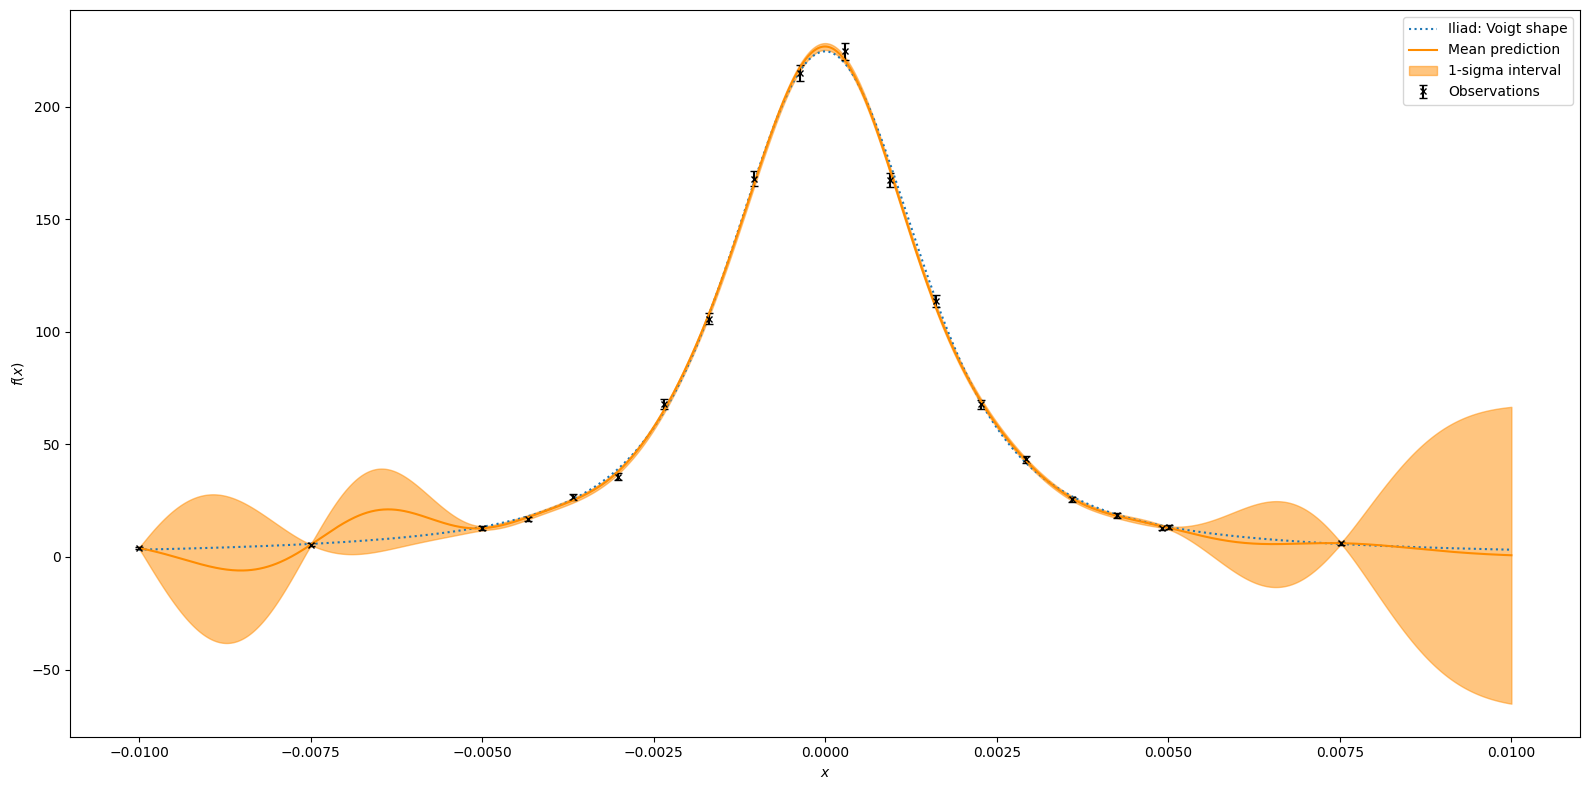

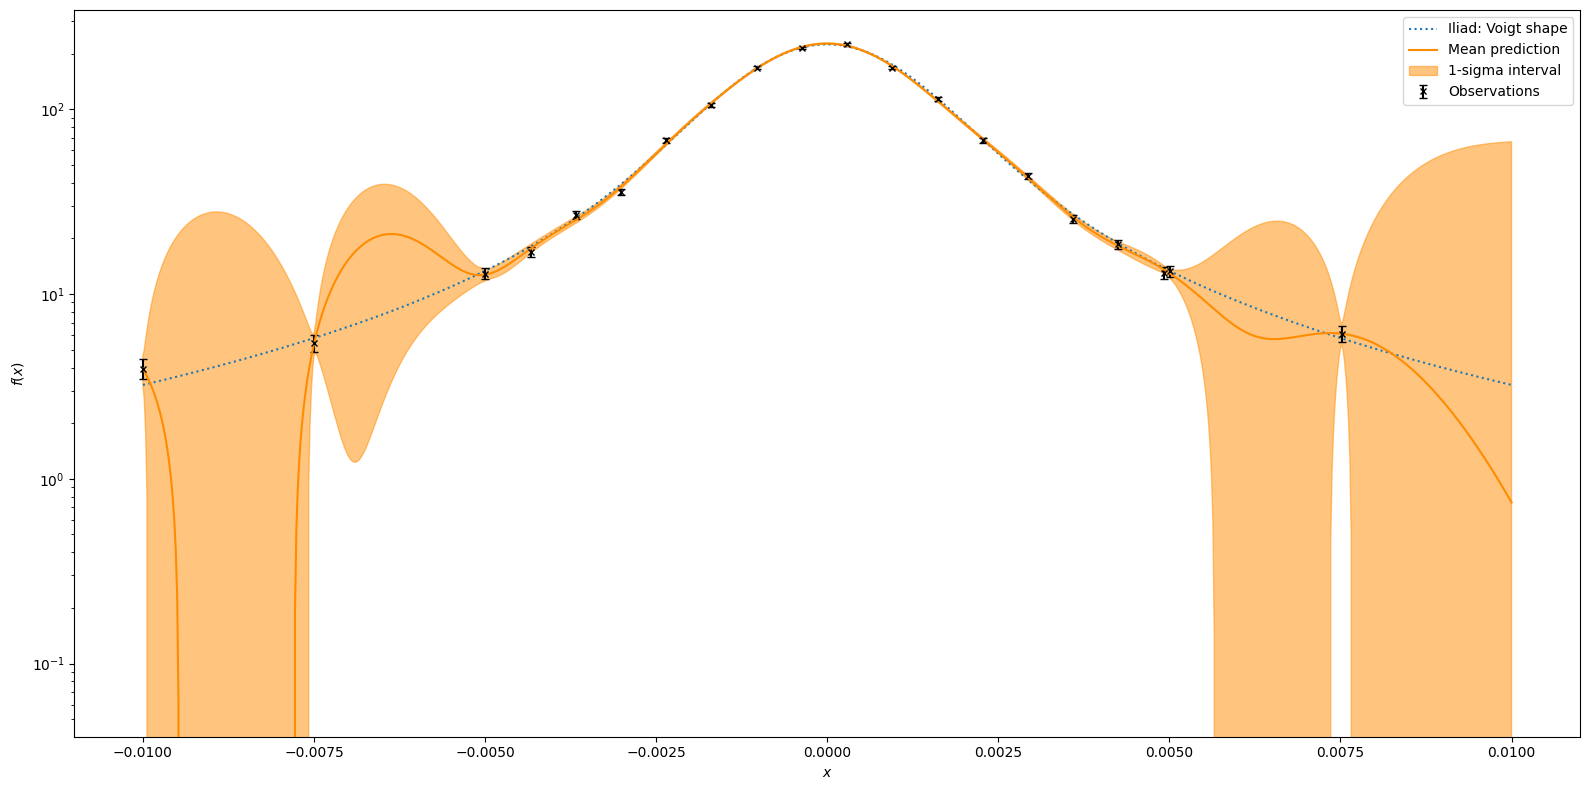

67.5**2 * RBF(length_scale=0.00137)
-96.12703039991358


In [ ]:
iliad_kernel = k_rbf

Iliad.label=r'Iliad: Voigt shape'
Iliad.gpr_fit(kernel=iliad_kernel,alpha=alpha_Iliad)
Iliad.title=r'Iliad: GPR RBF on yspaced poissioned'
Iliad.drawfit(noise=alpha_Iliad)
Iliad.title=r'Iliad: GPR RBF on yspaced poissioned log'
Iliad.drawfit(noise=alpha_Iliad,log=True)
print(Iliad.gpr_kernel)
print(Iliad.gpr_lml)

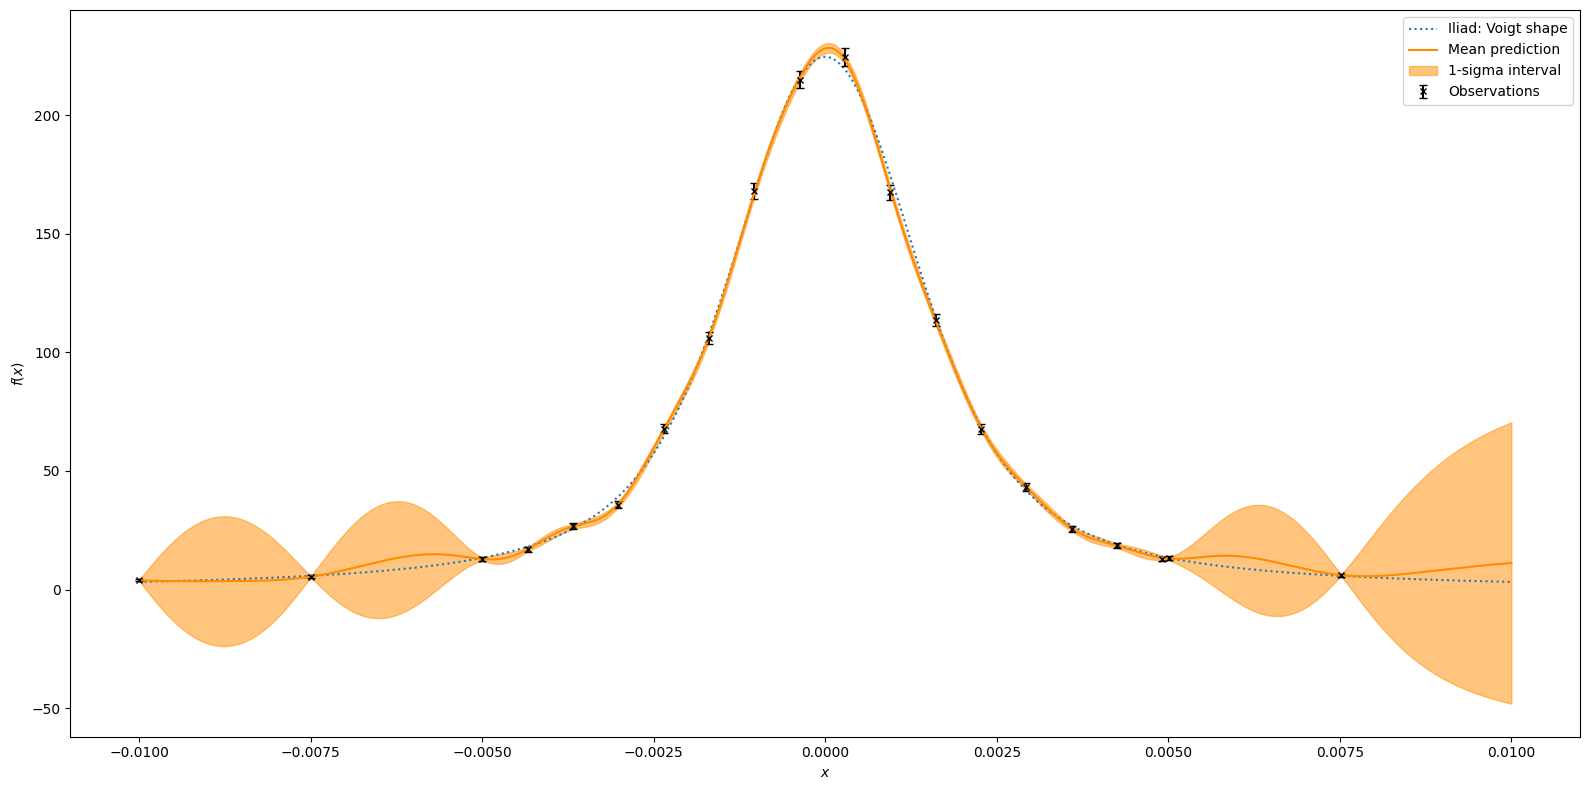

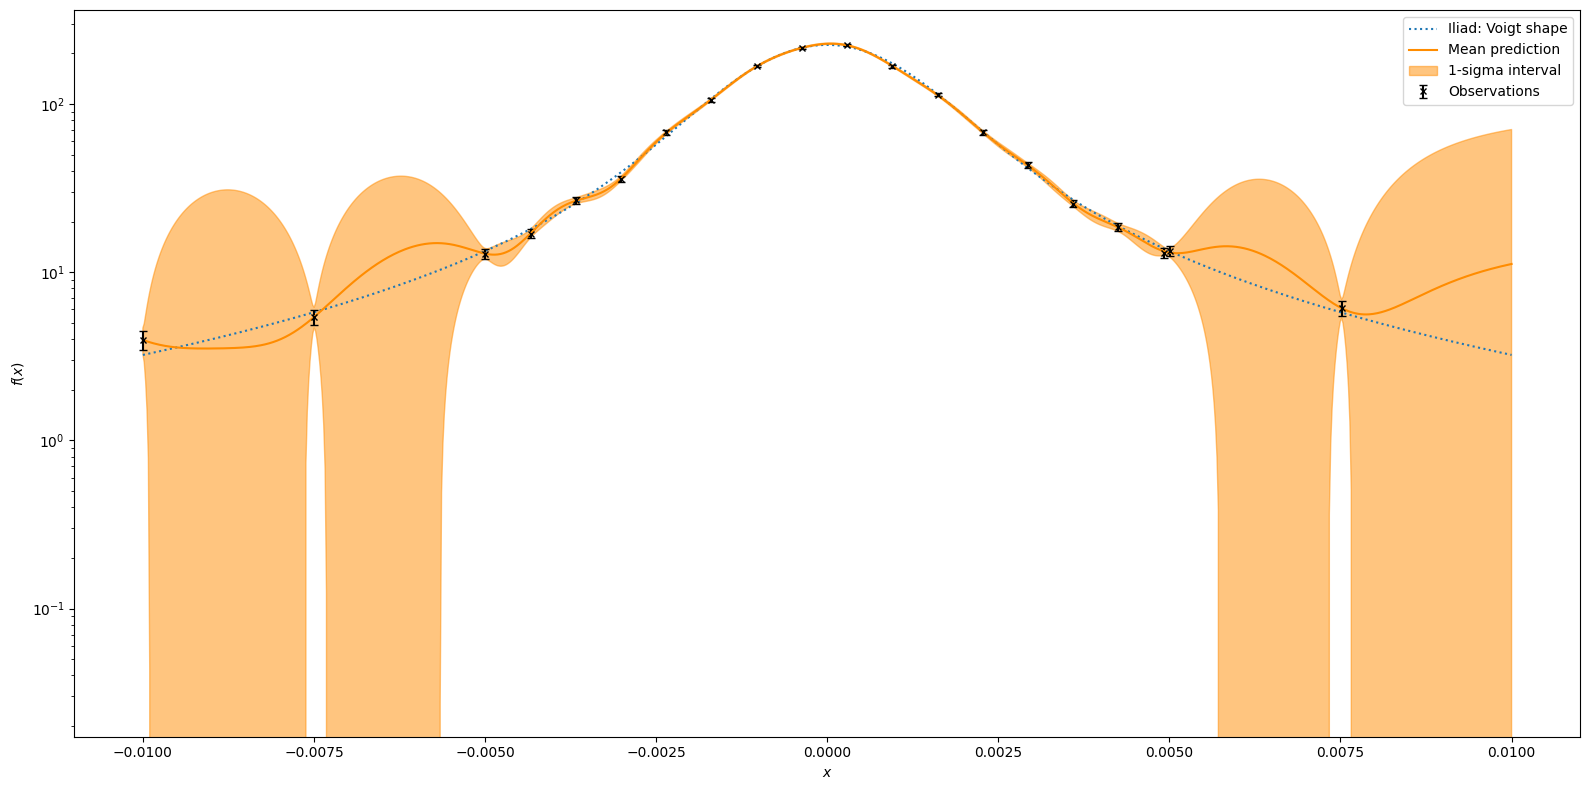

172**2 * RBF(length_scale=1.43e+09) * 0.471**2 * RationalQuadratic(alpha=0.327, length_scale=0.00202)
-90.01507963448367


In [ ]:
iliad_kernel = k_rbf * k_rq

Iliad.gpr_fit(kernel=iliad_kernel,alpha=alpha_Iliad)
Iliad.title=r'Iliad: GPR RBFRQ on yspaced poissioned'
Iliad.drawfit(noise=alpha_Iliad)
Iliad.title=r'Iliad: GPR RBFRQ on yspaced poissioned log'
Iliad.drawfit(noise=alpha_Iliad,log=True)
print(Iliad.gpr_kernel)
print(Iliad.gpr_lml)

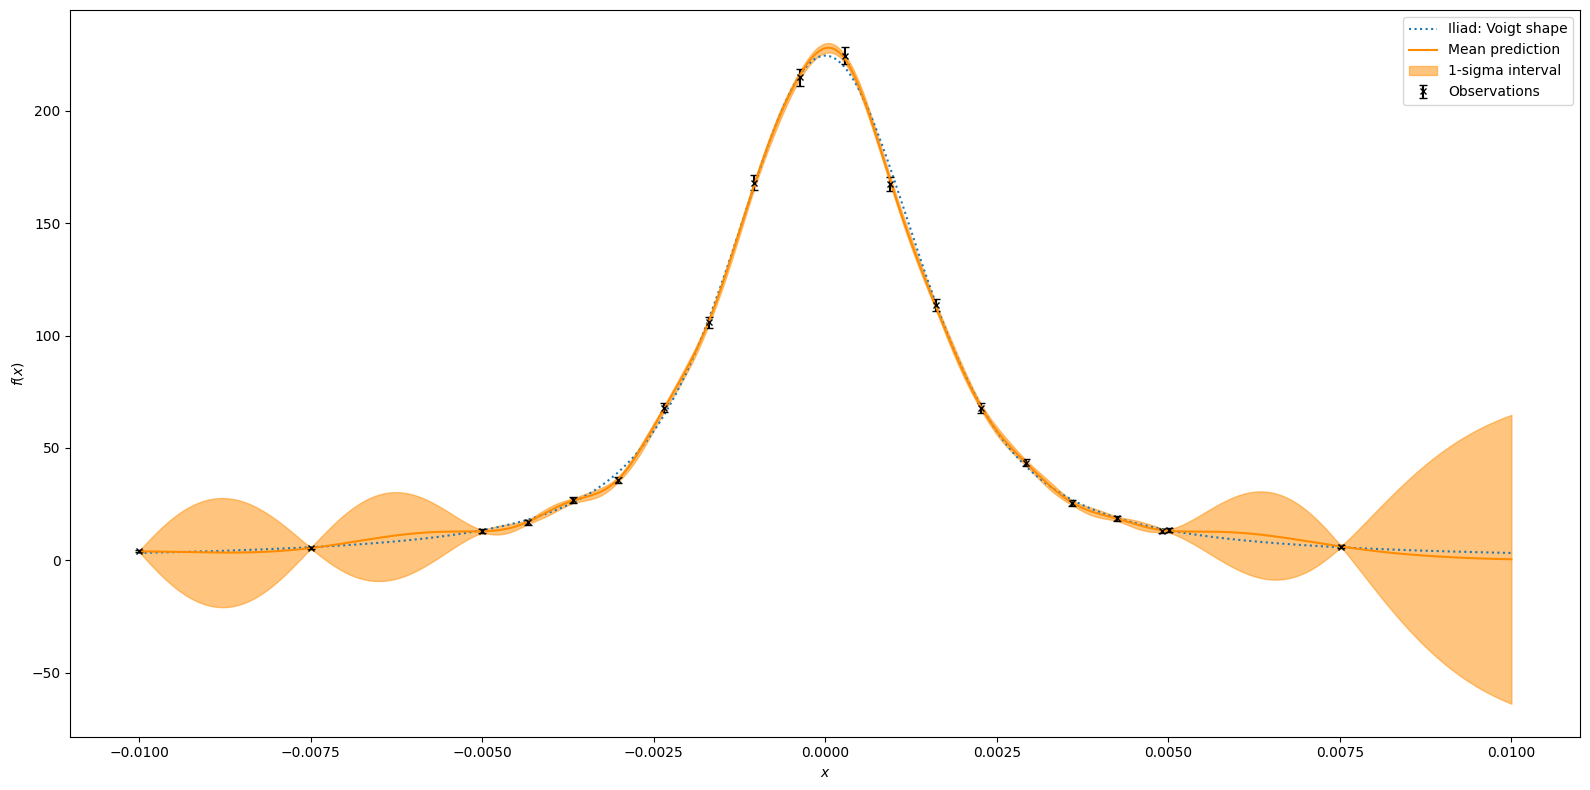

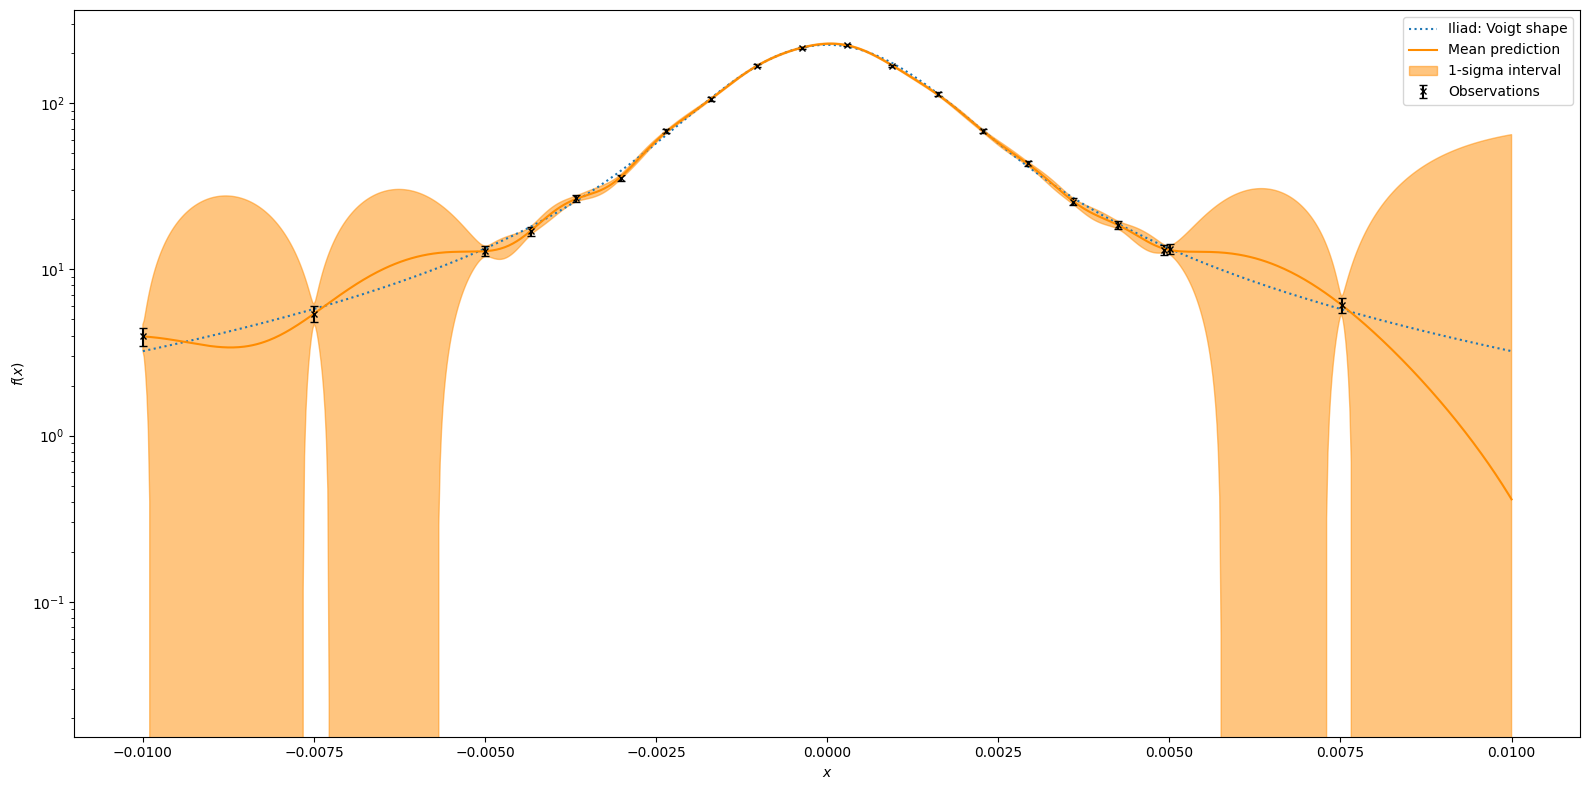

75.9**2 * Matern(length_scale=0.00238, nu=2.5)
-88.25611996655397


In [ ]:
iliad_kernel = k_m

Iliad.gpr_fit(kernel=iliad_kernel,alpha=alpha_Iliad)
Iliad.title=r'Iliad: GPR M on yspaced poissioned'
Iliad.drawfit(noise=alpha_Iliad)
Iliad.title=r'Iliad: GPR M on yspaced poissioned log'
Iliad.drawfit(noise=alpha_Iliad,log=True)
print(Iliad.gpr_kernel)
print(Iliad.gpr_lml)

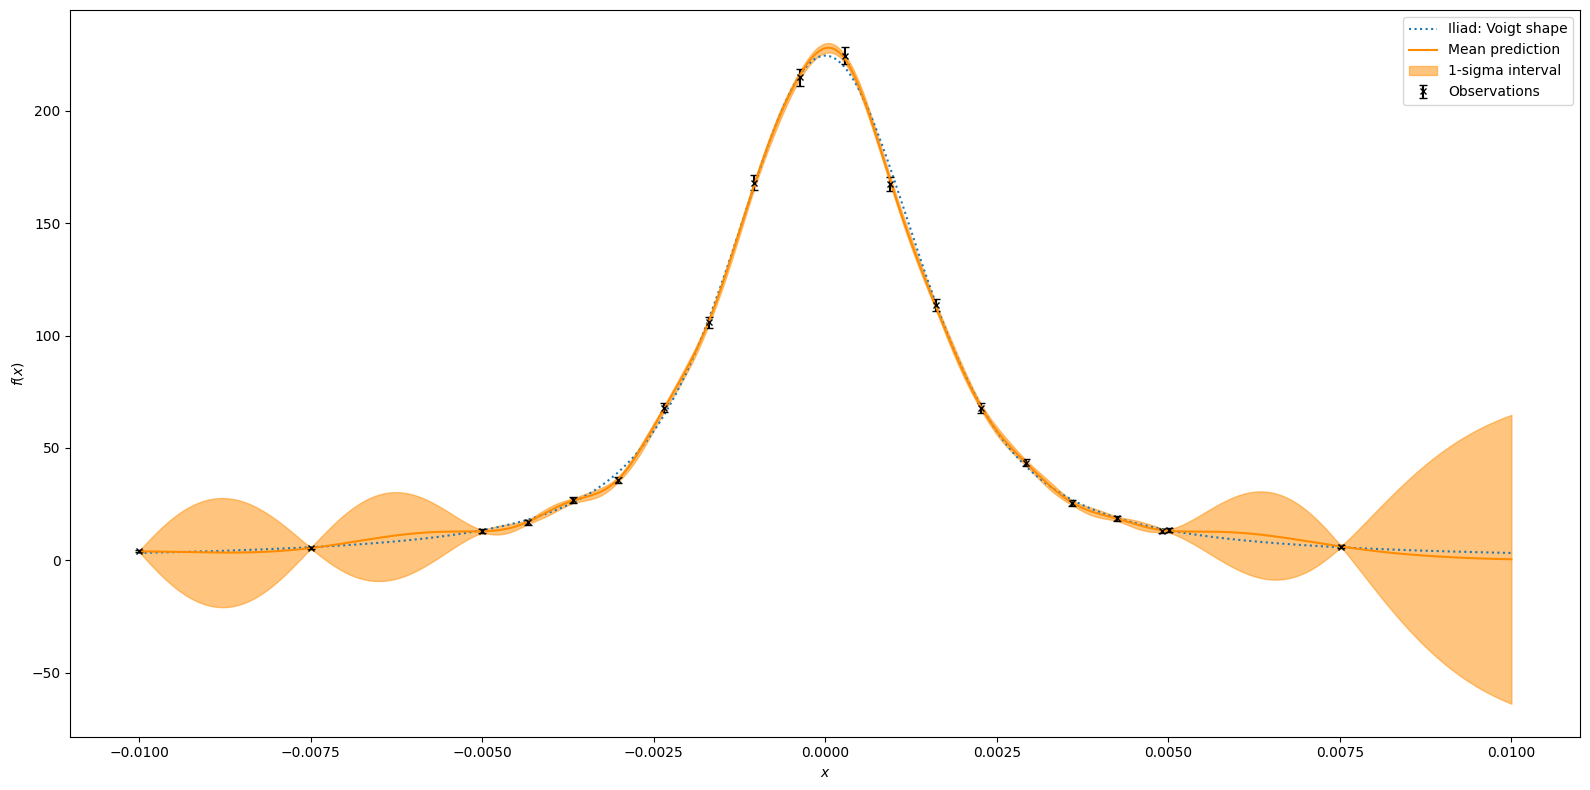

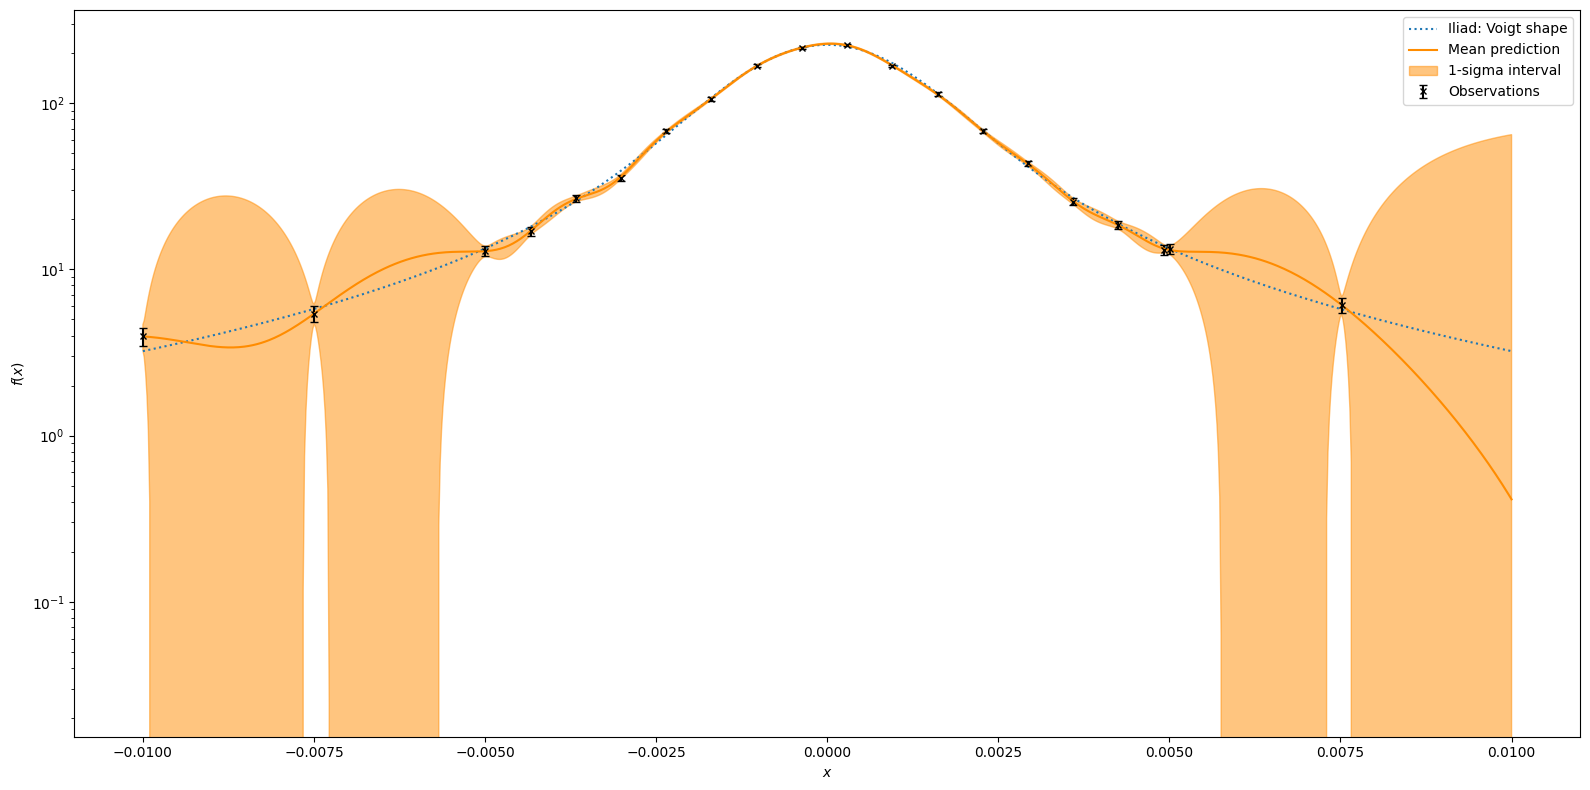

11.1**2 * Matern(length_scale=0.00238, nu=2.5) * 6.81**2 * RationalQuadratic(alpha=5.27e+08, length_scale=1.09e+19)
-88.25611996655277


In [ ]:
iliad_kernel = k_m * k_rq

Iliad.gpr_fit(kernel=iliad_kernel,alpha=alpha_Iliad)
Iliad.title=r'Iliad: GPR MRQ on yspaced poissioned'
Iliad.drawfit(noise=alpha_Iliad)
Iliad.title=r'Iliad: GPR MRQ on yspaced poissioned log'
Iliad.drawfit(noise=alpha_Iliad,log=True)
print(Iliad.gpr_kernel)
print(Iliad.gpr_lml)

# Experiment 4: ZLP Fit

In [ ]:
class ZLP(DataAnalyzer):
  def __init__(self, name = 'zlp1', label=None):
    self.function_name = self.title = self.X_train = self.y_train = None
    # this code was submitted by the group to import data from json! (modified)
      # enter name without file extension
    data = np.load('drive/MyDrive/ZLP/' + name +'.npy')
    f = open('drive/MyDrive/ZLP/' + name +'.json')
    meta = json.load(f)
    offset = meta['spatial_calibrations'][0]['offset']
    scale = meta['spatial_calibrations'][0]['scale']
    units = meta['spatial_calibrations'][0]['units']
    energy = np.arange(offset,offset+data.shape[0]*scale,scale)
    self.X_train = self.X = energy.reshape(-1,1)
    self.y_train = self.y = data
    self.label = label

  def center(self, radius=50):
    # inspect interesting chunk
    # @radius: please check the output for the peak entry: radius may not be bigger than this!
    Y_sorted_index = np.argsort(self.y_train)
    Y_sorted = self.y_train[Y_sorted_index]
    peakpoint_index = Y_sorted_index[-1]
    print("peak index: ", peakpoint_index)
    print("peak value: ", Y_sorted[-1])
    print("we will slice now", peakpoint_index - radius, peakpoint_index + radius)

    self.X_train = self.X = self.X_train[peakpoint_index - radius:peakpoint_index + radius]
    self.y_train = self.y = self.y_train[peakpoint_index - radius:peakpoint_index + radius]

  def wing(self,length=100):
    Y_sorted_index = np.argsort(self.y_train)
    Y_sorted = self.y_train[Y_sorted_index]
    peakpoint_index = Y_sorted_index[-1]
    self.X_train = self.X = self.X_train[peakpoint_index:peakpoint_index + length]
    self.y_train = self.y = self.y_train[peakpoint_index:peakpoint_index + length]

  def resolute(self, resolution = 1e+4):
    res_count = resolution * (abs(np.min(self.X_train)) + abs(np.max(self.X_train))) # one could assume peak centered at x=0 but we exclude this error for unexpected future uses and thus taking the absolute
    res_count = int(res_count)
    x_zone = np.linspace(np.min(self.X_train),np.max(self.X_train),res_count)
    self.X = x_zone.reshape((res_count,1))
    self.y = None # once we are processing data to this point, there is no need to plot a dashed line anymore

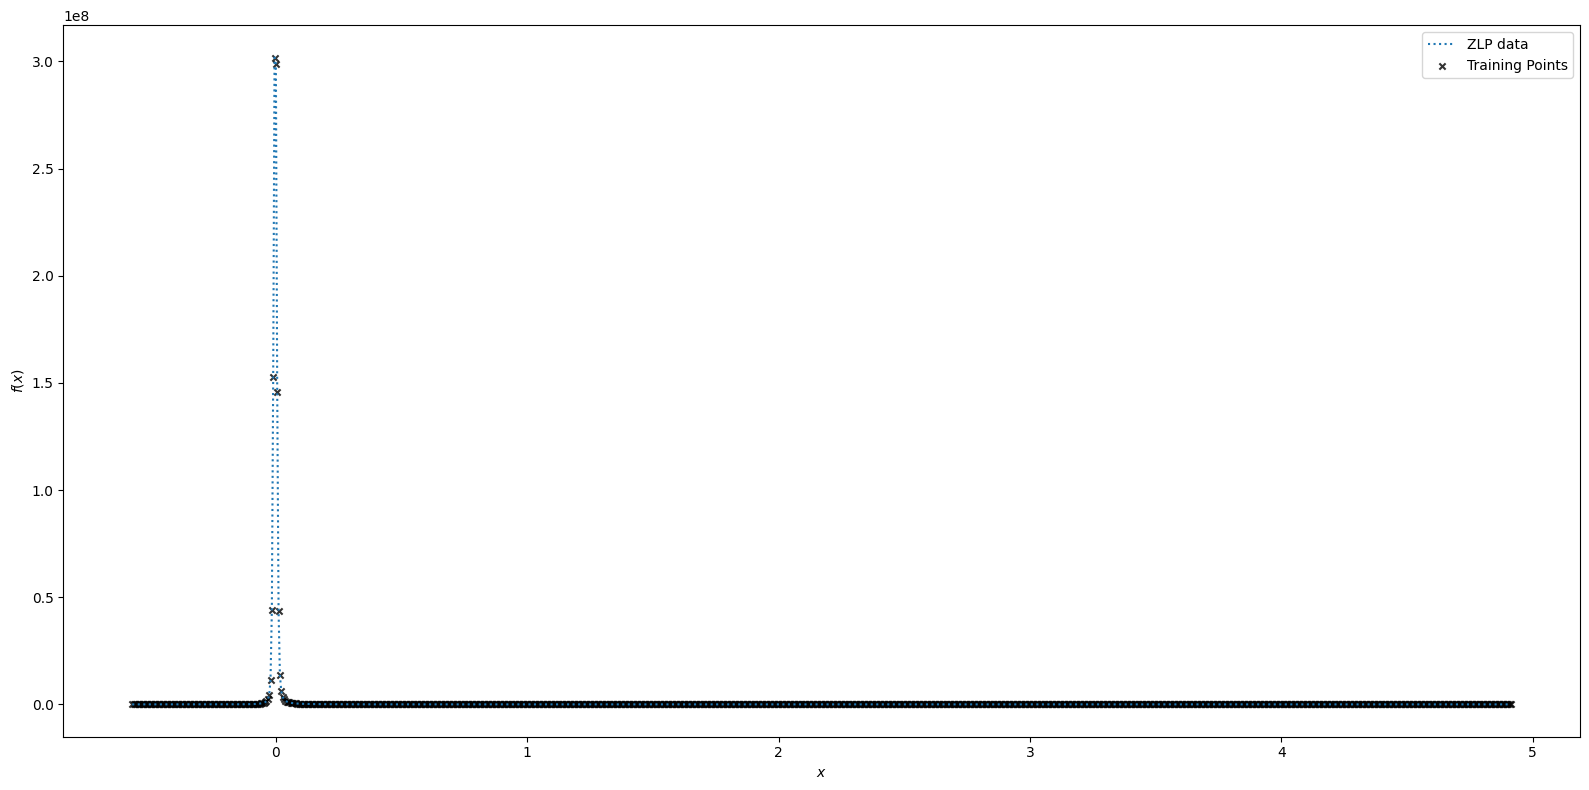

In [ ]:
Zarael = ZLP('zlp2')
Zarael.label="ZLP data"
Zarael.title=r'ZLP raw data'
Zarael.draw()
#print(Zarael.X_train) # data can be called

## `Zarael`-Experiment (center)

In [ ]:
Zarael.center()
Zarael.resolute(1e+4)
Zarael.title=r'Zarael centered'
#Zarael.draw()

peak index:  106
peak value:  301823940.0
we will slice now 56 156


In [ ]:
#kernel
k_rbf = 1**2 * RBF(length_scale=100.0, length_scale_bounds=(1e-5, 1e20)) # default bounds = (1e-5, 1e5)
k_rq = 1**2 * RationalQuadratic(length_scale=1.0, alpha=1, length_scale_bounds=(1e-05, 1e20), alpha_bounds=(1e-05, 1e10))
k_m = 1**2 * Matern(length_scale=1.0,nu=3.5)
k_rbfrq = k_rbf * k_rq
k_mrq = k_m * k_rq

### RBF

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


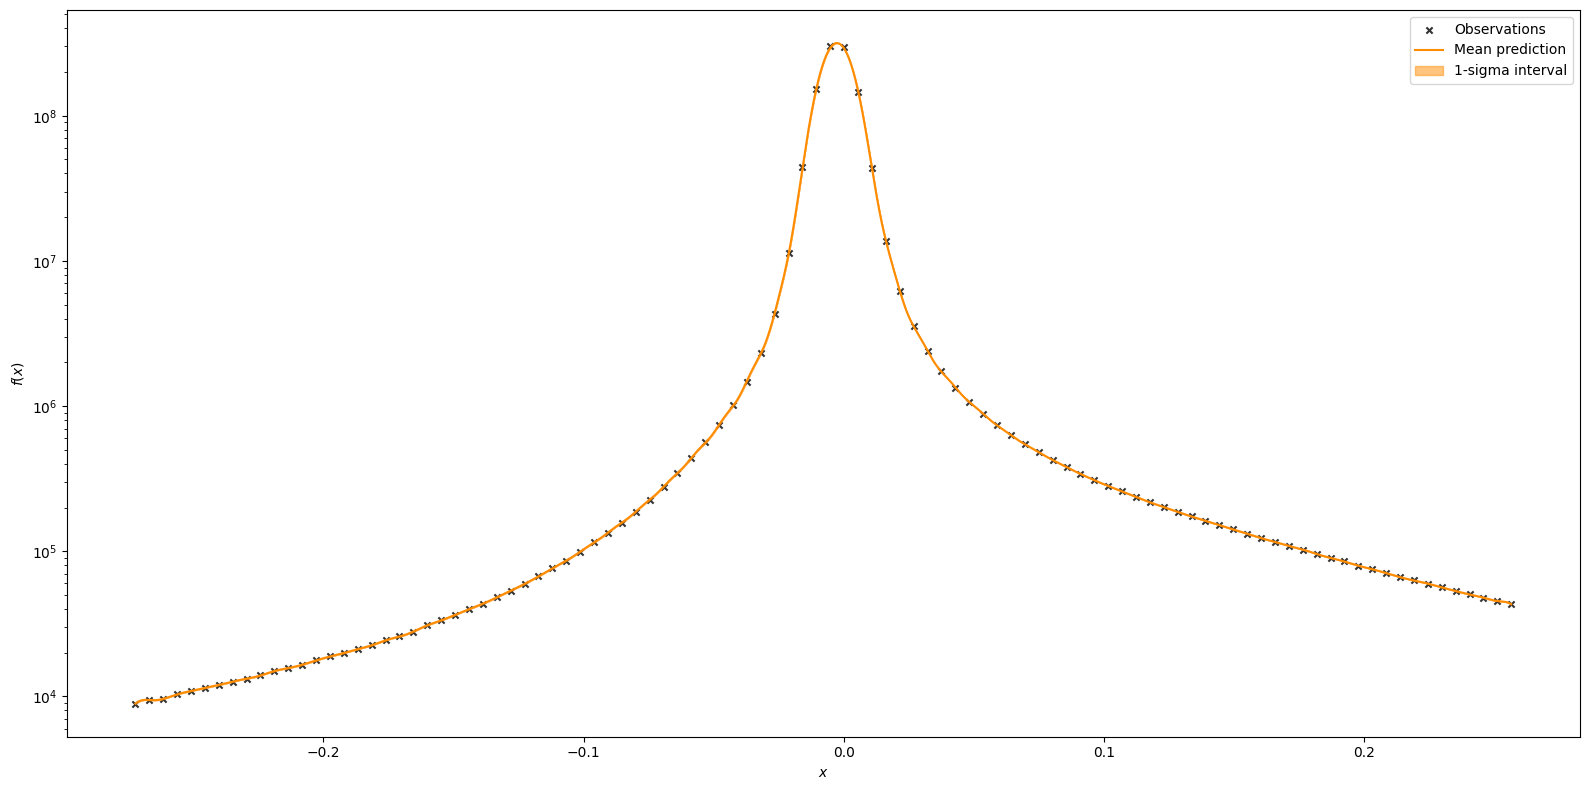

316**2 * RBF(length_scale=0.00657)


In [ ]:
Zarael.gpr_fit(kernel=k_rbf, alpha = np.sqrt(Zarael.y_train)/4)

Zarael.title=r'Zarael GPR RBF Fit'
#Zarael.drawfit(log=False)
Zarael.title=r'Zarael GPR RBF Fit log'
Zarael.drawfit(log=True)
print(Zarael.gpr_kernel)

### Matern

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


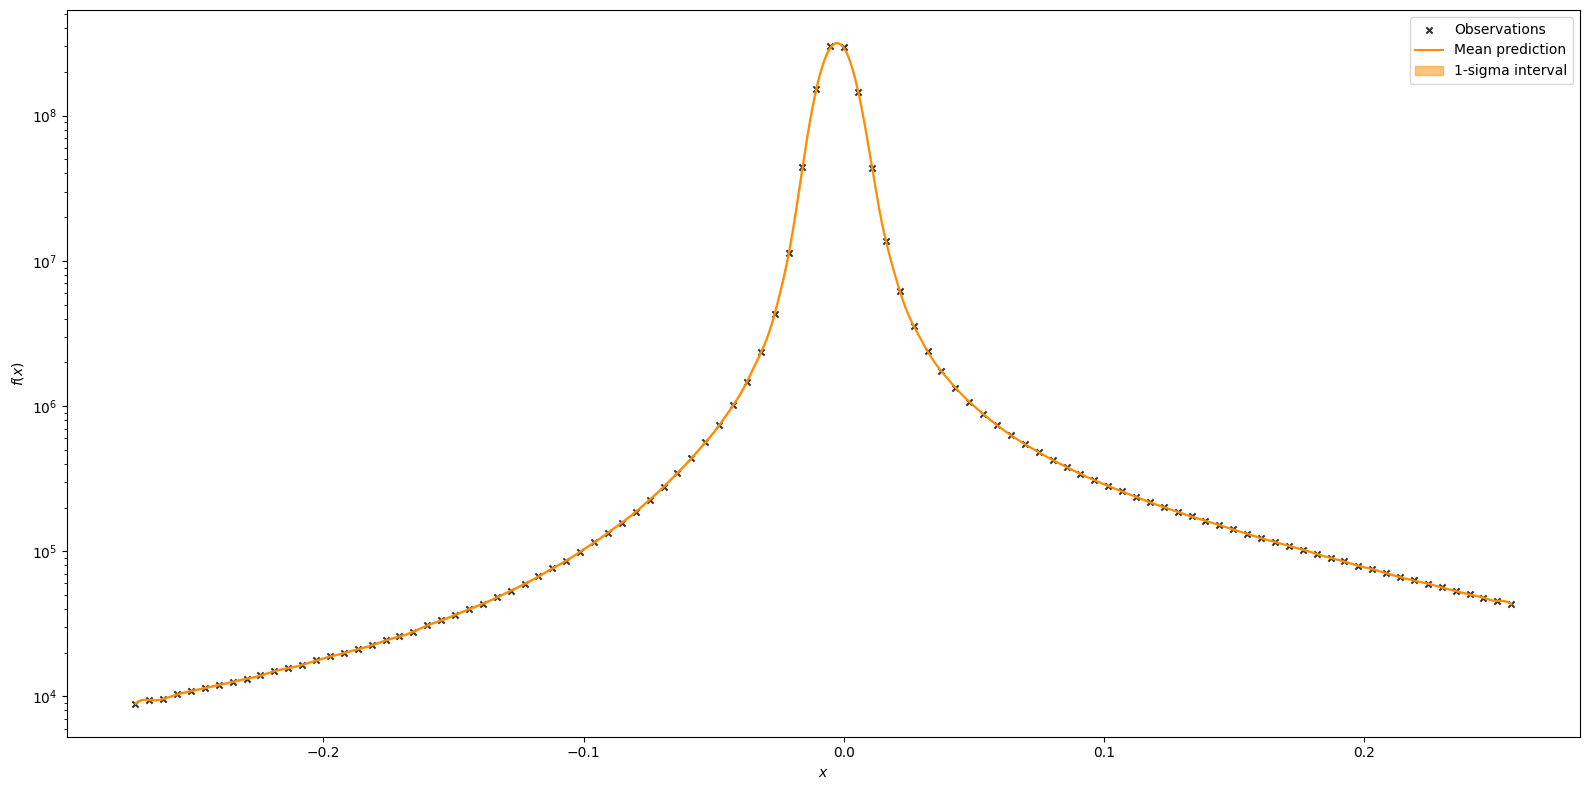

316**2 * Matern(length_scale=0.00723, nu=3.5)


In [ ]:
Zarael.gpr_fit(kernel=k_m, alpha = np.sqrt(Zarael.y_train)/4)

Zarael.title=r'Zarael GPR M Fit'
#Zarael.drawfit(log=False)
Zarael.title=r'Zarael GPR M Fit log'
Zarael.drawfit(log=True)
print(Zarael.gpr_kernel)

### RBFRQ

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


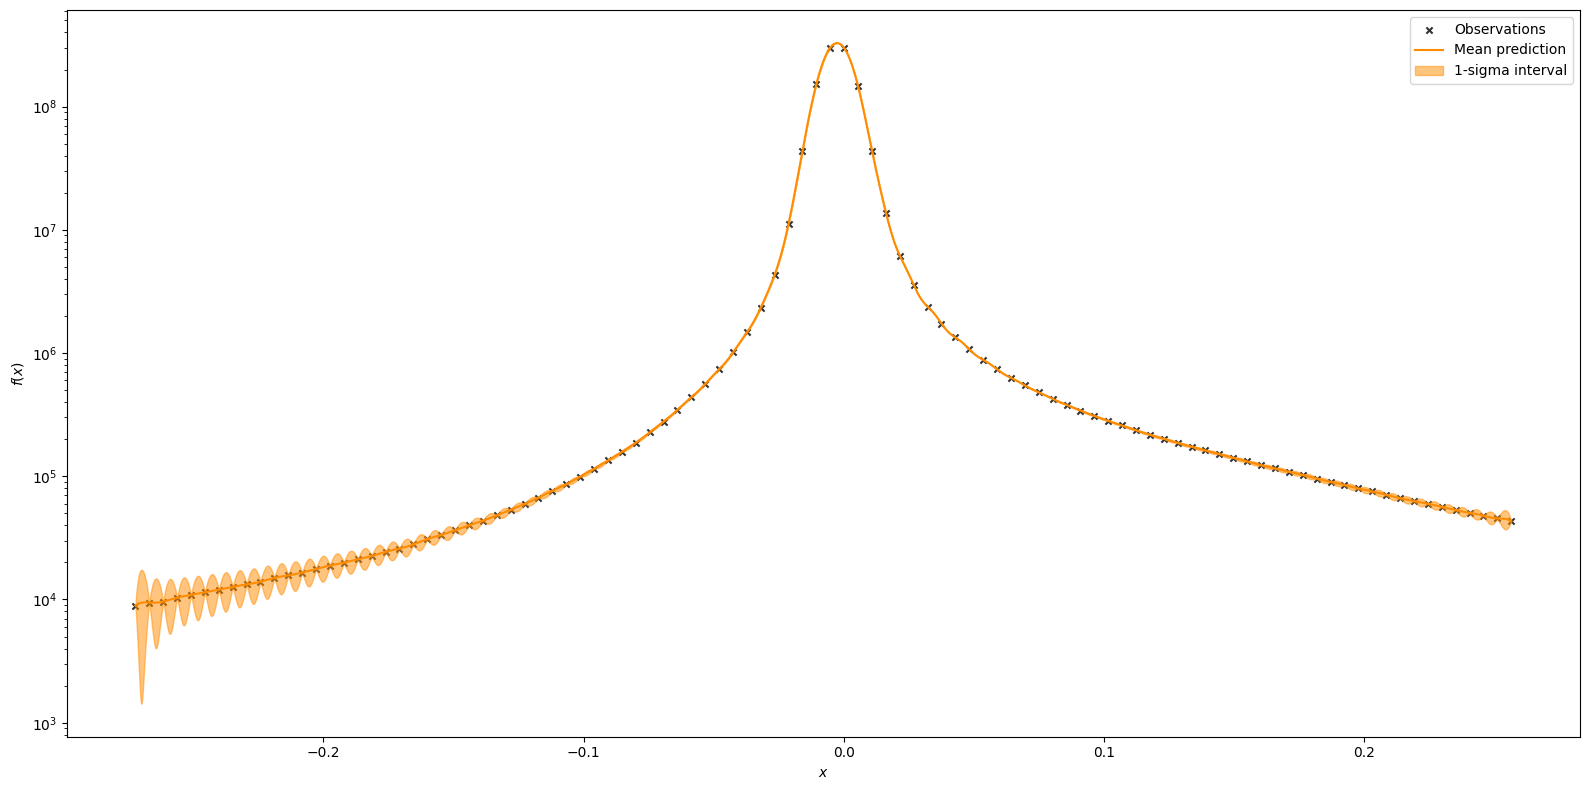

316**2 * RBF(length_scale=2.23e+17) * 316**2 * RationalQuadratic(alpha=12.3, length_scale=0.00628)


In [ ]:
Zarael.gpr_fit(kernel=k_rbfrq, alpha = np.sqrt(Zarael.y_train))

#Zarael.title=r'Zarael GPR RBFRQ Fit'
#Zarael.drawfit(log=False)
Zarael.title=r'Zarael GPR RBFRQ Fit log'
Zarael.drawfit(log=True)
print(Zarael.gpr_kernel)

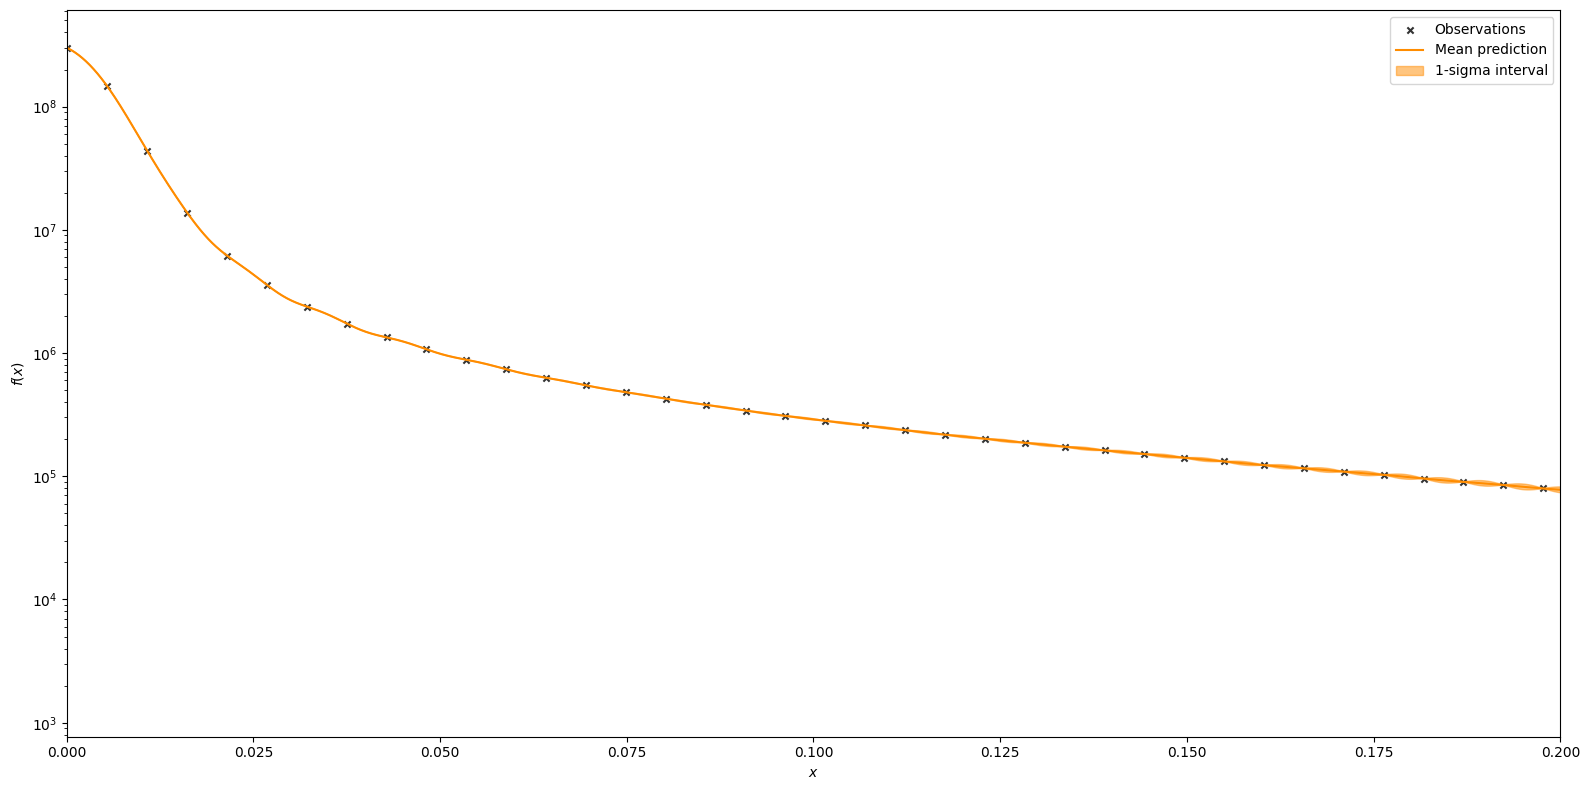

In [ ]:
Zarael.title=r'Zarael ZOOM GPR RBFRQ Fit log'
Zarael.drawfit(xlim=(0,0.2), log=True)

### MRQ

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


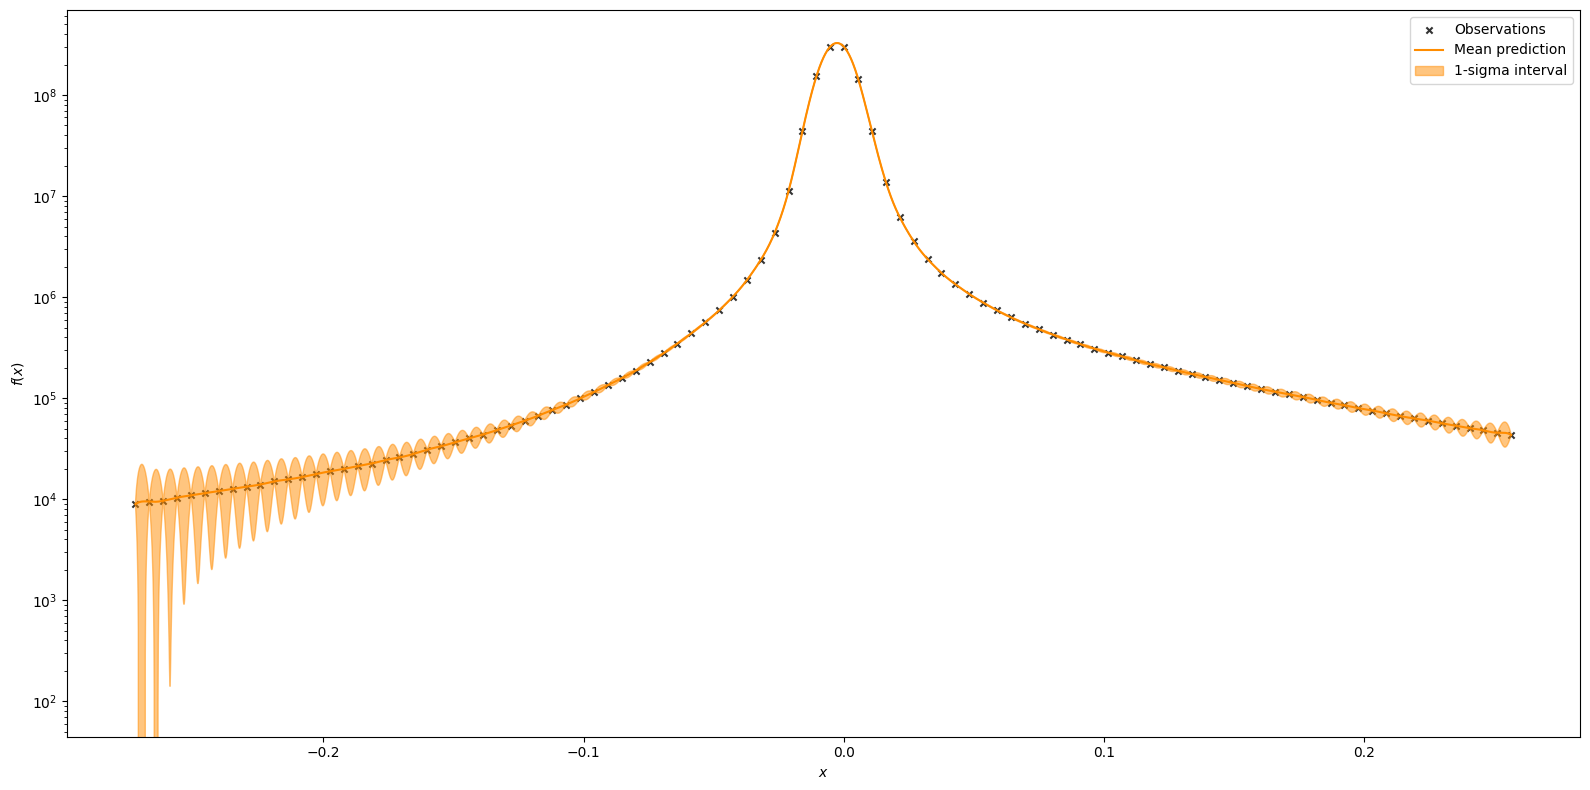

316**2 * Matern(length_scale=0.0575, nu=3.5) * 316**2 * RationalQuadratic(alpha=2.53, length_scale=0.00608)


In [ ]:
Zarael.gpr_fit(kernel=k_mrq, alpha = np.sqrt(Zarael.y_train))
# Zarael.title=r'Zarael GPR MRQ Fit'
# Zarael.drawfit(log=False)
Zarael.title=r'Zarael GPR MRQ Fit log'
Zarael.drawfit(log=True)
print(Zarael.gpr_kernel)

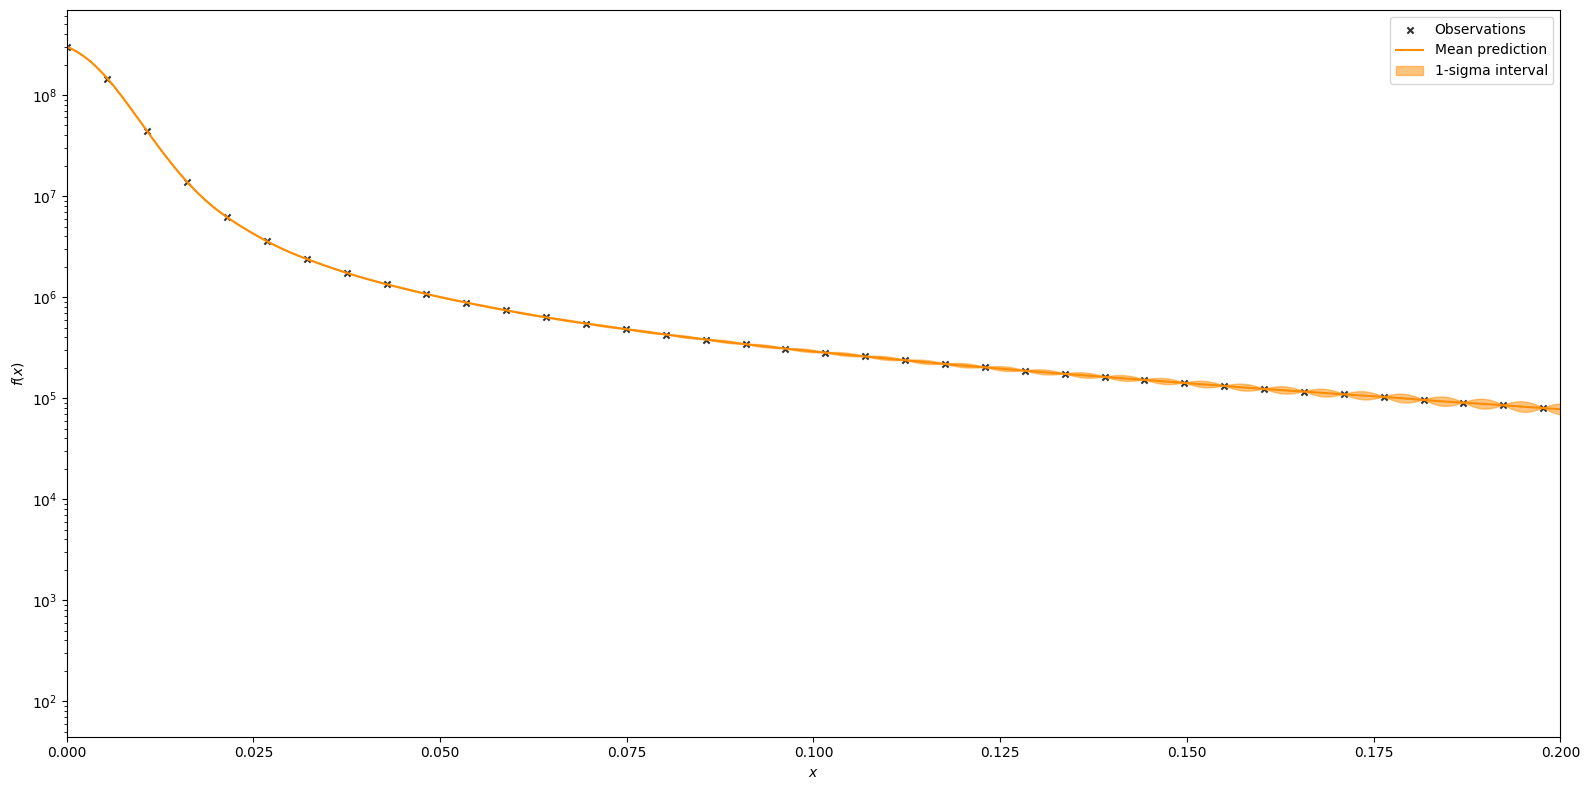

In [ ]:
Zarael.title=r'Zarael ZOOM GPR MRQ Fit log'
Zarael.drawfit(xlim=(0,0.2), log=True)

## `Zaelia`-Experiment (Wing)

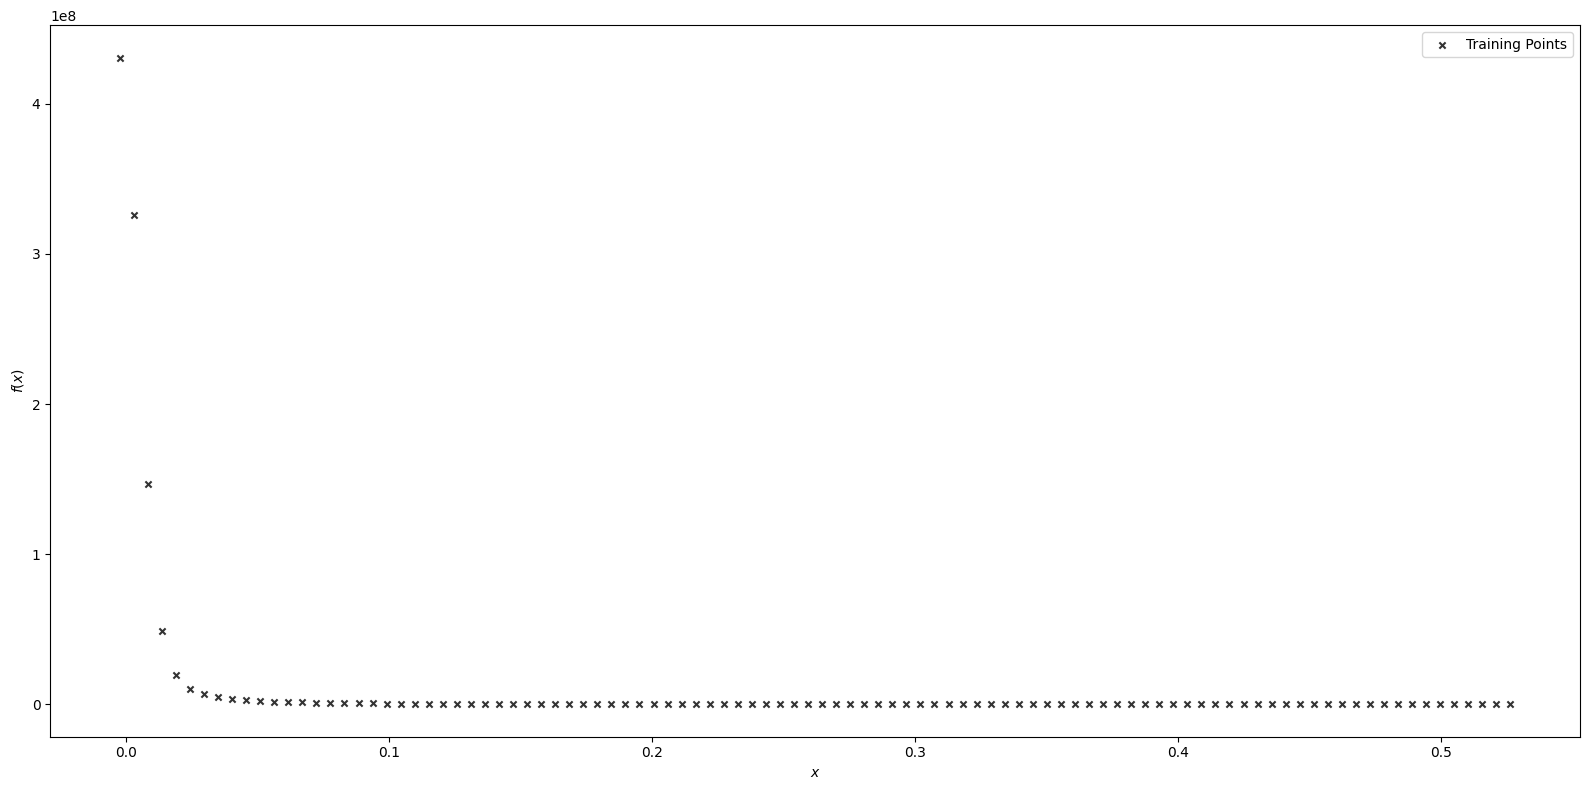

In [ ]:
Zaelia = ZLP()
Zaelia.wing()
Zaelia.resolute(1e+4)
Zaelia.title=r'Zaelia Wing'
Zaelia.draw()

### RBFRQ

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1e+20. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


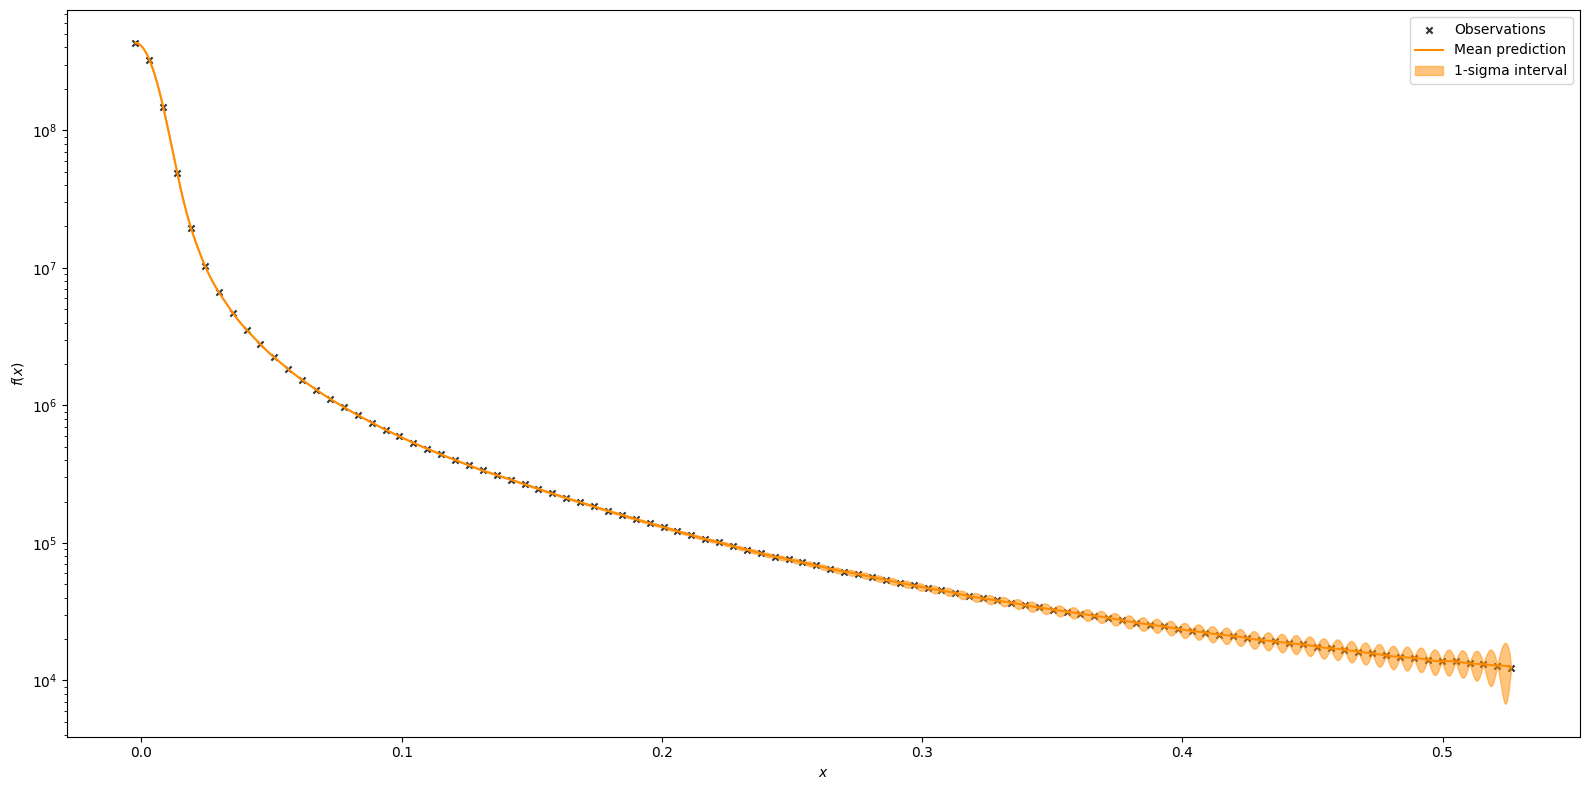

316**2 * RBF(length_scale=1e+20) * 316**2 * RationalQuadratic(alpha=7.89, length_scale=0.007)


In [ ]:
Zaelia.gpr_fit(kernel=k_rbfrq, alpha = np.sqrt(Zaelia.y_train)/4)
# Zaelia.title=r'Zaelia GPR Fit RBFRQ'
# Zaelia.drawfit(log=False)
Zaelia.title=r'Zaelia GPR Fit RBFRQ log'
Zaelia.drawfit(log=True)
print(Zaelia.gpr_kernel)

### MRQ

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


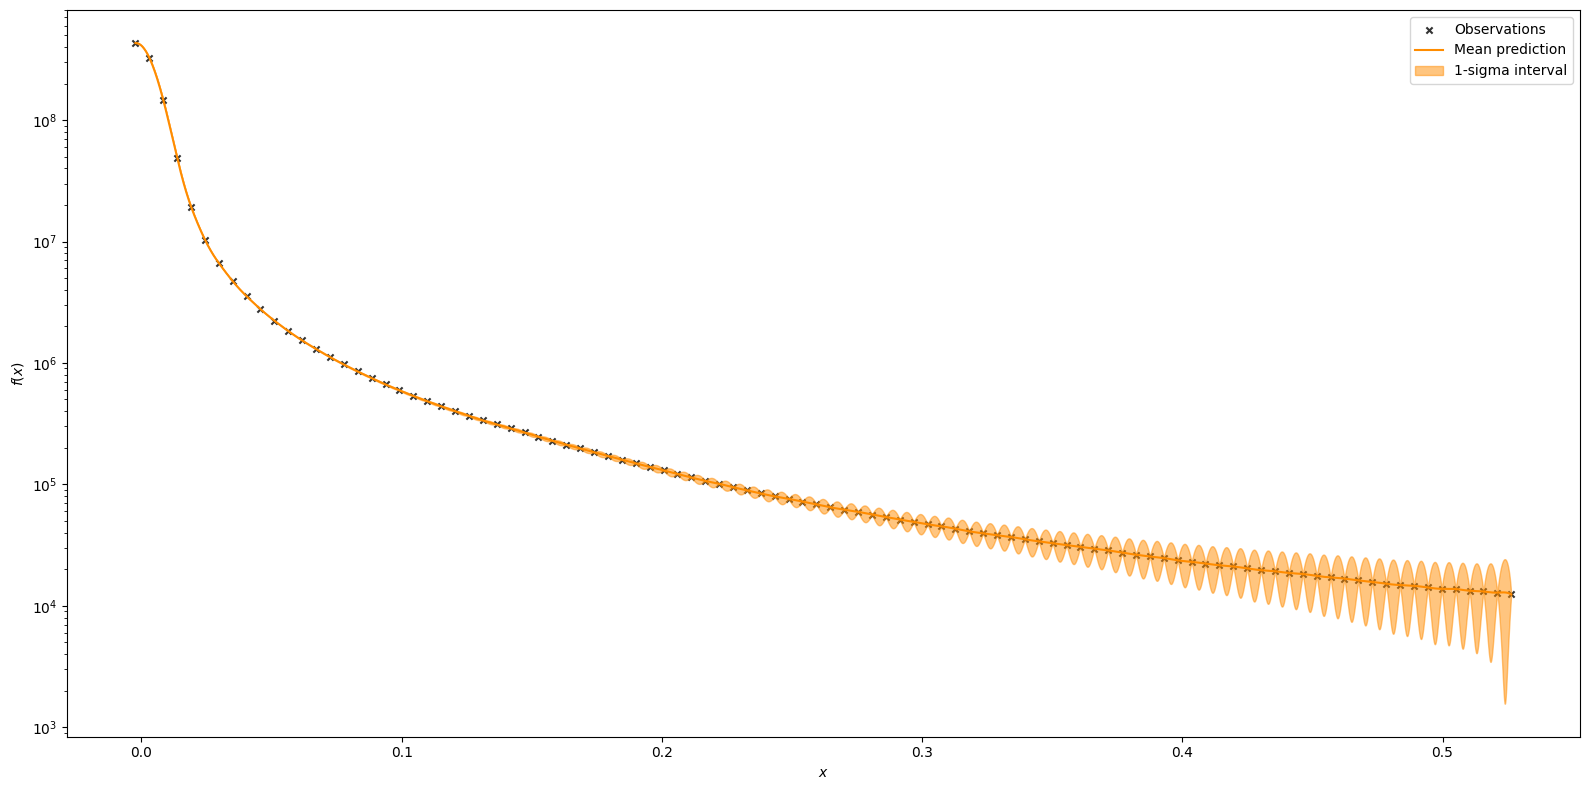

316**2 * Matern(length_scale=0.00777, nu=3.5) * 316**2 * RationalQuadratic(alpha=2.6e+05, length_scale=6.08e+12)


In [ ]:
Zaelia.gpr_fit(kernel=k_mrq, alpha = np.sqrt(Zaelia.y_train)/4)
# Zaelia.title=r'Zaelia GPR Fit MRQ'
# Zaelia.drawfit(log=False)
Zaelia.title=r'Zaelia GPR Fit MRQ log'
Zaelia.drawfit(log=True)
print(Zaelia.gpr_kernel)

## `Zurriem`-Experiment (long wing)

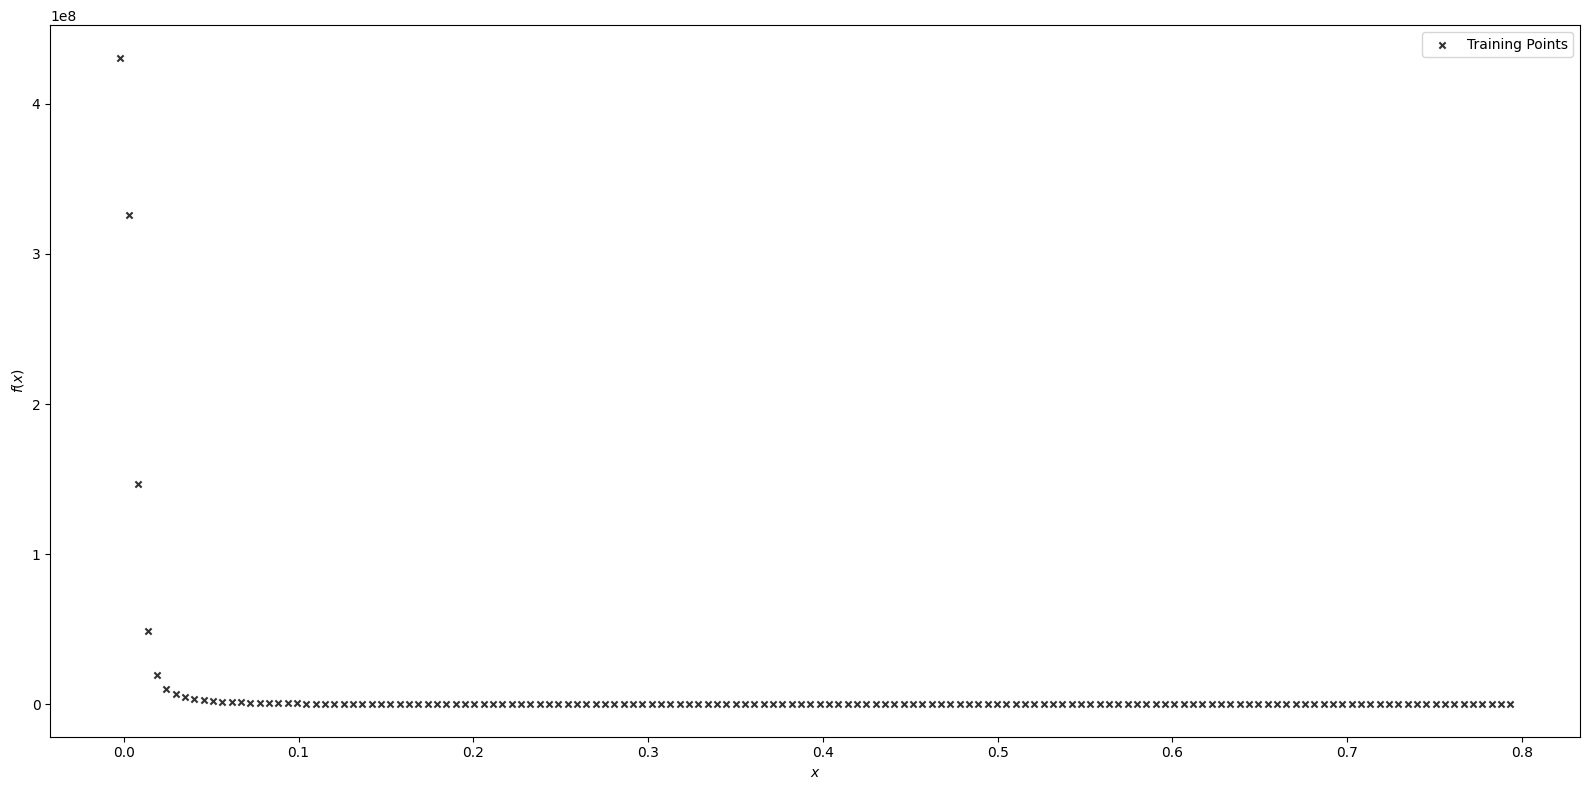

In [ ]:
Zurriem = ZLP()
Zurriem.wing(length=150)
Zurriem.resolute(1e+5)
Zurriem.title = r'test'
Zurriem.draw()

### RBFRQ

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


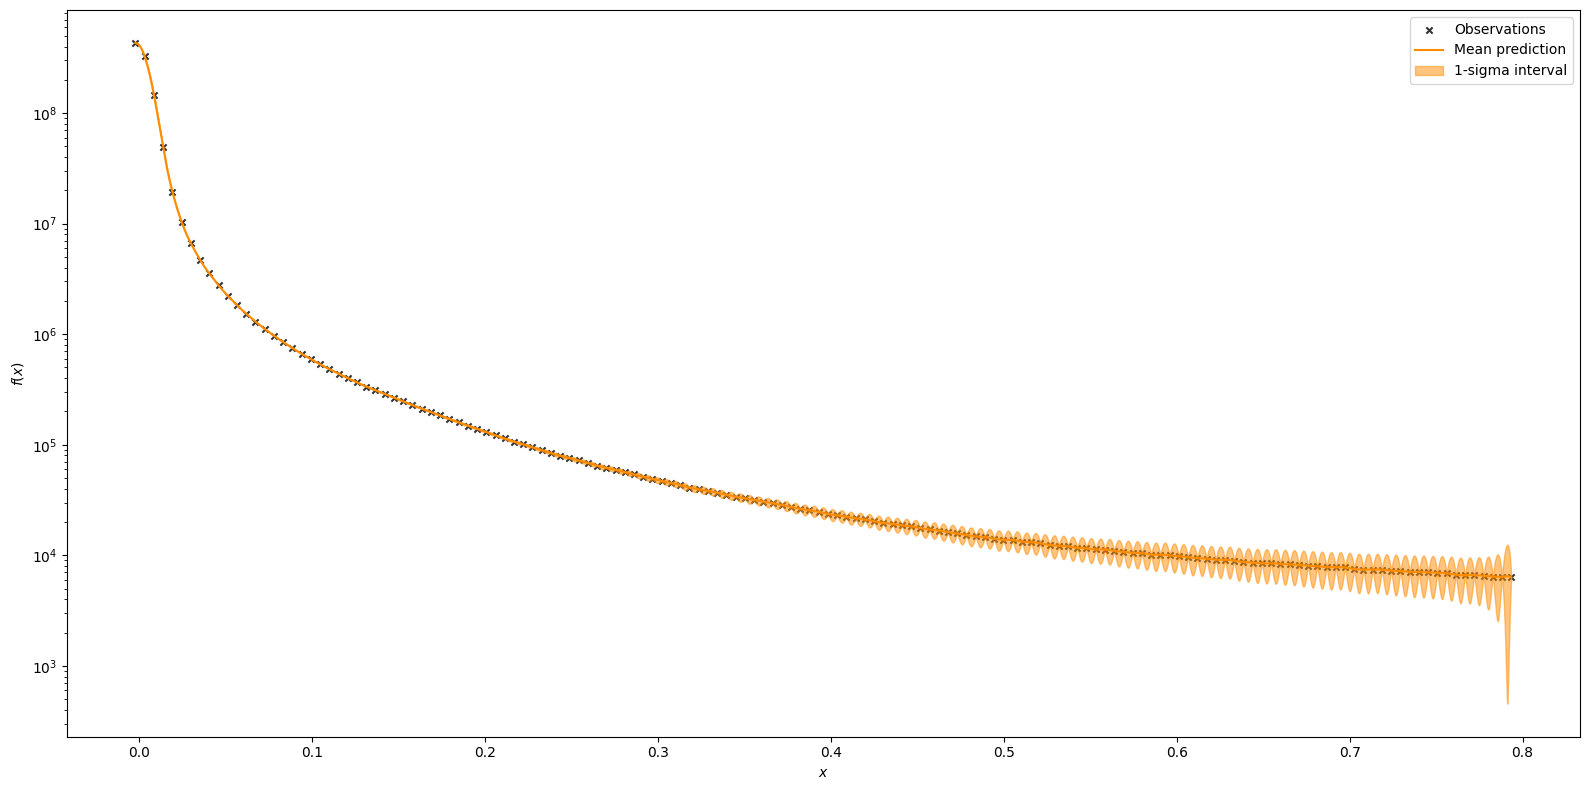

316**2 * RBF(length_scale=2.53e+16) * 316**2 * RationalQuadratic(alpha=7.9, length_scale=0.007)


In [ ]:
Zurriem.gpr_fit(kernel=k_rbfrq, alpha = np.sqrt(Zurriem.y_train))
# Zurriem.title=r'Zurriem GPR Fit RBFRQ'
# Zurriem.drawfit(log=False)
Zurriem.title=r'Zurriem GPR Fit RBFRQ log'
Zurriem.drawfit(log=True)
print(Zurriem.gpr_kernel)

### MRQ

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:445: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


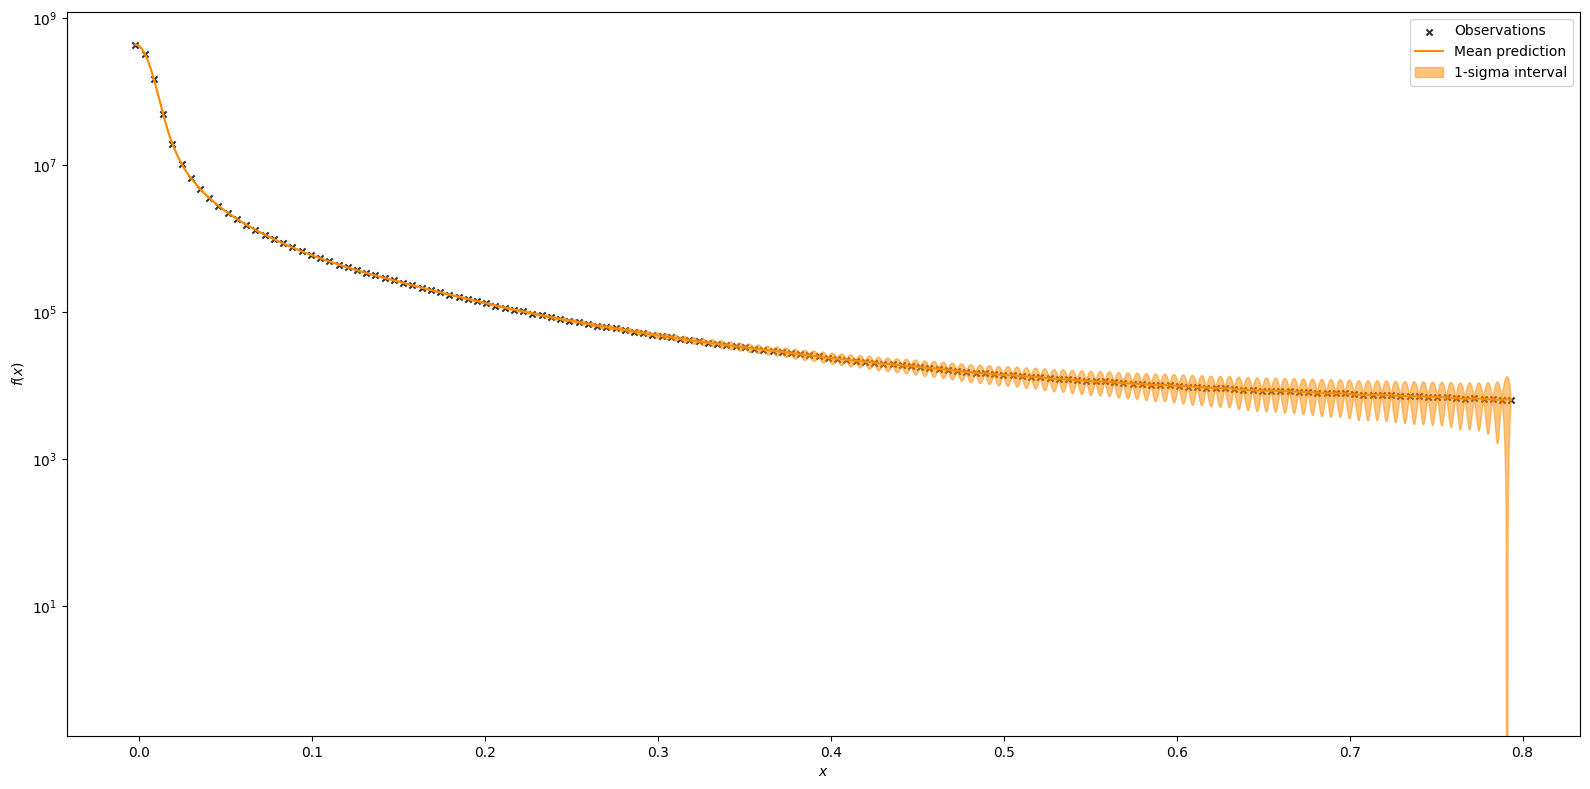

316**2 * Matern(length_scale=0.0116, nu=3.5) * 316**2 * RationalQuadratic(alpha=7.74e+07, length_scale=0.00993)


In [ ]:
Zurriem.gpr_fit(kernel=k_mrq, alpha = np.sqrt(Zurriem.y_train))
# Zurriem.title=r'Zurriem GPR Fit MRQ'
# Zurriem.drawfit(log=False)
Zurriem.title=r'Zurriem GPR Fit MRQ log'
Zurriem.drawfit(log=True)
print(Zurriem.gpr_kernel)